## 5. Feature Engineering for Surface-Deep

**Purpose**

The Surface–Deep (S-D) dimension is used to understand the cognitive depth or complexity of users’ search behavior. It helps to distinguish between queries that are:

1. **Surface**: queries that are straightforward, factual, or seek simple information.
    - These queries indicate basic, concrete information-seeking.
    - Eg: "What is photosynthesis?", "Definition of osmosis", "iPhone 14 battery life".

2. **Deep**: queries that involve comparison, reasoning, reformulation, or exploration of concepts.
    - These queries indicate higher-order thinking or analytical exploration.
    - Eg: "iPhone 14 vs Samsung Galaxy S23 pros and cons", "How solar panel efficiency varies in Singapore", "Reformulations to refine search intent".

This helps to identify how users progress from simple fact-finding (surface) to deeper inquiry and reasoning (deep).

**Features to Engineer**

- **Question detection**: Identify whether the query starts with “What/Who/When/Why/Where/How” (surface-level) using regex.
- **Closure detection**: Detect queries seeking clear answers (e.g., "definition", "meaning", "synonym") using a lexicon–embedding hybrid strategy.
- **Comparative detection**: Detect comparative queries with keywords like "vs", "compare", "pros/cons" using lexicon–embedding hybrid.
- **Reformulation**: Measure similarity or difference between consecutive queries using Levenshtein distance to capture deep-level exploration.
- **Lexicon–embedding hybrid**: Use curated starter lexicons, embed them to find semantic neighbors, manually inspect neighbors, and create final lexicons to detect relevant keywords/keyphrases.

### 5.1 Feature 1: Question Detection Using Regex

**Question Detection**

The Question feature identifies whether a user query is framed as a direct question. Queries starting with interrogative words often indicate surface-level information-seeking behavior, such as factual or explanatory searches. This helps differentiate between queries that are exploratory versus queries seeking immediate answers.

In our implementation, all queries are processed. Each query is checked to see if it begins with one of the following words: What, Who, When, Why, Where, How. Queries matching these patterns are flagged as "`question`", while all others are flagged as "`not_question`".

Additionally, we compute a user-level metric called user_question_rate, representing the proportion of queries by a user that are flagged as "question". This provides insight into the user’s overall tendency toward surface-level question searches.

---

**Methods Used**

**(i) Regex Pattern Matching**
- Each query is converted to a string and stripped of whitespace.
- A case-insensitive regular expression is applied to detect whether the query starts with one of the interrogative words.

**(ii) Label Assignment**
- "`question`": Query matches the regex (starts with What/Who/When/Why/Where/How)
- "`not_question`": Query does not match the regex

**(iii) User Question Rate Calculation**
- For each user, count the number of "question" queries and divide by their total queries to compute user_question_rate.
- This gives a normalised measure of a user’s tendency to issue question-like queries.

---

**Example**
| Query                       | Regex Match | Label        |
| --------------------------- | ----------- | ------------ |
| "What is photosynthesis?"   | Yes         | question     |
| "Who is Albert Einstein?"   | Yes         | question     |
| "Albert Einstein biography" | No          | not_question |
| "Photosynthesis diagram"    | No          | not_question |

- Higher prevalence of "`question`" queries within an episode may indicate surface-level searches, while "`not_question`" queries may reflect deeper or broader exploration.

| device_name_actual | user_question_rate |
| ------------------ | ------------------ |
| UserA              | 0.35               |
| UserB              | 0.12               |


---
**Significance**
- Surface-search behavior: Queries flagged as "`question`" indicate users seeking direct answers or clarifications.
- Deep-search behavior: Queries flagged as "`not_question`" indicate exploratory or concept-driven searching.
- User-level tendency: `user_question_rate` quantifies the proportion of question-type queries per user, enabling cross-user comparisons.
- Complementary feature: Works alongside Specific-Broad, Lexical diversity, and Semantic diversity to analyze user search behavior along both surface and deep dimensions.

In [13]:
import pandas as pd
import re
from tqdm import tqdm

# ---------------------------------------------
# 1. Input/output paths
# ---------------------------------------------
input_path = "/Users/tdf/Downloads/master_filtered_400.csv"
output_path = "/Users/tdf/Downloads/filtered_df_with_regex_final.csv"

# ---------------------------------------------
# 2. Define regex classifier
# ---------------------------------------------
question_pattern = re.compile(r'^\s*(what|who|when|why|where|how)\b', flags=re.IGNORECASE)

def classify_question(query):
    query = str(query).strip()
    if question_pattern.match(query):
        return "question"
    else:
        return "not_question"

# ---------------------------------------------
# 3. Chunked processing to add regex column
# ---------------------------------------------
chunk_size = 100_000  # adjust to your RAM
chunks = []

print("Processing chunks and adding regex labels...")

for chunk in tqdm(pd.read_csv(input_path, chunksize=chunk_size, low_memory=False), desc="Processing chunks"):
    chunk['search_q'] = chunk['search_q'].astype(str).str.strip()
    chunk['regex'] = chunk['search_q'].apply(classify_question)
    chunks.append(chunk)

# Concatenate all chunks to get the full dataframe
df = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ---------------------------------------------
# 4. Compute user-level question rate
# ---------------------------------------------
print("Computing user-level question rate...")
user_question_rate = (
    df.groupby('device_name_actual')['regex']
    .apply(lambda x: (x == 'question').mean())
    .reset_index()
)
user_question_rate.rename(columns={'regex':'user_question_rate'}, inplace=True)

# Merge user_question_rate back into main dataframe
df = df.merge(user_question_rate, on='device_name_actual', how='left')

# ---------------------------------------------
# 5. Save final CSV
# ---------------------------------------------
df.to_csv(output_path, index=False)
print(f"Done! Final dataframe saved to {output_path}")


Processing chunks and adding regex labels...


Processing chunks: 34it [00:16,  2.04it/s]


Computing user-level question rate...
Done! Final dataframe saved to /Users/tdf/Downloads/filtered_df_with_regex_final.csv


In [14]:
df.head()

school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode         regex  user_question_rate  
0            True           False        1.0  not_question            0.097917  
1            True           False        2.0  not_question            0.097917  
2           False           False        2.0  not_question            0.097917  
3           False           False        2.0  not_question            0.097917  
4           False           False        2.0  not_question            0.097917

#### (a) Distribution of Queries Being Questions

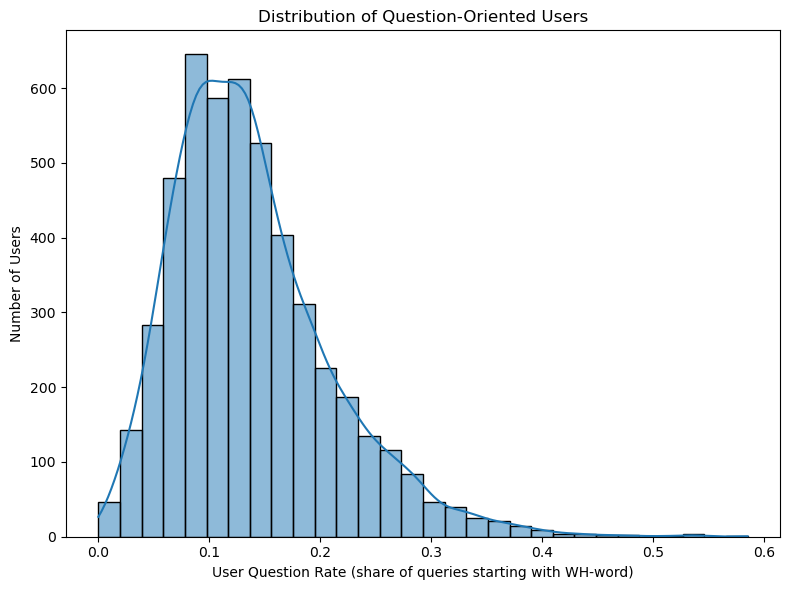

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df[['device_name_actual', 'user_question_rate']]
             .drop_duplicates()['user_question_rate'],
             bins=30, kde=True)
plt.xlabel("User Question Rate (share of queries starting with WH-word)")
plt.ylabel("Number of Users")
plt.title("Distribution of Question-Oriented Users")
plt.tight_layout()
plt.show()

**Key Findings**
- The distribution is right‑skewed and peaks around a question rate of roughly 0.1–0.15, meaning a typical user phrases only about 10–15% of their queries as explicit WH‑questions; most of what they type is statements or keyword queries rather than full questions.

- There is a long, thin tail stretching toward higher values (0.3–0.6), showing a much smaller group of users who rely heavily on question‑style queries, so these “question‑oriented” users are exceptions rather than the norm in the population.

#### (b) User Question Rate vs Total Query Volume

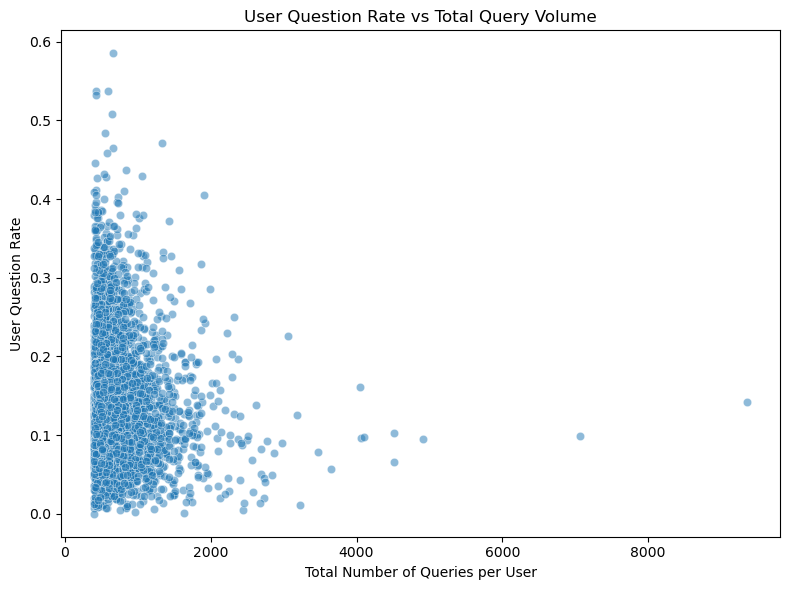

In [16]:
user_volume = (
    df.groupby('device_name_actual')['search_q']
      .count()
      .reset_index(name='num_queries')
)

user_level = user_volume.merge(
    df[['device_name_actual', 'user_question_rate']].drop_duplicates(),
    on='device_name_actual',
    how='left'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_level,
    x='num_queries',
    y='user_question_rate',
    alpha=0.5
)
plt.xlabel("Total Number of Queries per User")
plt.ylabel("User Question Rate")
plt.title("User Question Rate vs Total Query Volume")
plt.tight_layout()
plt.show()

**Key Findings**
- Most users, including many with high query volumes, cluster at relatively low question rates (typically below 0.2), indicating that even heavy users mostly submit non‑question or keyword‑style queries.
- There is no strong positive trend with volume; if anything, the highest question rates (above ~0.3–0.4) appear mostly among low‑ to medium‑volume users, suggesting that being a “power user” does not mean asking a higher proportion of explicit questions. Instead, high‑volume users tend to mix in many statement or navigational queries.

#### (c) Do Users with Longer Queries Ask More Questions

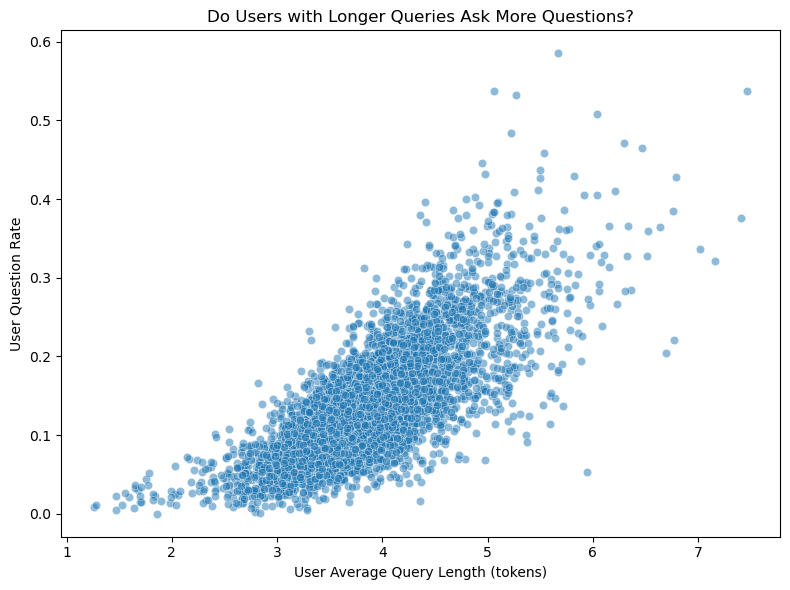

In [17]:
user_avg_len = (
    df.groupby('device_name_actual')['search_q']
      .apply(lambda s: s.str.split().str.len().mean())
      .reset_index(name='avg_query_len')
)

user_len_questions = user_avg_len.merge(
    df[['device_name_actual', 'user_question_rate']].drop_duplicates(),
    on='device_name_actual',
    how='left'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_len_questions,
    x='avg_query_len',
    y='user_question_rate',
    alpha=0.5
)
plt.xlabel("User Average Query Length (tokens)")
plt.ylabel("User Question Rate")
plt.title("Do Users with Longer Queries Ask More Questions?")
plt.tight_layout()
plt.show()


**Key Findings**
- Users with short average queries (around 2–3 tokens) tend to have very low question rates, often below 0.1, indicating that they mostly issue terse keyword or navigational queries rather than full questions.

- As average query length increases towards 5-7 tokens, the typical question rate rises steadily into the 0.2–0.4 range and higher, showing that users who write longer queries are much more likely to phrase them as explicit questions, and some of these long‑query users have more than half of their queries starting with a WH‑word.

#### (d) Question vs Non-Question Query Mix

**(i) For All Users**

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_12382/1947054054.py:5: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/tdf/Downloads/filtered_df_with_regex_final.csv")


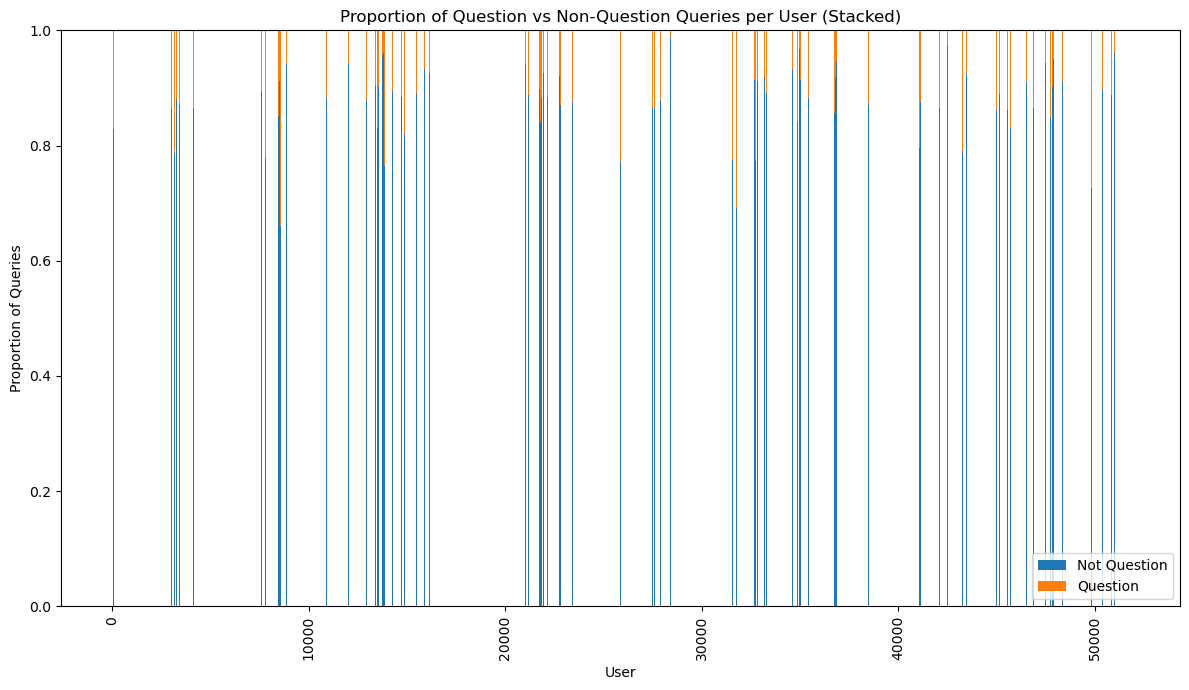

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataframe
df = pd.read_csv("/Users/tdf/Downloads/filtered_df_with_regex_final.csv")

# ---------------------------------------------
# 1. Compute counts of regex labels per user
# ---------------------------------------------
user_question_mix = (
    df.groupby(['device_name_actual', 'regex'])['search_q']
    .count()
    .reset_index(name='count')
)

# ---------------------------------------------
# 2. Pivot to wide format: columns = ['question', 'not_question']
# ---------------------------------------------
pivot_df = user_question_mix.pivot(
    index='device_name_actual',
    columns='regex',
    values='count'
).fillna(0)

# ---------------------------------------------
# 3. Convert counts to proportions
# ---------------------------------------------
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df['question_prop'] = pivot_df['question'] / pivot_df['total']
pivot_df['not_question_prop'] = pivot_df['not_question'] / pivot_df['total']

# ---------------------------------------------
# 4. Plot stacked bar chart
# ---------------------------------------------
plt.figure(figsize=(12, 7))

plt.bar(pivot_df.index, pivot_df['not_question_prop'], label='Not Question')
plt.bar(
    pivot_df.index,
    pivot_df['question_prop'],
    bottom=pivot_df['not_question_prop'],
    label='Question'
)

plt.xticks(rotation=90)
plt.ylabel("Proportion of Queries")
plt.xlabel("User")
plt.title("Proportion of Question vs Non-Question Queries per User (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()


**(ii) For Top 30 Users**

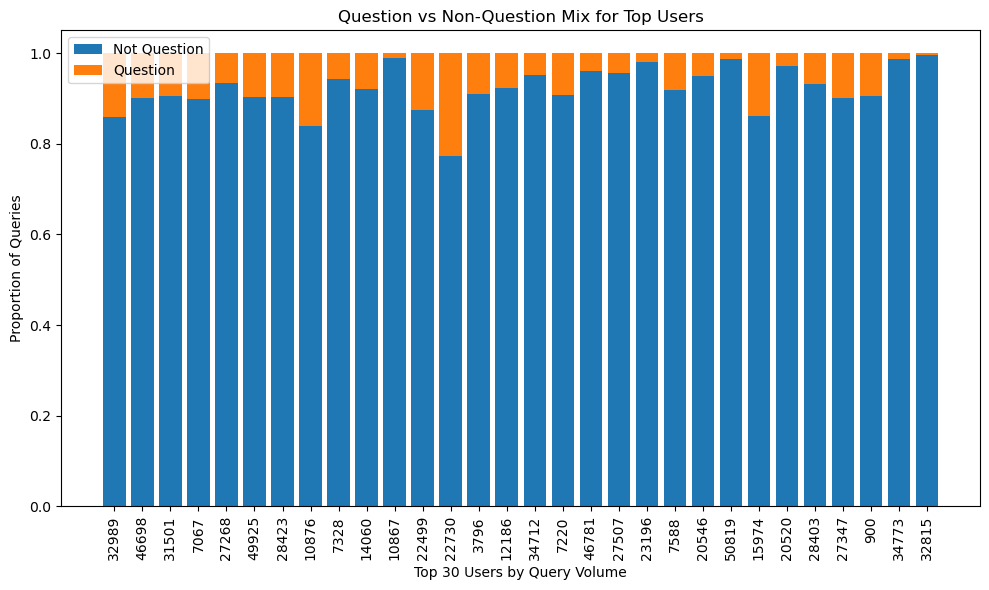

In [22]:
import numpy as np

# Use the pivot_df you already computed
pivot_df = pivot_df.copy()
pivot_df_sorted = pivot_df.sort_values('total', ascending=False).head(30)

x = np.arange(len(pivot_df_sorted))

plt.figure(figsize=(10, 6))
plt.bar(x, pivot_df_sorted['not_question_prop'], label='Not Question')
plt.bar(
    x,
    pivot_df_sorted['question_prop'],
    bottom=pivot_df_sorted['not_question_prop'],
    label='Question'
)

plt.xticks(x, pivot_df_sorted.index.astype(str), rotation=90)
plt.ylabel("Proportion of Queries")
plt.xlabel("Top 30 Users by Query Volume")
plt.title("Question vs Non-Question Mix for Top Users")
plt.legend()
plt.tight_layout()
plt.show()


**Key Findings**
- For almost all top users, non‑question queries dominate: the blue segments occupy around 80–100% of each bar, showing that even the heaviest users primarily submit keyword or navigational queries rather than explicit WH‑questions.

- Only a few top users have a noticeable orange segment (question proportion above roughly 10–15%), indicating that strongly question‑oriented behaviour among the highest‑volume users is relatively rare; most power users behave similarly in terms of query type mix.


#### (e) User Segments by Question Rate

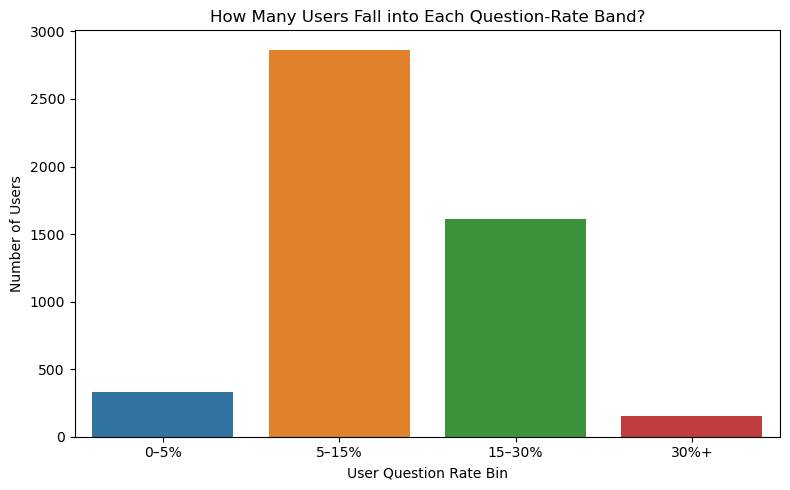

In [23]:
import seaborn as sns

pivot_df = pivot_df.copy()
pivot_df['question_bin'] = pd.cut(
    pivot_df['question_prop'],
    bins=[0, 0.05, 0.15, 0.3, 1.0],
    labels=['0–5%', '5–15%', '15–30%', '30%+']
)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=pivot_df.reset_index(),
    x='question_bin'
)
plt.xlabel("User Question Rate Bin")
plt.ylabel("Number of Users")
plt.title("How Many Users Fall into Each Question-Rate Band?")
plt.tight_layout()
plt.show()


- The majority of users fall into the 5–15% question‑rate band, meaning that for most individuals only a small fraction of their queries are explicit WH‑questions; they mainly issue non‑question or keyword queries.

- A substantial secondary group lies in the 15–30% band, while relatively few users are at the extremes (below 5% or above 30%), indicating that highly question‑averse and highly question‑oriented users both exist but are minority segments compared with the mid‑range behaviour.

## 5.2 Feature 2: Closure Detection

**Closure Detection**

The Closure feature identifies whether a user query is seeking clear closure or a close-ended answer, such as definitions, meanings, synonyms, or antonyms. Queries containing these cues often indicate that the user is looking for a precise explanation rather than exploring broadly. This helps differentiate between queries seeking concrete answers versus those that are exploratory or open-ended.

In our implementation, all queries are processed. A starter lexicon of keywords (`definition`, `meaning`, `synonym`, `opposite`, and `antonym`)is first defined. To capture semantically similar terms, this lexicon is expanded using embedding-based similarity against a sample of all queries. The resulting candidate words are optionally manually inspected to refine the lexicon.

Each query is then checked for the presence of any word in the final lexicon. Queries containing one or more of these words are flagged as "`closure`", while all others are flagged as "`not_closure`".

---

**Methods Used**

**(i)Starter Lexicon & Candidate Expansion**

- A small set of seed words is defined to capture closure-seeking queries.

- Using a lightweight sentence embedding model (all-MiniLM-L6-v2), each word in a sampled set of queries is embedded.

- Semantic similarity between the starter lexicon words and all unique query words is computed.

- Words exceeding a similarity threshold (e.g., 0.6) are selected as candidate neighbors.

- Optional manual inspection allows removal of irrelevant candidates before finalizing the lexicon.

**(ii) Query Label Assignment **
- Each query is scanned for any match with the final lexicon.
- Label "closure" is assigned if at least one word matches.
- Label "not_closure" is assigned otherwise.

---

**Example**
| Query                             | Matched Lexicon Word(s) | Label       |
| --------------------------------- | ----------------------- | ----------- |
| "arrangements meaning"            | meaning                 | closure     |
| "one term in Chinese"             | term                    | closure     |
| "hospital between 1959-1970"      | –                       | not_closure |
| "articles on man and environment" | –                       | not_closure |

| closure_label | count     |
| ------------- | --------- |
| not_closure   | 3,165,727 |
| closure       | 216,284   |



---
**Interpretation**
- Queries labeled "`closure`" indicate users are seeking precise, definitional, or close-ended answers.
- "`not_closure`" queries indicate exploratory or broader information-seeking behavior.

In [31]:
# ============================
# 1️⃣ Imports
# ============================
import pandas as pd
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
import os
from IPython.display import display

# ============================
# 2️⃣ Paths
# ============================
input_path = "/Users/tdf/Downloads/filtered_df_with_regex_final.csv"
candidate_output_path = "/Users/tdf/Downloads/candidate_neighbors.csv"
final_lexicon_csv = "/Users/tdf/Downloads/final_lexicon_full.csv"
final_output_path = "/Users/tdf/Downloads/filtered_df_with_closure_updated.csv"
manual_lexicon_path = "/Users/tdf/Downloads/final_lexicon_manual.csv"  # optional manual inspection
summary_output_path = "/Users/tdf/Downloads/closure_label_summary.csv"

# ============================
# 3️⃣ Starter lexicon
# ============================
starter_lexicon = ["definition", "meaning", "synonym", "opposite", "antonym"]
display(pd.DataFrame(starter_lexicon, columns=['starter_lexicon']))

# ============================
# 4️⃣ Load lightweight embedding model
# ============================
model = SentenceTransformer('all-MiniLM-L6-v2')  # memory-efficient

# ============================
# 5️⃣ Sample queries for lexicon expansion
# ============================
sample_size = 100_000  # adjust for memory
df_sample = pd.read_csv(input_path, usecols=['search_q']).sample(sample_size, random_state=42)
unique_words = pd.Series(' '.join(df_sample['search_q'].astype(str)).split()).unique()

# ============================
# 6️⃣ Embed lexicon and words
# ============================
lex_emb = model.encode(starter_lexicon, convert_to_tensor=True)
word_emb = model.encode(unique_words, convert_to_tensor=True)

# ============================
# 7️⃣ Find semantic neighbors
# ============================
threshold = 0.6
cos_scores = util.cos_sim(lex_emb, word_emb)
neighbors = set(unique_words[(cos_scores >= threshold).any(axis=0).cpu().numpy()])

# ============================
# 8️⃣ Save candidate neighbors for manual inspection
# ============================
candidate_neighbors = [w for w in neighbors if w not in starter_lexicon]
pd.DataFrame(candidate_neighbors, columns=['candidate_words']).to_csv(candidate_output_path, index=False)
display(pd.DataFrame({'message':[f"{len(candidate_neighbors)} candidate words saved to candidate_neighbors.csv. Open CSV to inspect or modify."]}))

# ============================
# 9️⃣ Load manually approved lexicon if it exists, else use all candidates
# ============================
if os.path.exists(manual_lexicon_path):
    manual_words = pd.read_csv(manual_lexicon_path)['candidate_words'].tolist()
    display(pd.DataFrame({'message':[f"Manual lexicon loaded with {len(manual_words)} words."]}))
else:
    manual_words = candidate_neighbors
    display(pd.DataFrame({'message':["Manual lexicon not found. Using all candidate neighbors by default."]}))

final_lexicon = starter_lexicon + manual_words

# ============================
# 🔹 Save full final lexicon
# ============================
pd.DataFrame(final_lexicon, columns=['final_lexicon']).to_csv(final_lexicon_csv, index=False)
display(pd.DataFrame(final_lexicon, columns=['final_lexicon']))  # display full lexicon

# ============================
# 1️⃣0️⃣ Compile regex and define function to capture matched words
# ============================
closure_pattern = re.compile(r'\b(' + '|'.join(final_lexicon) + r')\b', flags=re.IGNORECASE)

def classify_closure_with_words(query):
    query = str(query).strip()
    matches = closure_pattern.findall(query)
    if matches:
        return pd.Series(["closure", matches])
    else:
        return pd.Series(["not_closure", []])

# ============================
# 1️⃣1️⃣ Chunked processing for closure labeling
# ============================
chunk_size = 100_000  # adjust for memory
chunks = []

for chunk in tqdm(pd.read_csv(input_path, chunksize=chunk_size, low_memory=False), desc="Processing"):
    chunk[['closure', 'closure_words']] = chunk['search_q'].apply(classify_closure_with_words)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ============================
# 🔹 Save updated dataframe with closure labels and matched words
# ============================
df.to_csv(final_output_path, index=False)
display(pd.DataFrame({'message':[f"Updated dataframe with closure_words saved to {final_output_path}"]}))

# ============================
# 1️⃣2️⃣ Summary of closure labels
# ============================
summary = df['closure'].value_counts().reset_index()
summary.columns = ['closure_label', 'count']
display(summary)
summary.to_csv(summary_output_path, index=False)

# ============================
# 1️⃣3️⃣ Show example queries nicely
# ============================
display(df[df['closure']=='closure'][['search_q','closure_words']].head(10))
display(df[df['closure']=='not_closure'][['search_q','closure_words']].head(10))


starter_lexicon
0      definition
1         meaning
2         synonym
3        opposite
4         antonym

message
0  51 candidate words saved to candidate_neighbor...

message
0  Manual lexicon not found. Using all candidate ...

final_lexicon
0        definition
1           meaning
2           synonym
3          opposite
4           antonym
5           defined
6              term
7       terminology
8              mean
9         synonymps
10            slang
11         synonyme
12           means?
13         'synonym
14         膯meaning
15         剩meaning
16         meaning'
17        thesaurus
18        backwards
19       synonymous
20         壁meaning
21           upside
22         contrary
23         meaning?
24         synonymn
25         meaningn
26             noun
27         meaning\
28         reverses
29       oppositely
30         裨meaning
31           define
32         耸meaning
33         synonyms
34         劵meaning
35         瞻meaning
36       conversely
37          defines
38  merriam-webster
39         meanings
40      definitions
41          opposed
42         defining
43         antonyms
44       negatively
45          chiefly
46         synonymx
47          reverse
48         meaning]
49         synonym'
50         磨meaning
51            means
52          define:
53   interpretation
54         synonym#
55         reversed

Processing: 34it [04:50,  8.55s/it]


message
0  Updated dataframe with closure_words saved to ...

closure_label    count
0   not_closure  3165727
1       closure   216284

search_q closure_words
23           arrangements meaning     [meaning]
36            one term in chinese        [term]
55               hampered meaning     [meaning]
64               literacy meaning     [meaning]
67              blueprint meaning     [meaning]
70            agriculture meaning     [meaning]
71            cultivation meaning     [meaning]
72               economic meaning     [meaning]
73            communities meaning     [meaning]
76  agriculture expansion meaning     [meaning]

search_q closure_words
0                                      wy            []
1          hospital between 1959 and 1970            []
2        hospital between 1960s and 1970s            []
3                     hospital after 1965            []
4        hospital after 1965 in singapore            []
5                           anthropogenic            []
6                             terrestrial            []
7     articles on man and the environment            []
8  10 articles on man and the environment            []
9                          oops timetable            []

In [34]:
from IPython.display import display
import pandas as pd

# ------------------------------
# Candidate neighbors
# ------------------------------
num_candidates = len(candidate_neighbors)
print(f"Number of candidate neighbors: {num_candidates}")
display(pd.DataFrame(candidate_neighbors, columns=['candidate_neighbors']))

# ------------------------------
# Final lexicon
# ------------------------------
num_final = len(final_lexicon)
print(f"\nNumber of words in final lexicon: {num_final}")
display(pd.DataFrame(final_lexicon, columns=['final_lexicon']))


Number of candidate neighbors: 51


candidate_neighbors
0              defined
1                 term
2          terminology
3                 mean
4            synonymps
5                slang
6             synonyme
7               means?
8             'synonym
9             膯meaning
10            剩meaning
11            meaning'
12           thesaurus
13           backwards
14          synonymous
15            壁meaning
16              upside
17            contrary
18            meaning?
19            synonymn
20            meaningn
21                noun
22            meaning\
23            reverses
24          oppositely
25            裨meaning
26              define
27            耸meaning
28            synonyms
29            劵meaning
30            瞻meaning
31          conversely
32             defines
33     merriam-webster
34            meanings
35         definitions
36             opposed
37            defining
38            antonyms
39          negatively
40             chiefly
41            synonymx
42             reverse
43            meaning]
44            synonym'
45            磨meaning
46               means
47             define:
48      interpretation
49            synonym#
50            reversed


Number of words in final lexicon: 56


final_lexicon
0        definition
1           meaning
2           synonym
3          opposite
4           antonym
5           defined
6              term
7       terminology
8              mean
9         synonymps
10            slang
11         synonyme
12           means?
13         'synonym
14         膯meaning
15         剩meaning
16         meaning'
17        thesaurus
18        backwards
19       synonymous
20         壁meaning
21           upside
22         contrary
23         meaning?
24         synonymn
25         meaningn
26             noun
27         meaning\
28         reverses
29       oppositely
30         裨meaning
31           define
32         耸meaning
33         synonyms
34         劵meaning
35         瞻meaning
36       conversely
37          defines
38  merriam-webster
39         meanings
40      definitions
41          opposed
42         defining
43         antonyms
44       negatively
45          chiefly
46         synonymx
47          reverse
48         meaning]
49         synonym'
50         磨meaning
51            means
52          define:
53   interpretation
54         synonym#
55         reversed

In [32]:
df.head()

school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode         regex  \
0            True           False        1.0  not_question   
1            True           False        2.0  not_question   
2           False           False        2.0  not_question   
3           False           False        2.0  not_question   
4           False           False        2.0  not_question   

   user_question_rate      closure closure_words  
0            0.097917  not_closure            []  
1            0.097917  not_closure            []  
2            0.097917  not_closure            []  
3            0.097917  not_closure            []  
4            0.097917  not_closure            []

#### (a) Proportion of Closure Behaviour

**(i) Distribution of User-Level Closure Orientation**

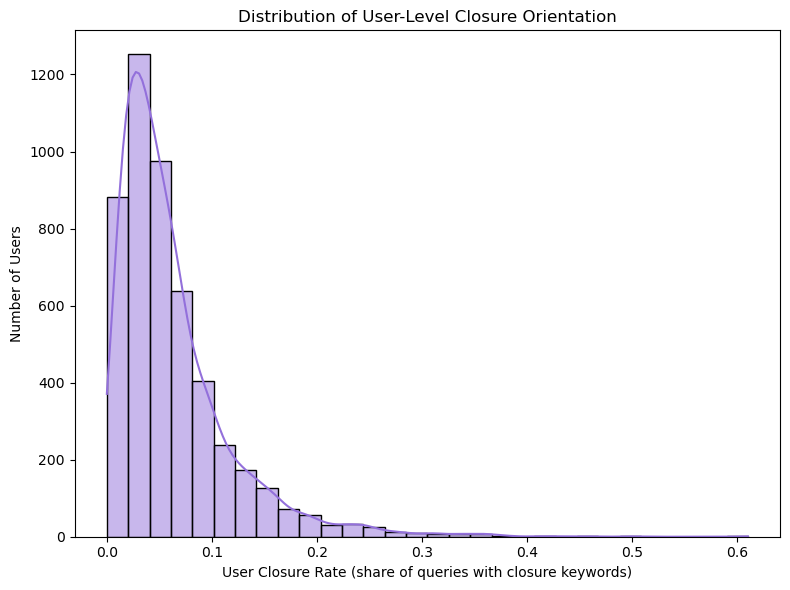

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# One row per user with share of closure queries
user_closure_rate = (
    df.groupby('device_name_actual')['closure']
      .apply(lambda s: (s == 'closure').mean())
      .reset_index(name='user_closure_rate')
)

plt.figure(figsize=(8, 6))
sns.histplot(
    data=user_closure_rate,
    x='user_closure_rate',
    bins=30,
    kde=True,
    color='mediumpurple'
)
plt.xlabel("User Closure Rate (share of queries with closure keywords)")
plt.ylabel("Number of Users")
plt.title("Distribution of User-Level Closure Orientation")
plt.tight_layout()
plt.show()


**Key Findings**
- The distribution is highly skewed toward zero: most users have a very low closure rate, meaning only a small fraction of their queries contain “definition/meaning/synonym/antonym” style keywords.

- A long, thin tail extends to the right, indicating a minority of users who rely heavily on closure queries; these “definition‑heavy” users are interesting edge cases compared with the broader population.


**(ii) Percentage of Users with Closure**

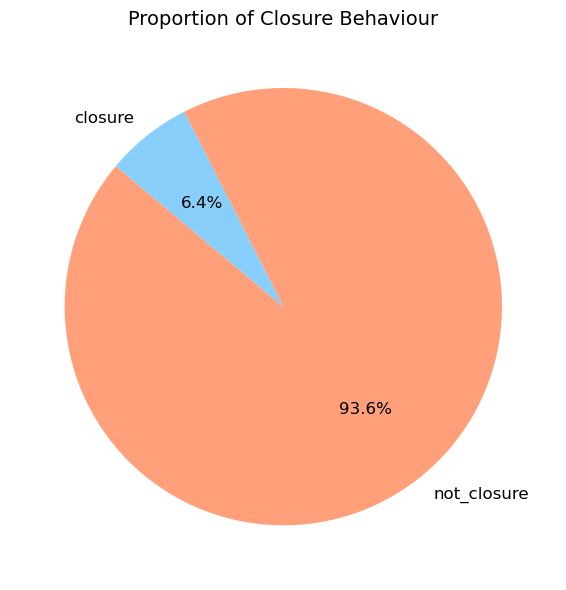

In [71]:
import matplotlib.pyplot as plt

# pastel colors
colors = ["#FFA07A", "#87CEFA"]  # pastel orange, pastel blue

plt.figure(figsize=(6,6))
plt.pie(
    summary["count"],
    labels=summary["closure_label"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    textprops={"fontsize": 12}
)
plt.title("Proportion of Closure Behaviour", fontsize=14)
plt.tight_layout()
plt.show()


**Key Findings**
- About 6.4% of all queries contain closure keywords like “definition”, “meaning”, “synonym”, or “antonym”, so they are explicitly asking for closed‑ended factual clarification.​

- The remaining 93.6% are “not_closure”, meaning most user interactions are exploratory or open‑ended rather than simple definition/lookup requests.

#### (b) Closure Keyword Usage for Top Closure Users

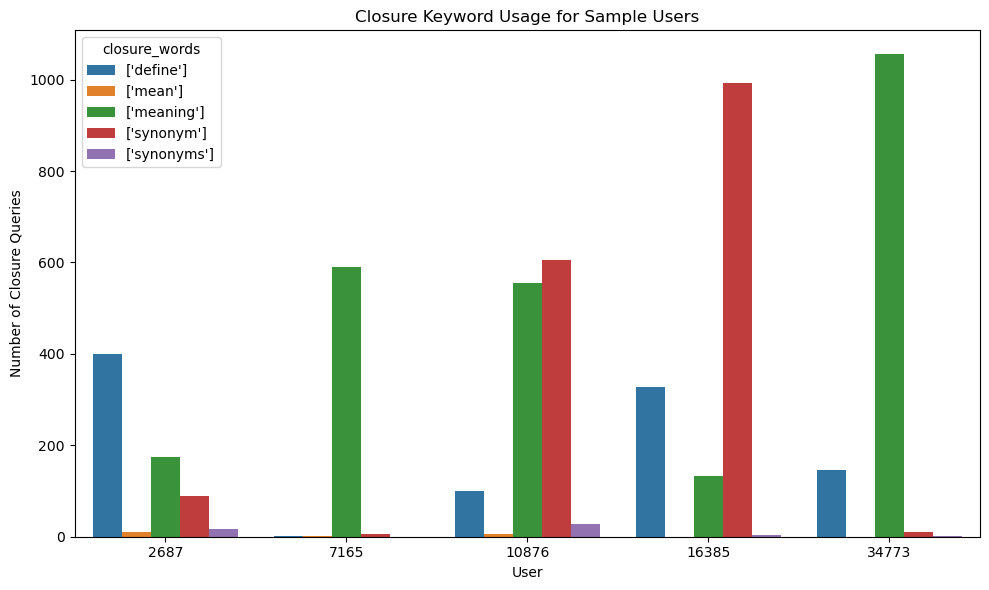

In [43]:
# explode closure_words list column into one word per row
closure_df = df[df['closure'] == 'closure'].copy()
closure_df = closure_df.explode('closure_words')
closure_df['closure_words'] = closure_df['closure_words'].str.lower()

# top closure words overall
top_words = (
    closure_df['closure_words']
    .value_counts()
    .head(5)
    .index
)

sample_users = closure_df['device_name_actual'].value_counts().head(5).index

user_word_mix = (
    closure_df[closure_df['device_name_actual'].isin(sample_users) &
               closure_df['closure_words'].isin(top_words)]
    .groupby(['device_name_actual', 'closure_words'])['search_q']
    .count()
    .reset_index(name='count')
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=user_word_mix,
    x='device_name_actual',
    y='count',
    hue='closure_words'
)
plt.xlabel("User")
plt.ylabel("Number of Closure Queries")
plt.title("Closure Keyword Usage for Sample Users")
plt.tight_layout()
plt.show()


**Key Findings**
- Each user on the x‑axis is among those with the highest number of closure queries, and the stacked colours show counts for keywords like “define”, “meaning”, and “synonym”.​

- The mix varies a lot by user: some are dominated by “meaning” lookups, others by “synonym”, while a few spread their closure queries more evenly, indicating distinct personal strategies for seeking definitional or lexical clarification.

#### (c) Top 15 Users/Devices by Closure‑Oriented Search Intensity

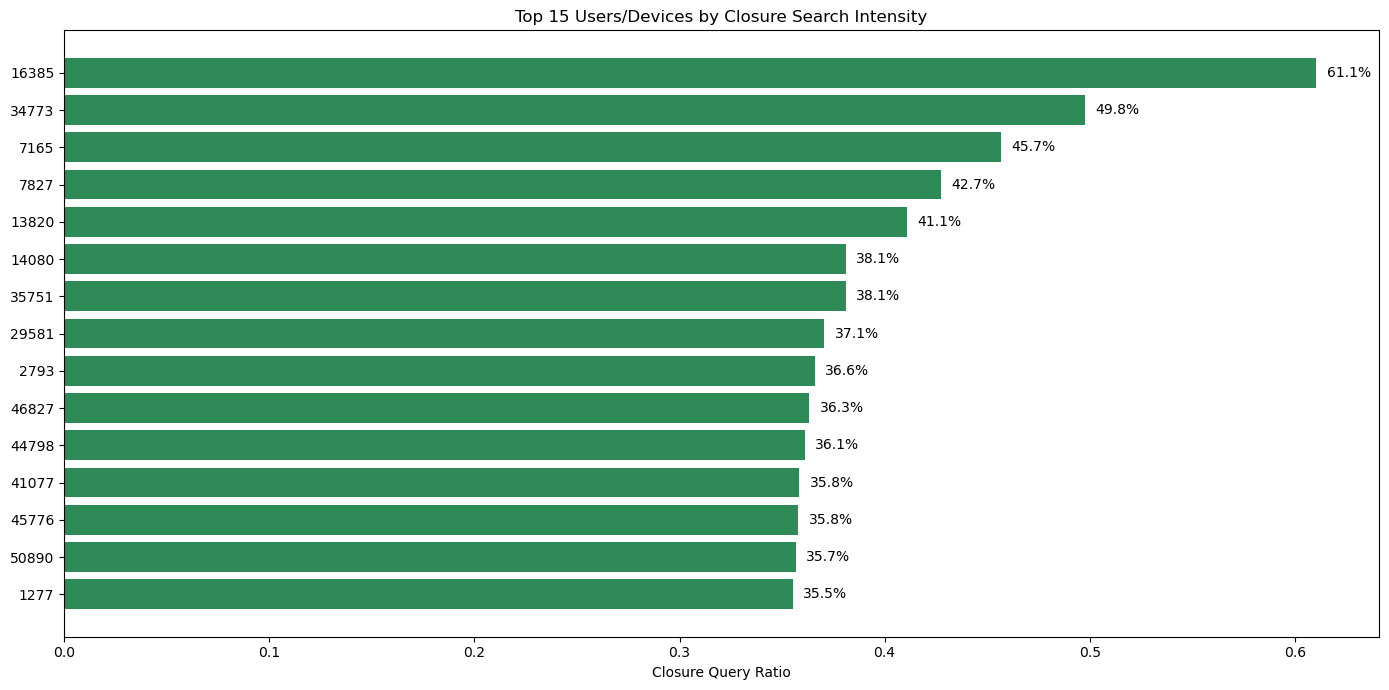

In [17]:
min_queries = 20  # filter out very small histories
user_counts = df.groupby(user_col).size()
valid_users = user_counts[user_counts >= min_queries].index

top_closure = user_closure_ratio.loc[valid_users].nlargest(15).sort_values()

plt.figure(figsize=(14,7))
bars = plt.barh(range(len(top_closure)), top_closure.values, color='seagreen')
plt.yticks(range(len(top_closure)), top_closure.index.astype(str))
plt.xlabel('Closure Query Ratio')
plt.title('Top 15 Users/Devices by Closure Search Intensity')
for i, v in enumerate(top_closure.values):
    plt.text(v + 0.005, i, f'{v:.1%}', va='center')
plt.tight_layout()
plt.show()

**Key Findings**
- The bar chart identifies a small group of users/devices whose behaviour is heavily dominated by closure‑type queries. The top profile reaches a closure query ratio of about 61%, and even the 15th profile still has roughly 36% of its searches labelled as closure, implying that more than one in three queries from these IDs are definition‑ or meaning‑oriented.​

- Compared with the overall population, where closure queries form only a small fraction of activity, these top 15 users/devices stand out as a distinct high‑closure segment. They likely represent intensive information‑seeking or learning‑oriented use cases, and could be prioritised for features such as richer explanations, glossary surfacing, or educational content, since a large share of their interactions already revolves around clarifying concepts.



#### (d) Dominant Lexical Signals of Closure Intent

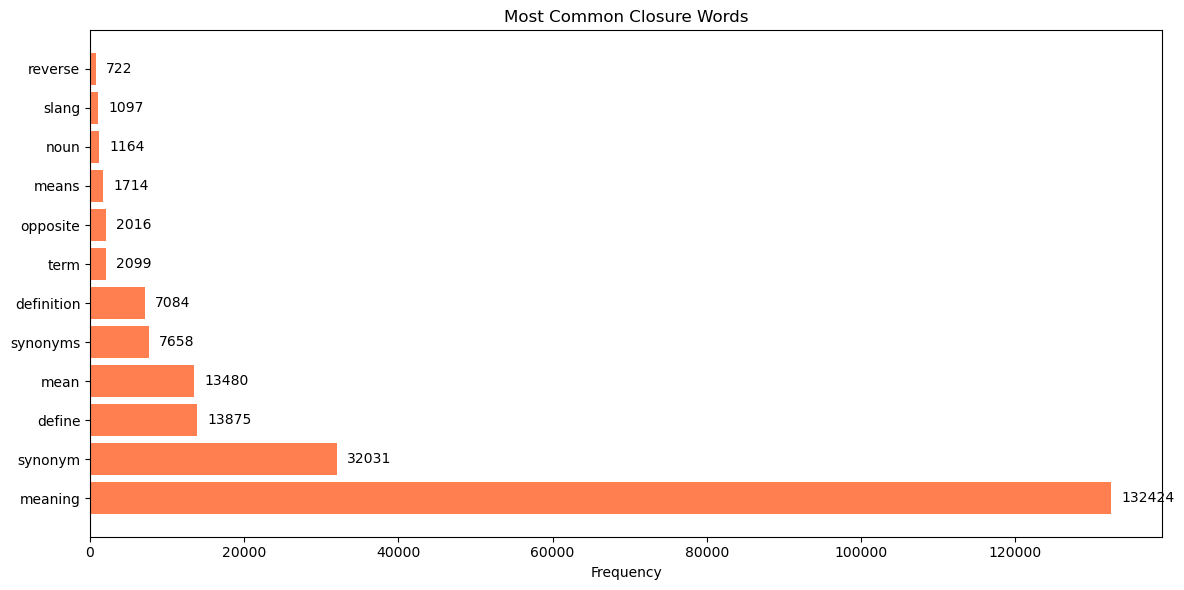

Top closure terms: ['meaning', 'synonym', 'define', 'mean', 'synonyms']


In [18]:
from collections import Counter
import ast

def to_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(str(x))
    except:
        return []

all_words = []
for w in df[df['closure']=='closure']['closure_words'].dropna():
    all_words.extend([str(t).lower() for t in to_list(w)])

word_freq = pd.Series(Counter(all_words)).sort_values(ascending=False).head(12)

plt.figure(figsize=(12,6))
bars = plt.barh(word_freq.index, word_freq.values, color='coral')
plt.xlabel('Frequency')
plt.title('Most Common Closure Words')
for i, v in enumerate(word_freq.values):
    plt.text(v + max(word_freq.values)*0.01, i, str(v), va='center')
plt.tight_layout()
plt.show()

print("Top closure terms:", list(word_freq.index[:5]))


**Key Findings**
- The bar chart shows that closure queries are driven by a small set of highly frequent lexical cues, with “meaning” by far the most dominant trigger. Its frequency is several times higher than any other term, indicating that users primarily express closure intent through direct formulations (eg. “what is the meaning of X”) rather than more indirect wording.​

- The next most common signals are “synonym”, “define”, and “mean”, followed by more specialised terms such as “definition”, “term”, “opposite”, “means”, and “slang”. This hierarchy suggests that closure behaviour is strongly oriented around semantic clarification (meaning and synonyms) rather than grammatical information (“noun”) or more nuanced relations (“reverse”, “slang”), which appear relatively rarely.



#### (e) Query Length Differences Between Closure & Non-Closure Searches

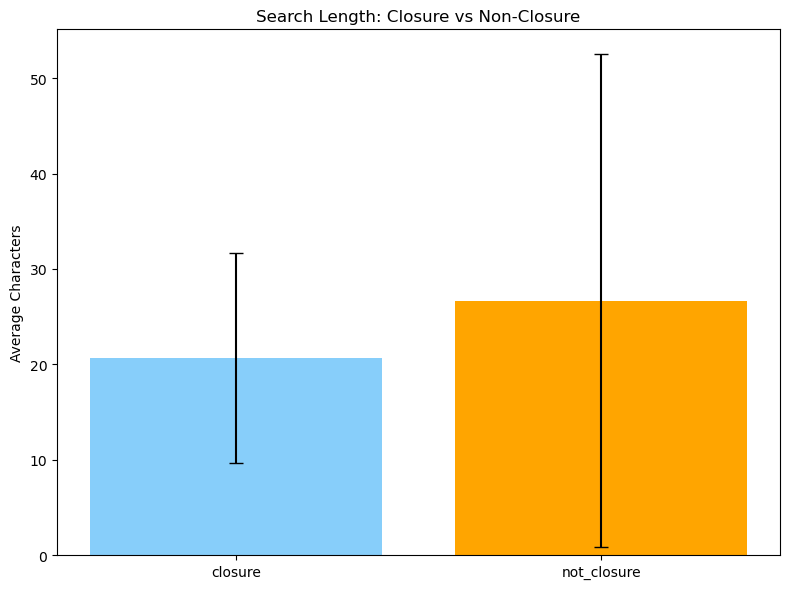

             mean   std
closure                
closure      20.7  11.0
not_closure  26.6  25.8


In [10]:
df['search_length'] = df['search_q'].astype(str).str.len()
agg = df.groupby('closure')['search_length'].agg(['mean','std'])

plt.figure(figsize=(8,6))
plt.bar(agg.index, agg['mean'], yerr=agg['std'], capsize=5,
        color=['lightskyblue','orange'])
plt.ylabel('Average Characters')
plt.title('Search Length: Closure vs Non‑Closure')
plt.tight_layout()
plt.show()

print(agg.round(1))


**Key Findings**
- The chart compares average character length for closure versus non‑closure queries, with error bars capturing variability. Closure queries are noticeably shorter, with an average of about 20.7 characters, whereas non‑closure queries average around 26.6 characters, indicating that definition‑style searches tend to be more concise.​

- The smaller standard deviation for closure queries (roughly 11 characters) versus non‑closure queries (about 25.8 characters) shows that closure queries are not only shorter but also more uniform in length. 

- This pattern is consistent with closure behaviour being dominated by compact, formulaic patterns such as “meaning of X” or “define X”, while non‑closure queries span a much broader range of lengths and structures.



#### (f) Summary of Individual Closure Behaviour Plots
**(i) Closure Rate vs Query Volume**

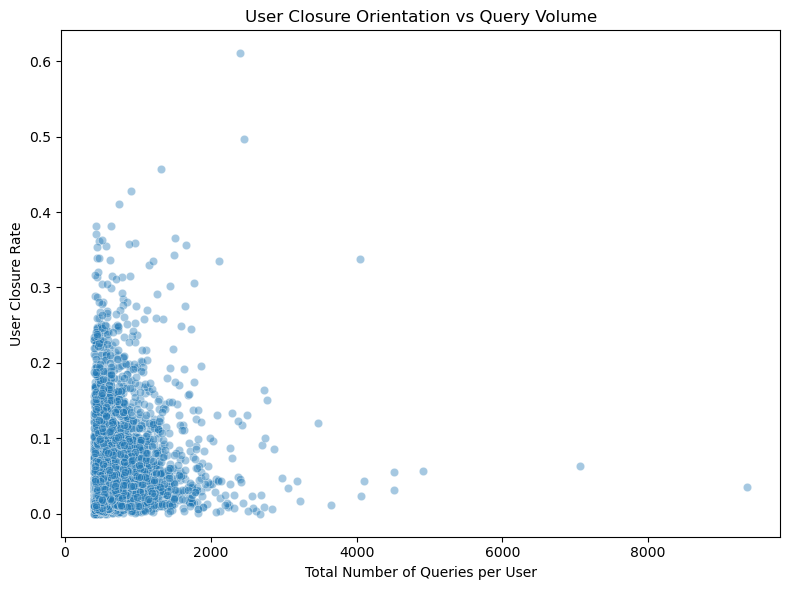

In [40]:
user_volume = (
    df.groupby('device_name_actual')['search_q']
      .count()
      .reset_index(name='num_queries')
)

user_closure_volume = user_volume.merge(
    user_closure_rate, on='device_name_actual', how='left'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_closure_volume,
    x='num_queries',
    y='user_closure_rate',
    alpha=0.4
)
plt.xlabel("Total Number of Queries per User")
plt.ylabel("User Closure Rate")
plt.title("User Closure Orientation vs Query Volume")
plt.tight_layout()
plt.show()


**Key Finding**
- Closure rate tends to be low for the very highest‑volume users, with higher closure ratios appearing mostly among users with moderate query volumes.​


**(ii) Closure Rate vs Question Orientation**

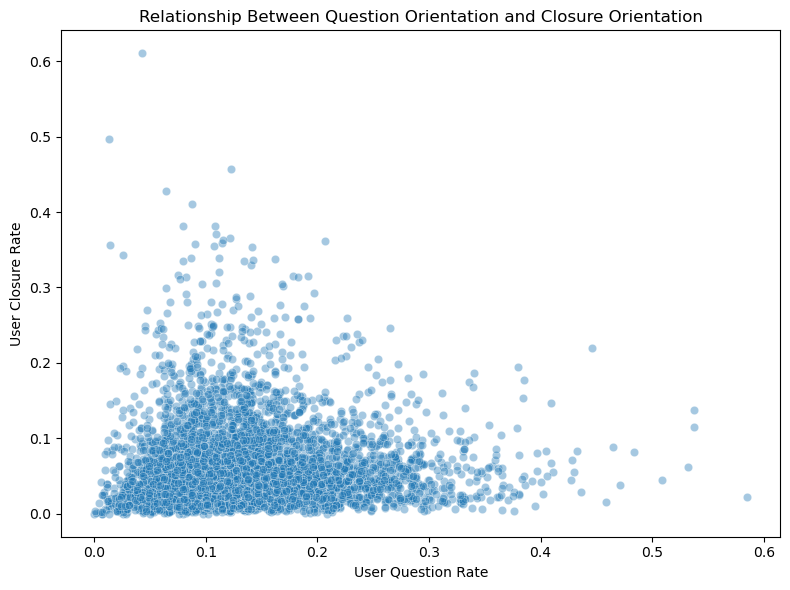

In [59]:
user_question_rate = (
    df_closure.groupby('device_name_actual')['regex']
              .apply(lambda s: (s == 'question').mean())
              .reset_index(name='user_question_rate')
)

user_q_closure = (
    user_closure_rate
    .merge(user_question_rate, on='device_name_actual', how='left')
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_q_closure,
    x='user_question_rate',
    y='user_closure_rate',
    alpha=0.4
)
plt.xlabel("User Question Rate")
plt.ylabel("User Closure Rate")
plt.title("Relationship Between Question Orientation and Closure Orientation")
plt.tight_layout()
plt.show()


**Key Finding**
- Users who frequently ask questions do not necessarily have high closure rates, and vice versa; “question orientation” and “closure orientation” behave as related but distinct dimensions of search style.​



**(iii) Closure Rate vs Semantics**

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_12382/1356918375.py:6: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sem = pd.read_csv("/Users/tdf/Downloads/filtered_df_semantic_diversity.csv")
/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_12382/1356918375.py:7: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_closure = pd.read_csv("/Users/tdf/Downloads/filtered_df_with_closure_updated.csv")


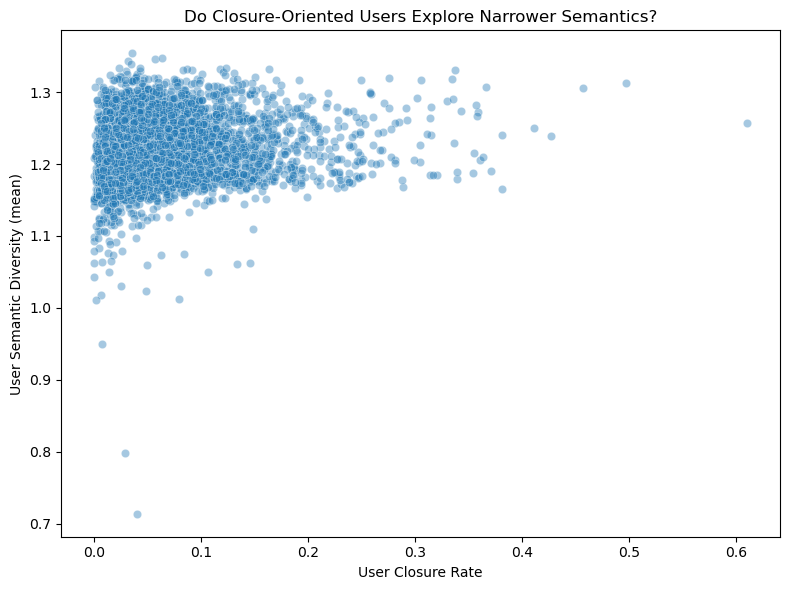

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load both dataframes
df_sem = pd.read_csv("/Users/tdf/Downloads/filtered_df_semantic_diversity.csv")
df_closure = pd.read_csv("/Users/tdf/Downloads/filtered_df_with_closure_updated.csv")

# 2. Keep only needed columns from each
df_sem_small = df_sem[
    ['device_name_actual', 'q_episode', 'search_q',
     'user_semantic_diversity_mean', 'user_semantic_diversity_var']
]

df_closure_small = df_closure[
    ['device_name_actual', 'q_episode', 'search_q',
     'closure', 'closure_words']
]

# 3. Merge on user + episode + query text
df_merged = df_sem_small.merge(
    df_closure_small,
    on=['device_name_actual', 'q_episode', 'search_q'],
    how='inner'
)

# 4. User-level closure rate
user_closure_rate = (
    df_merged.groupby('device_name_actual')['closure']
             .apply(lambda s: (s == 'closure').mean())
             .reset_index(name='user_closure_rate')
)

# 5. User-level semantic diversity (mean)
user_sem = df_merged[
    ['device_name_actual', 'user_semantic_diversity_mean']
].drop_duplicates()

# 6. Combine for plotting
user_closure_sem = user_closure_rate.merge(
    user_sem, on='device_name_actual', how='left'
)

# 7. Plot: closure rate vs semantic diversity
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_closure_sem,
    x='user_closure_rate',
    y='user_semantic_diversity_mean',
    alpha=0.4
)
plt.xlabel("User Closure Rate")
plt.ylabel("User Semantic Diversity (mean)")
plt.title("Do Closure-Oriented Users Explore Narrower Semantics?")
plt.tight_layout()
plt.show()


**Key Finding**
- Users with higher closure rates do not systematically explore narrower or broader semantic spaces; their average semantic diversity is similar to that of other users.

**(iv) Closure rate vs Vocabulary Richness**

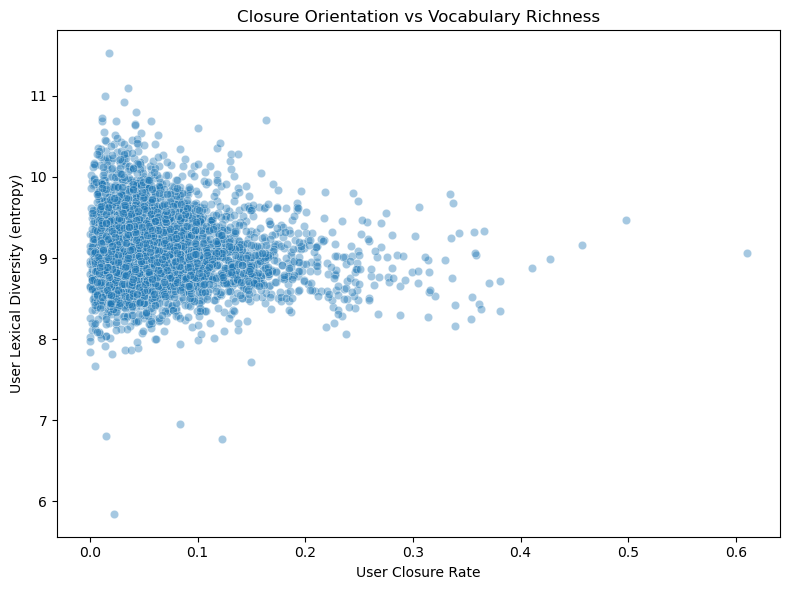

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. User-level lexical diversity from semantic file
user_lex = df_sem[
    ['device_name_actual', 'user_lexical_diversity']
].drop_duplicates()

# 2. Merge with user-level closure rate (from df_merged)
user_closure_lex = user_closure_rate.merge(
    user_lex, on='device_name_actual', how='left'
)

# 3. Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_closure_lex,
    x='user_closure_rate',
    y='user_lexical_diversity',
    alpha=0.4
)
plt.xlabel("User Closure Rate")
plt.ylabel("User Lexical Diversity (entropy)")
plt.title("Closure Orientation vs Vocabulary Richness")
plt.tight_layout()
plt.show()


**Key Finding**
- Vocabulary richness (lexical diversity) spans a wide range at low closure rates and narrows slightly at higher closure rates, but there is no sharp separation between closure‑light and closure‑heavy users.


**(v) Closure Rate vs Semantic Diversity Variance**

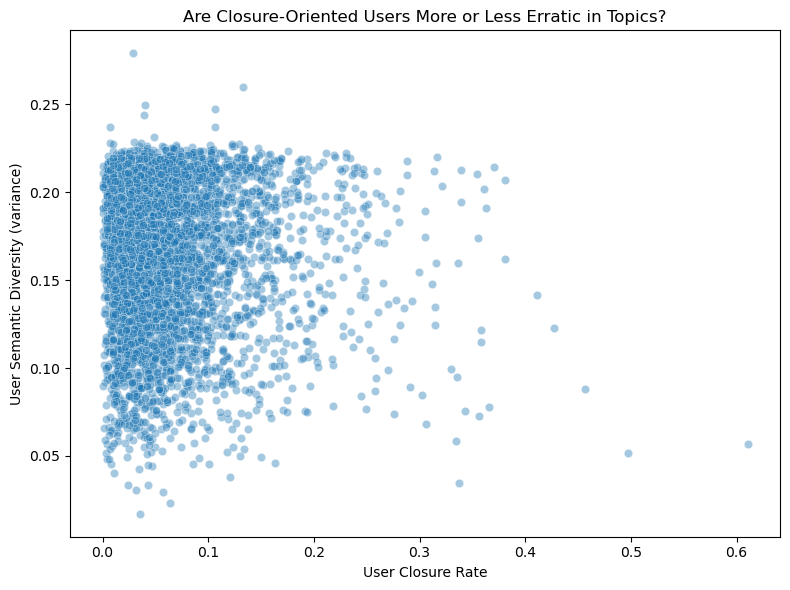

In [60]:
user_sem_var = df_merged[
    ['device_name_actual', 'user_semantic_diversity_var']
].drop_duplicates()

user_closure_var = user_closure_rate.merge(
    user_sem_var, on='device_name_actual', how='left'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_closure_var,
    x='user_closure_rate',
    y='user_semantic_diversity_var',
    alpha=0.4
)
plt.xlabel("User Closure Rate")
plt.ylabel("User Semantic Diversity (variance)")
plt.title("Are Closure-Oriented Users More or Less Erratic in Topics?")
plt.tight_layout()
plt.show()


**Key Finding**
- The variance of semantic diversity also does not change strongly with closure rate, indicating that closure‑heavy users are neither consistently more erratic nor more focused in how they move between topics.

**(vi) Closure Rate vs Average Length**

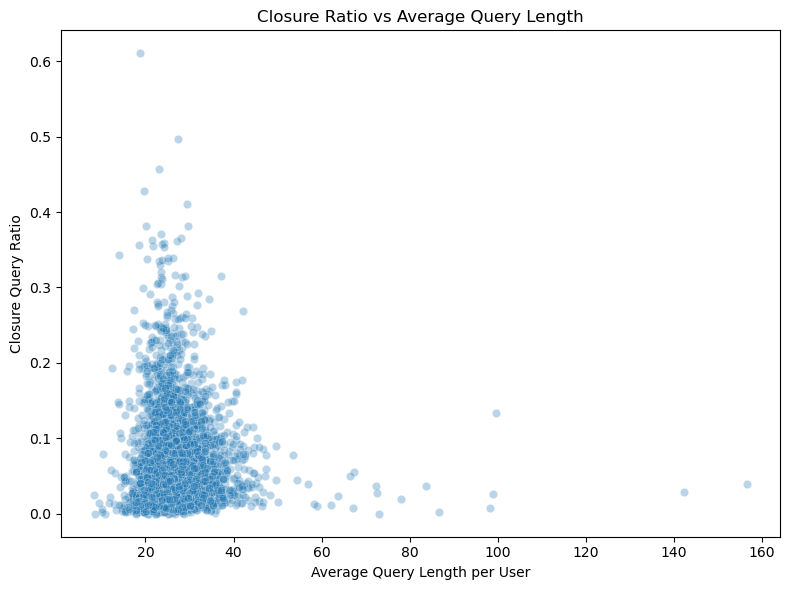

In [14]:
df['search_length'] = df['search_q'].astype(str).str.len()

user_len = df.groupby(user_col).agg(
    avg_len=('search_length','mean'),
    closure_ratio=('closure', lambda x: (x == 'closure').mean())
)

plt.figure(figsize=(8,6))
sns.scatterplot(data=user_len, x='avg_len', y='closure_ratio', alpha=0.3)
plt.xlabel('Average Query Length per User')
plt.ylabel('Closure Query Ratio')
plt.title('Closure Ratio vs Average Query Length')
plt.tight_layout()
plt.show()


**Key Finding**

- Average query length per user also shows no strong monotonic relationship with closure rate; closure‑oriented users live in the same length range as everyone else, with only a few very long‑query outliers.





## 5.3 Feature 3: Comparative Detection
**Comparative Detection**

The Comparative feature identifies whether a user query expresses a comparison. For example, asking which option is better, examining pros vs cons, or contrasting two items using “vs/versus”. Comparative cues often indicate that the user is evaluating alternatives rather than simply seeking information. This feature helps differentiate evaluative queries from descriptive ones.

In our implementation, all queries are processed using a hybrid lexicon–embedding expansion method. A small starter lexicon (eg. “`better`”, “`pros`”, “`versus`”, “`compare`”) is expanded via semantic similarity using a sentence-embedding model applied to real query text. The expanded lexicon is used to detect whether each query contains comparative intent.

---

**Methods Used**

**(i) Starter Lexicon & Embedding-Based Expansion**

- A small set of seed words is defined to capture comparison-seeking queries:
["better", "worse", "better than", "worse than",
 "pros", "cons", "advantages", "disadvantages",
 "vs", "versus", "compare", "comparison"]
- A random sample of up to 100,000 real queries is loaded.
- These queries are tokenized to build a unique vocabulary list (eg. “better”, “best”, “advantageous”, “compare”, “versus”, etc.).
- Using a lightweight embedding model (all-MiniLM-L6-v2), two things are encoded:
    - embeddings of the starter lexicon
    - embeddings of every unique word from sampled queries
- Compute cosine similarity between each starter word and each vocabulary word.
- Any vocabulary word with similarity ≥ threshold (default 0.58) is considered a candidate comparative term.
- This step expands the lexicon beyond literal matches. Examples of high-similarity neighbors might include:
    - “compare”, “comparison”, “comparing”
    - “versus”, “vs”, “v.s.”
    - “better”, “best”, “prefer”, “preference”

“advantages”, “benefits”, “pros”

**(ii) Query Label Assignment**
- The final lexicon is compiled into a case-insensitive regex. Word boundaries (\b) ensure exact phrase detection (e.g., “vs” does not match “version”).
---

**Example**
| Query                               | Matched Lexicon Word(s) | Label           |
| ----------------------------------- | ----------------------- | --------------- |
| “which is better iphone or samsung” | better                  | comparative     |
| “pros and cons of online shopping”  | pros, cons              | comparative     |
| “python list comprehension”         | –                       | not_comparative |
| “covid situation Singapore”         | –                       | not_comparative |


In [73]:
# ============================================================
# Comparative detection (lexicon + embedding expansion + chunked labeling)
# Input file: /Users/tdf/Downloads/filtered_df_with_closure_updated.csv
# ============================================================
import pandas as pd
import re
from tqdm import tqdm
import os
from IPython.display import display

# sentence-transformers import inside try/except so cell fails gracefully if not installed
try:
    from sentence_transformers import SentenceTransformer, util
except Exception as e:
    raise ImportError("sentence-transformers not available. Install with: pip install sentence-transformers") from e

# -----------------------
# PATHS (adjust if you want)
# -----------------------
input_path = "/Users/tdf/Downloads/filtered_df_with_closure_updated.csv"
comparative_candidate_path = "/Users/tdf/Downloads/comparative_candidate_neighbors.csv"
comparative_final_lexicon_path = "/Users/tdf/Downloads/comparative_final_lexicon.csv"
comparative_output_path = "/Users/tdf/Downloads/filtered_df_with_comparative.csv"
comparative_summary_path = "/Users/tdf/Downloads/comparative_label_summary.csv"
comparative_manual_path = "/Users/tdf/Downloads/comparative_manual_lexicon.csv"  # optional manual approval file

# -----------------------
# Starter lexicon (level 1)
# -----------------------
comparative_starter = [
    "better", "worse", "better than", "worse than",
    "pros", "cons", "advantages", "disadvantages",
    "vs", "versus", "compare", "comparison"
]
display(pd.DataFrame(comparative_starter, columns=['comparative_starter']))

# -----------------------
# Load/ensure embedding model
# -----------------------
# If 'model' is already in the notebook, reuse it to save time/memory
try:
    model  # check if exists
except NameError:
    model = SentenceTransformer('all-MiniLM-L6-v2')

# -----------------------
# Sample corpus for lexicon expansion (memory-safe)
# -----------------------
sample_size = 100_000
if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found: {input_path}")

df_sample = pd.read_csv(input_path, usecols=['search_q']).sample(min(sample_size, 100000), random_state=42)
unique_words = pd.Series(' '.join(df_sample['search_q'].astype(str)).split()).unique()

# -----------------------
# Embed starter and candidate words
# -----------------------
lex_emb = model.encode(comparative_starter, convert_to_tensor=True)
word_emb = model.encode(unique_words, convert_to_tensor=True)

# -----------------------
# Find semantic neighbors (tune threshold if needed)
# -----------------------
threshold = 0.58
cos_scores = util.cos_sim(lex_emb, word_emb)
neighbors_mask = (cos_scores >= threshold).any(axis=0).cpu().numpy()
neighbors = set(unique_words[neighbors_mask])

# -----------------------
# Save candidate neighbors (exclude starter)
# -----------------------
comparative_candidates = sorted([w for w in neighbors if w not in comparative_starter])
pd.DataFrame(comparative_candidates, columns=['candidate_words']).to_csv(comparative_candidate_path, index=False)
display(pd.DataFrame({'message':[f"{len(comparative_candidates)} comparative candidate words saved to {comparative_candidate_path}. Inspect and optionally edit {comparative_manual_path}"]}))

# -----------------------
# Load manual lexicon if available, otherwise use all candidates
# -----------------------
if os.path.exists(comparative_manual_path):
    manual_words = pd.read_csv(comparative_manual_path)['candidate_words'].dropna().astype(str).tolist()
    display(pd.DataFrame({'message':[f"Loaded manual comparative lexicon with {len(manual_words)} words."]}))
else:
    manual_words = comparative_candidates
    display(pd.DataFrame({'message':[f"No manual lexicon found. Using all {len(manual_words)} candidate neighbors by default."]}))

# Build final lexicon and save
comparative_final_lexicon = comparative_starter + manual_words
pd.DataFrame(comparative_final_lexicon, columns=['final_lexicon']).to_csv(comparative_final_lexicon_path, index=False)
display(pd.DataFrame(comparative_final_lexicon, columns=['final_lexicon']))

# -----------------------
# Compile regex (escape terms to be safe)
# -----------------------
# Use word-boundary based matching; phrases with spaces are handled literally.
pattern_tok = r'|'.join(re.escape(t) for t in comparative_final_lexicon)
comparative_pattern = re.compile(r'\b(' + pattern_tok + r')\b', flags=re.IGNORECASE)

def classify_comparative_with_words(query):
    q = str(query)
    matches = comparative_pattern.findall(q)
    if matches:
        # return unique lowercased matches for clarity
        uniq = list(dict.fromkeys([m.lower() for m in matches]))
        return pd.Series(["comparative", uniq])
    else:
        return pd.Series(["not_comparative", []])

# -----------------------
# Chunked labeling (memory-safe)
# -----------------------
chunk_size = 100_000
chunks = []
for chunk in tqdm(pd.read_csv(input_path, chunksize=chunk_size, low_memory=False), desc="Annotating comparative"):
    # ensure column exists
    if 'search_q' not in chunk.columns:
        chunk['search_q'] = ""
    chunk[['comparative', 'comparative_words']] = chunk['search_q'].apply(classify_comparative_with_words)
    chunks.append(chunk)

df_comp = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# -----------------------
# Save annotated dataframe and summary
# -----------------------
df_comp.to_csv(comparative_output_path, index=False)
display(pd.DataFrame({'message':[f"Comparative-labeled dataframe saved to {comparative_output_path}"]}))

summary = df_comp['comparative'].value_counts().reset_index()
summary.columns = ['comparative_label', 'count']
display(summary)
summary.to_csv(comparative_summary_path, index=False)

# -----------------------
# Show example rows (comparative / not_comparative)
# -----------------------
display(df_comp[df_comp['comparative']=='comparative'][['search_q','comparative_words']].head(10))
display(df_comp[df_comp['comparative']=='not_comparative'][['search_q','comparative_words']].head(10))


comparative_starter
0               better
1                worse
2          better than
3           worse than
4                 pros
5                 cons
6           advantages
7        disadvantages
8                   vs
9               versus
10             compare
11          comparison

message
0  67 comparative candidate words saved to /Users...

message
0  No manual lexicon found. Using all 67 candidat...

final_lexicon
0         better
1          worse
2    better than
3     worse than
4           pros
..           ...
74           vs.
75       whereas
76        worsen
77     worsening
78         worst

[79 rows x 1 columns]

Annotating comparative: 34it [06:14, 11.01s/it]


message
0  Comparative-labeled dataframe saved to /Users/...

comparative_label    count
0   not_comparative  3278467
1       comparative   103544

search_q  \
34   articles on advantages and disadvantages of th...   
75   why is making space an advantage of deforestation   
77   why is agriculture expansion an advantage of d...   
78   what is the advantages and disadvantages of de...   
95   advantages and disadvantages of ocean acidific...   
105     what are the advantages of ocean acidification   
106     does seagrass benefit from ocean acidification   
175         difference authoritarian and authoritative   
179                                        contrasting   
227  is strawberry milk healthier than full cream milk   

               comparative_words  
34   [advantages, disadvantages]  
75                   [advantage]  
77                   [advantage]  
78   [advantages, disadvantages]  
95   [advantages, disadvantages]  
105                 [advantages]  
106                    [benefit]  
175                 [difference]  
179                [contrasting]  
227                       [than]

search_q comparative_words
0                                      wy                []
1          hospital between 1959 and 1970                []
2        hospital between 1960s and 1970s                []
3                     hospital after 1965                []
4        hospital after 1965 in singapore                []
5                           anthropogenic                []
6                             terrestrial                []
7     articles on man and the environment                []
8  10 articles on man and the environment                []
9                          oops timetable                []

In [77]:
from IPython.display import display
import pandas as pd

# ------------------------------
# Candidate neighbors
# ------------------------------
num_candidates = len(comparative_candidates)  # list of candidate neighbors from semantic expansion
print(f"Number of candidate neighbors: {num_candidates}")
display(pd.DataFrame(comparative_candidates, columns=['candidate_neighbors']))

# ------------------------------
# Final lexicon
# ------------------------------
num_final = len(comparative_final_lexicon)  # starter lexicon + manually approved candidates
print(f"\nNumber of words in final lexicon: {num_final}")
display(pd.DataFrame(comparative_final_lexicon, columns=['final_lexicon']))


Number of candidate neighbors: 67


candidate_neighbors
0                'best
1            advantage
2                alike
3                awful
4                  bad
..                 ...
62                 vs.
63             whereas
64              worsen
65           worsening
66               worst

[67 rows x 1 columns]


Number of words in final lexicon: 79


final_lexicon
0         better
1          worse
2    better than
3     worse than
4           pros
..           ...
74           vs.
75       whereas
76        worsen
77     worsening
78         worst

[79 rows x 1 columns]

#### (a) Individual Comparative Search Behaviour

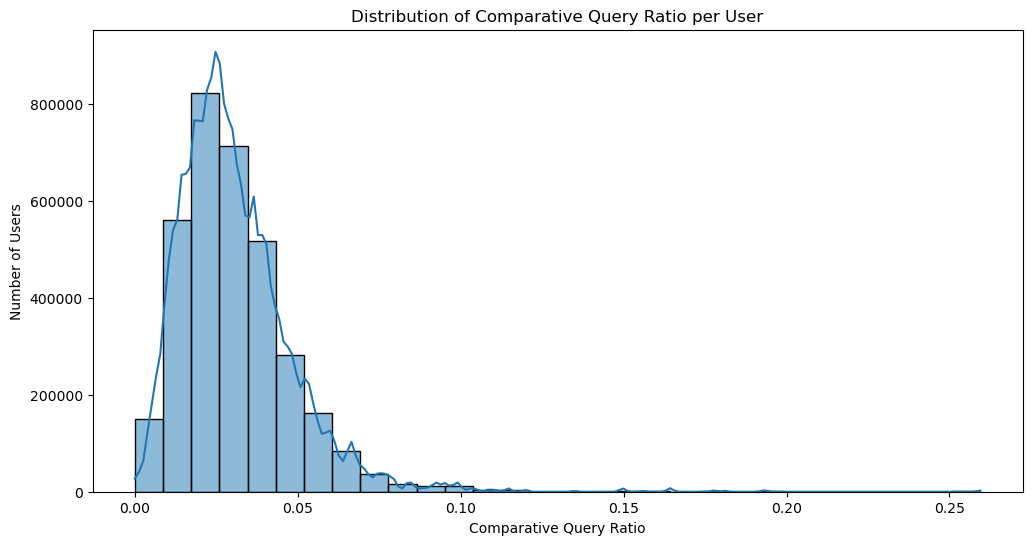

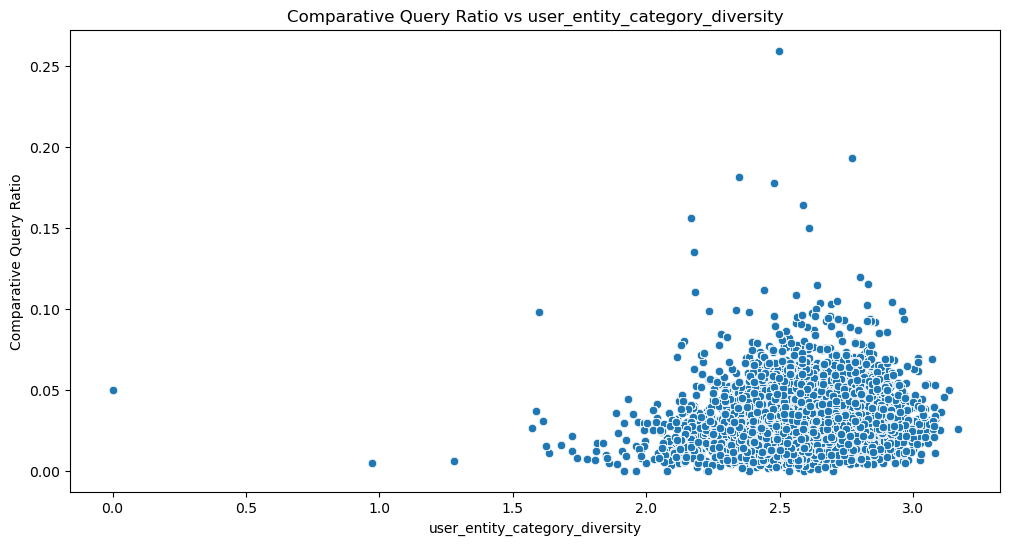

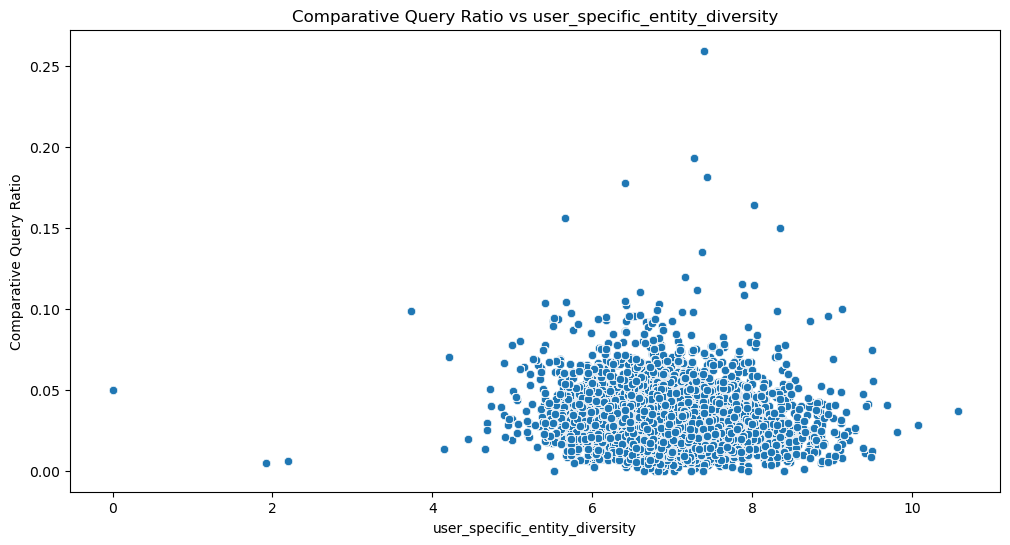

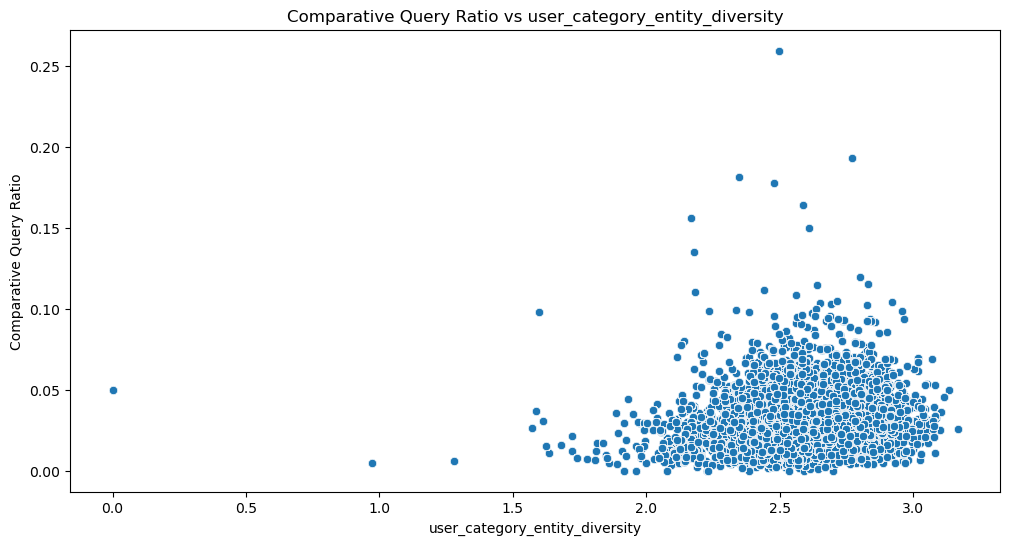

In [1]:
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# PATHS
# -----------------------
comparative_file = "/Users/tdf/Downloads/filtered_df_with_comparative.csv"
previous_features_file = "/Users/tdf/Downloads/filtered_df_with_entity_diversity_full.csv"

# -----------------------
# Load previous features
# -----------------------
if os.path.exists(previous_features_file):
    df_prev = pd.read_csv(previous_features_file, usecols=['device_name_actual','user_entity_category_diversity',
                                                          'user_specific_entity_diversity','user_category_entity_diversity'])
else:
    df_prev = pd.DataFrame()

# -----------------------
# Chunked processing
# -----------------------
chunk_size = 100_000
user_counts = defaultdict(lambda: {"comparative":0, "not_comparative":0})

for chunk in pd.read_csv(comparative_file, chunksize=chunk_size, usecols=['device_name_actual','comparative']):
    for user, grp in chunk.groupby('device_name_actual'):
        counts = grp['comparative'].value_counts()
        user_counts[user]['comparative'] += counts.get('comparative',0)
        user_counts[user]['not_comparative'] += counts.get('not_comparative',0)

# -----------------------
# Convert to DataFrame
# -----------------------
user_df = pd.DataFrame.from_dict(user_counts, orient='index').reset_index().rename(columns={'index':'device_name_actual'})
user_df['total_queries'] = user_df['comparative'] + user_df['not_comparative']
user_df['comparative_ratio'] = user_df['comparative'] / user_df['total_queries']

# Merge previous features
if not df_prev.empty:
    user_df = user_df.merge(df_prev, on='device_name_actual', how='left')

# -----------------------
# Plot: comparative ratio distribution
# -----------------------
plt.figure(figsize=(12,6))
sns.histplot(user_df['comparative_ratio'], bins=30, kde=True)
plt.title("Distribution of Comparative Query Ratio per User")
plt.xlabel("Comparative Query Ratio")
plt.ylabel("Number of Users")
plt.show()

# -----------------------
# Scatter: comparative ratio vs diversity metrics
# -----------------------
for col in ['user_entity_category_diversity','user_specific_entity_diversity','user_category_entity_diversity']:
    if col in user_df.columns:
        plt.figure(figsize=(12,6))
        sns.scatterplot(data=user_df, x=col, y='comparative_ratio')
        plt.title(f"Comparative Query Ratio vs {col}")
        plt.xlabel(col)
        plt.ylabel("Comparative Query Ratio")
        plt.show()


**Key Findings**
- Across users, the comparative query ratio is very low and tightly concentrated between roughly 1–5%, indicating that most people only occasionally issue comparison-type queries rather than behaving as “heavy comparers”. A long right tail is present, but only a very small minority of users ever reach double‑digit comparative ratios, highlighting that strongly comparison‑driven behaviour is rare.​

- The relationship between comparative query ratio and user_specific_entity_diversity is weak, with points forming a dense cloud at low comparative ratios across the full diversity range. This suggests that simply searching a wider variety of specific entities does not strongly increase a user’s propensity to ask comparative questions.​

- Similarly, user_entity_category_diversity shows only a mild positive association with comparative ratio, where higher category diversity coincides with slightly more comparative behaviour but still at low absolute levels. This implies that exploring more categories broadens activity but does not fundamentally change the fact that comparisons remain a small share of queries.​

- The user_category_entity_diversity plot replicates this pattern, with broadly similar clouds and only a small subset of users combining high diversity with noticeably higher comparative ratios. 

- Taken together, the three diversity plots support a robust conclusion: comparative searches are a niche behaviour that does not strongly scale with how diverse a user’s browsing or entity exposure is.

#### (b) Overall Prevalence of Comparative Searches


/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_28210/4088425219.py:6: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_comparative.csv')


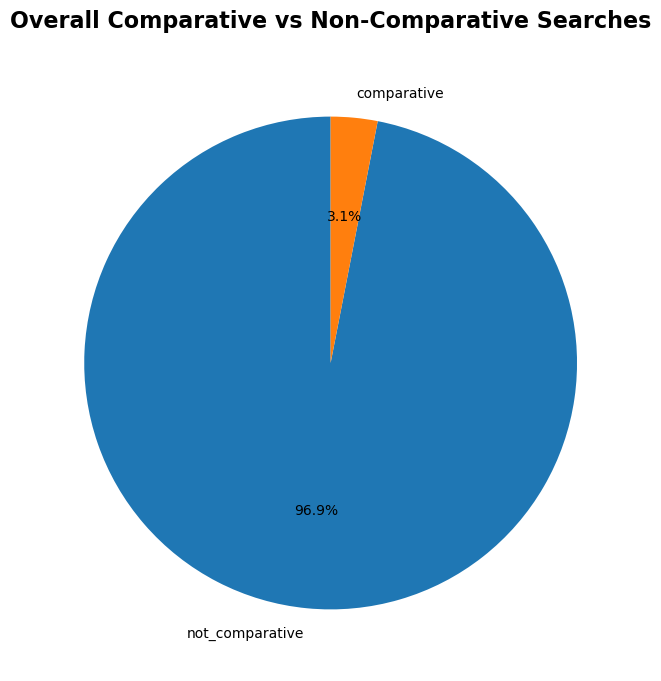

Comparative: 3.1% of total searches


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_comparative.csv')
plt.figure(figsize=(10, 8))
comparative_dist = df['comparative'].value_counts()
plt.pie(comparative_dist.values, labels=comparative_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Overall Comparative vs Non-Comparative Searches', fontsize=16, fontweight='bold', pad=20)
plt.show()
print(f"Comparative: {comparative_dist['comparative']/len(df)*100:.1f}% of total searches")


**Key Findings**
- The pie chart shows that only about 3% of all queries are classified as comparative, while the remaining 97% are non‑comparative. This indicates that comparison‑oriented intent (for example “A vs B” or “better than”) is a relatively rare behaviour at the query level, even though it may be strategically important for purchase decisions.​

- The dominance of the non‑comparative segment implies that most user interactions with search are focused on single products, information lookup, or navigational intents rather than explicit side‑by‑side evaluation. In the context of the other plots, this chart sets the baseline: comparative queries are a small but distinct slice of total demand that is worth analysing separately because it likely captures high‑intent evaluation moments

#### (c) Comparative Search Intensity of Top 15 Devices

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_28210/454378741.py:5: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_comparative.csv')


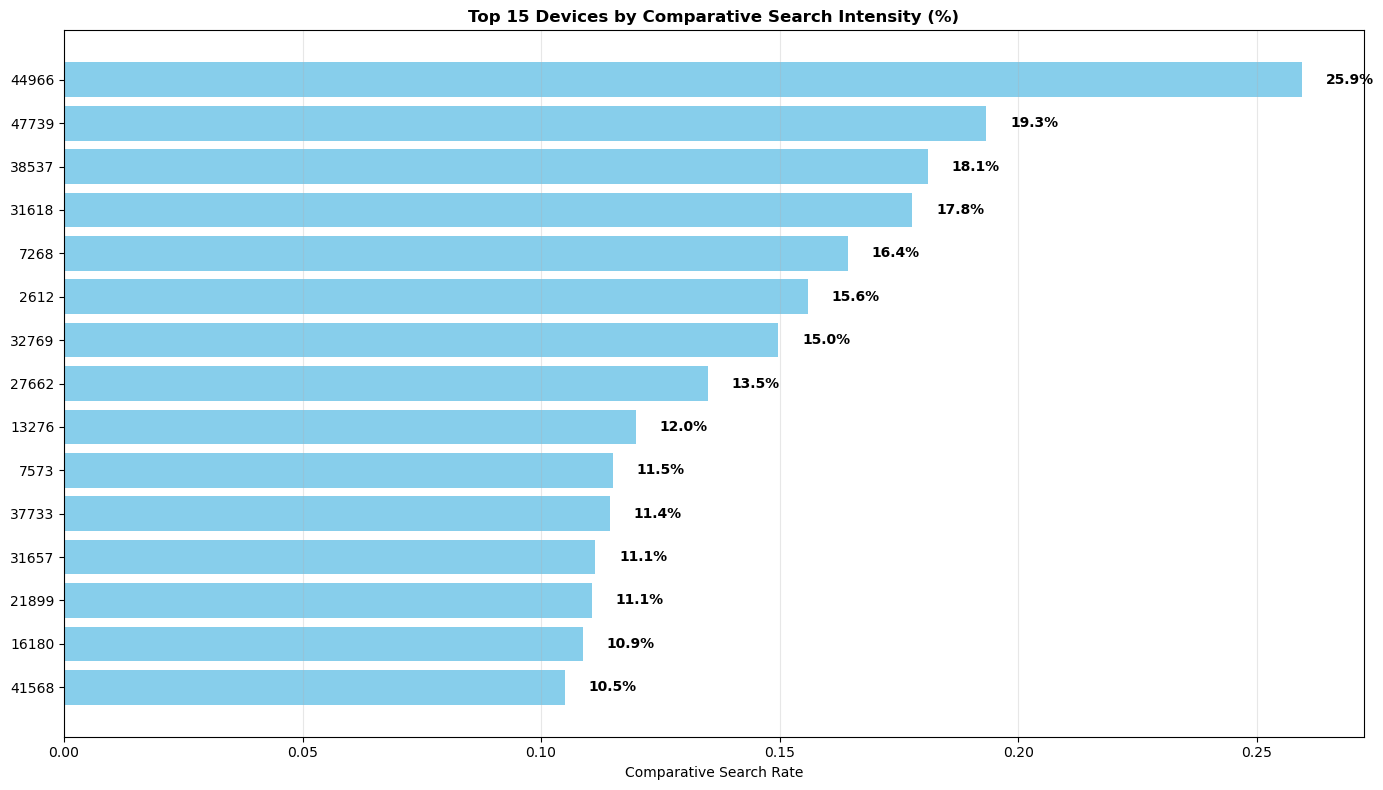

Most comparative device: 41568 (25.9%)
Total devices analyzed: 4961

Top 5 devices:
device_name_actual
41568    0.105
16180    0.109
21899    0.111
31657    0.111
37733    0.114
dtype: float64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload df to ensure we have fresh data
df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_comparative.csv')

# Use device_name_actual as user proxy
device_col = 'device_name_actual'
if device_col in df.columns:
    device_comp_rate = df[df['comparative']=='comparative'].groupby(device_col).size() / df.groupby(device_col).size()
    top_devices = device_comp_rate.nlargest(15).sort_values(ascending=True)
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(range(len(top_devices)), top_devices.values, color='skyblue')
    plt.yticks(range(len(top_devices)), top_devices.index)
    plt.xlabel('Comparative Search Rate')
    plt.title('Top 15 Devices by Comparative Search Intensity (%)', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, top_devices.values)):
        plt.text(v + 0.005, i, f'{v:.1%}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Most comparative device: {top_devices.index[0]} ({top_devices.max():.1%})")
    print(f"Total devices analyzed: {len(device_comp_rate)}")
    print("\nTop 5 devices:")
    print(top_devices.head().round(3))
    
else:
    print(f"No '{device_col}' column found.")
    print("Available columns with 'device':", [c for c in df.columns if 'device' in c.lower()])



**Key Findings**
- The analysis of device-level behaviour shows a small set of devices with markedly higher comparative search intensity than the overall population. The leading device records comparative queries in approximately 26% of its searches, while the remaining devices in the top 15 cluster between 10% and 20%. This stands in clear contrast to the global baseline of roughly 3% comparative queries, indicating that these devices constitute distinct outliers where comparison is a central, rather than incidental, part of the search journey.

- Within this group, the top five devices (IDs 41568, 16180, 21899, 31657, 37733) all exhibit comparative search ratios of around 10–11%, implying that roughly one in every ten queries from these devices is explicitly comparative. This level of activity represents three to four times the average comparative intensity and suggests the presence of high-intent evaluators or “power users” who are systematically engaging in product comparison. These devices form a meaningful segment that may warrant targeted investigation or tailored experiences, for example through enhanced comparison tools or decision-support content.



#### (d) Language Patterns in Comparative Queries

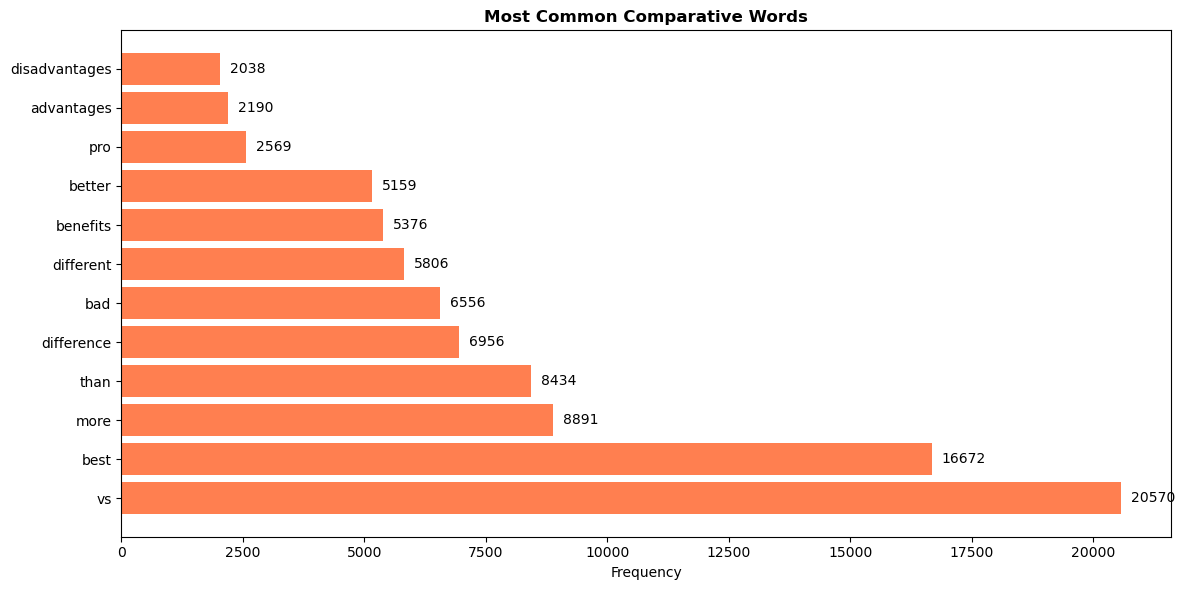

Top 3 words: ['vs', 'best', 'more']


In [4]:
plt.figure(figsize=(12, 6))
all_comp_words = []
for words in df[df['comparative']=='comparative']['comparative_words'].dropna():
    try:
        all_comp_words.extend(eval(words))
    except:
        all_comp_words.append(words)
word_freq = pd.Series(Counter([w.lower() for w in all_comp_words])).nlargest(12)
bars = plt.barh(range(len(word_freq)), word_freq.values, color='coral')
plt.yticks(range(len(word_freq)), word_freq.index)
plt.xlabel('Frequency')
plt.title('Most Common Comparative Words', fontweight='bold')
for i, (bar, v) in enumerate(zip(bars, word_freq.values)):
    plt.text(v + max(word_freq.values)*0.01, i, str(v), va='center')
plt.tight_layout()
plt.show()
print(f"Top 3 words: {list(word_freq.index[:3])}")


**Key Findings**
- The distribution of comparative terms shows that a small set of keywords dominates how users express comparison intent. The three most frequent terms are “vs”, “best”, and “more”, each occurring substantially more often than other words such as “than”, “difference”, or “better”.​

- This pattern indicates that most comparative behaviour is framed either as direct product‑to‑product comparisons (“vs”) or as searches for optimisation (“best”, “more”) rather than explicit evaluations of pros and cons. Less frequent use of terms like “advantages” and “disadvantages” suggests that users rarely articulate comparisons in fully verbalised review language, instead relying on concise triggers that can be effectively captured by a compact lexicon.



#### (e) Heatmap of Comparative Queries and Closure

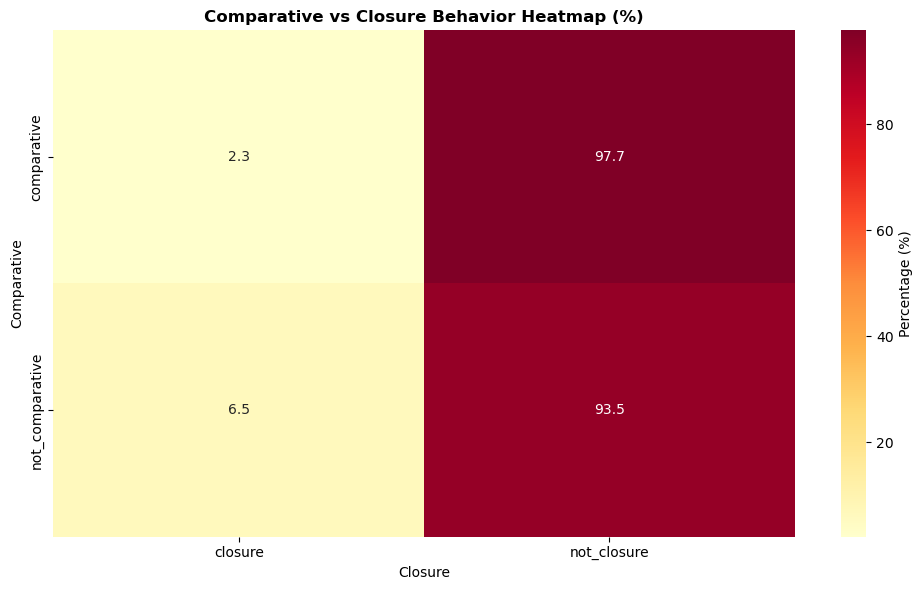

Heatmap shows closure-comparative relationships


In [5]:
if 'closure' in df.columns:
    plt.figure(figsize=(10, 6))
    crosstab = pd.crosstab(df['comparative'], df['closure'], normalize='index') * 100
    sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'})
    plt.title('Comparative vs Closure Behavior Heatmap (%)', fontweight='bold')
    plt.ylabel('Comparative')
    plt.xlabel('Closure')
    plt.tight_layout()
    plt.show()
    print("Heatmap shows closure-comparative relationships")
else:
    print("No 'closure' column. Available:", [c for c in df.columns if 'clos' in c.lower()])


**Key Findings**
- The heatmap compares the share of queries that lead to closure for comparative versus non‑comparative searches. Among comparative queries, only about 2-3% are labelled as closure, while roughly 98% are non‑closure, indicating that explicit comparison intent rarely coincides with immediate closing behaviour.​

- For non‑comparative queries, the closure rate is slightly higher (around 6-7%), with more than 90% still falling into the non‑closure category. Overall, this suggests that while non‑comparative queries are somewhat more likely to be associated with closure, most closure events do not arise directly from the comparative moments themselves, but rather from other types of follow‑up or more targeted queries.

#### (f) Query Length for Comparative vs Non-Comparative Searches

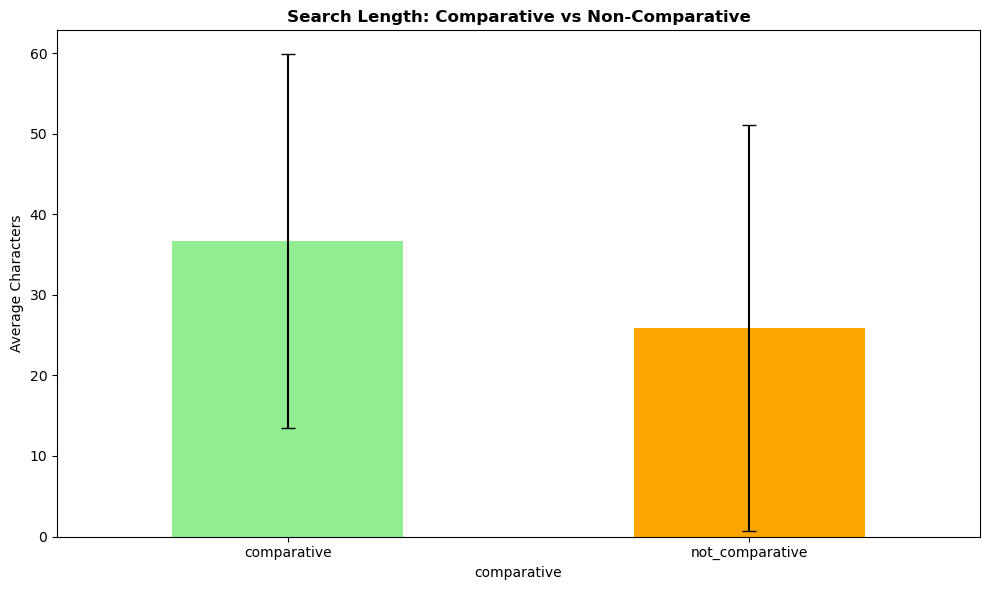

Comparative avg length: 36.6 chars
Non-comparative avg: 25.9 chars


In [6]:
df['search_length'] = df['search_q'].astype(str).str.len()
plt.figure(figsize=(10, 6))
comp_length = df.groupby('comparative')['search_length'].agg(['mean', 'std'])
comp_length['mean'].plot(kind='bar', yerr=comp_length['std'], capsize=5, color=['lightgreen', 'orange'])
plt.ylabel('Average Characters')
plt.title('Search Length: Comparative vs Non-Comparative', fontweight='bold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print(f"Comparative avg length: {df[df['comparative']=='comparative']['search_length'].mean():.1f} chars")
print(f"Non-comparative avg: {df[df['comparative']=='not_comparative']['search_length'].mean():.1f} chars")


**Key Findings**
- The bar chart compares the average character length of comparative and non‑comparative queries, including variability through error bars. Comparative queries are noticeably longer, with an average length of about 36.6 characters, compared with roughly 25.9 characters for non‑comparative queries.​

- This indicates that comparative searches tend to be more verbose and information‑rich, likely because users need to mention at least two entities and sometimes additional qualifiers (for example, “best”, “cheaper”, or specific attributes). The larger spread (error bar) around comparative queries also suggests greater heterogeneity in how users phrase comparisons, whereas non‑comparative queries are shorter and more uniform, consistent with simpler, single‑entity lookups.

## 5.4 Feature 4: Comparative Detection
**Reformulation Detection**

The Reformulation feature measures how much a user changes their query from one submission to the next. By computing the Levenshtein distance between sequential queries for each user, we can quantify whether a user is making minor tweaks (low distance) or entirely new queries (high distance). This helps distinguish iterative query refinement from exploratory search behaviour.

In our implementation, all queries are processed sequentially per user to maintain the natural order. Both the original Levenshtein distance and a normalised distance (scaled 0–1 by query length) are computed for each query pair. Missing or empty queries are safely handled and set to 0.

---

**(i) Sequential Query Comparison**

- For each user, maintain a record of the **previous query**.
- Iterate through the dataset **row by row**, ensuring chronological order is preserved.
- For each query pair:
    - Compute the **Levenshtein distance** (number of character edits) between the previous query and the current query.
    - Compute a **normalized distance** using the formula:

$$
\text{lev_norm} = \frac{\text{Levenshtein distance}}{\max(\text{length(prev_query)}, \text{length(cur_query)}, 1)}
$$

- If either query is missing (`NaN`), assign distance 0 to avoid breaking downstream calculations.

**(ii) Chunked Processing for Memory Efficiency**

- The dataset (~3M rows) is processed in **chunks of 100,000 rows** to run safely on 8 GB RAM.
- Distances are calculated **row by row within each chunk**, and results are appended incrementally to the output CSV.
- Two new columns are added:
    - `reformulation_levenshtein`: original distance (number of edits)
    - `reformulation_levenshtein_norm`: normalized distance between 0–1

---
**Example**

| User   | Query                               | Previous Query                     | Levenshtein | Normalized |  
| ------ | ----------------------------------- | --------------------------------- | ----------- | ---------- |  
| user_1 | "python list comprehension"         | "python list"                     | 13          | 0.65       |  
| user_1 | "python list comprehension example" | "python list comprehension"       | 8           | 0.44       |  
| user_2 | "benefits of exercise"              | –                                 | 0           | 0          |  
| user_1 | "list comprehension in python"      | "python list comprehension example" | 15        | 0.79       |  

---

In [42]:
# ==========================================================
# Reformulation Feature (Original + Normalized Distance)
# ==========================================================

import os
import sys
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Install RapidFuzz (Fast C++ Levenshtein)
# -----------------------------
try:
    from rapidfuzz import distance
except:
    !{sys.executable} -m pip install rapidfuzz --quiet
    from rapidfuzz import distance

# -----------------------------
# File paths
# -----------------------------
input_path = "/Users/tdf/Downloads/filtered_df_with_comparative.csv"
output_path = "/Users/tdf/Downloads/filtered_df_with_reformulation.csv"
chunksize = 100_000   # safe for 8GB RAM

user_col = "device_name_actual"
query_col = "search_q"

if not os.path.exists(input_path):
    raise FileNotFoundError(f"Input file not found: {input_path}")

# -----------------------------
# Dictionary to track *previous* query
# -----------------------------
last_query_by_user = {}

# Helper function — safely handle NaN / non-string queries
def compute_lev(prev_q, cur_q):
    if prev_q is None or pd.isna(prev_q):
        return 0, 0
    if cur_q is None or pd.isna(cur_q):
        return 0, 0
    prev_q_str = str(prev_q)
    cur_q_str = str(cur_q)
    lev = distance.Levenshtein.distance(prev_q_str, cur_q_str)
    lev_norm = lev / max(len(prev_q_str), len(cur_q_str), 1)  # normalized 0-1
    lev_norm = round(lev_norm, 2)  # round to 2 decimal places
    return lev, lev_norm


# -----------------------------
# Stream CSV in chunks
# -----------------------------
first = True
total = 0

reader = pd.read_csv(input_path, chunksize=chunksize, low_memory=False)

for chunk in tqdm(reader, desc="Processing reformulation feature"):
    levs_orig = []
    levs_norm = []

    for idx, row in chunk.iterrows():
        user = row[user_col]
        cur_q = row[query_col]
        prev_q = last_query_by_user.get(user, None)

        lev, lev_norm = compute_lev(prev_q, cur_q)
        levs_orig.append(lev)
        levs_norm.append(lev_norm)

        last_query_by_user[user] = cur_q

    # Add new columns
    chunk["reformulation_levenshtein"] = levs_orig
    chunk["reformulation_levenshtein_norm"] = levs_norm

    # Replace any missing (should be none) with 0 just in case
    chunk["reformulation_levenshtein"] = chunk["reformulation_levenshtein"].fillna(0)
    chunk["reformulation_levenshtein_norm"] = chunk["reformulation_levenshtein_norm"].fillna(0)

    # Append to output
    if first:
        chunk.to_csv(output_path, index=False, mode="w")
        first = False
    else:
        chunk.to_csv(output_path, index=False, mode="a", header=False)

    total += len(chunk)

print(f"Completed! {total} rows processed.")
print(f"Output saved to: {output_path}")


Processing reformulation feature: 34it [02:07,  3.74s/it]

Completed! 3382011 rows processed.
Output saved to: /Users/tdf/Downloads/filtered_df_with_reformulation.csv


In [43]:
df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_reformulation.csv')

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_28210/2206225052.py:1: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tdf/Downloads/filtered_df_with_reformulation.csv')


In [44]:
df.head()

school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode         regex  \
0            True           False        1.0  not_question   
1            True           False        2.0  not_question   
2           False           False        2.0  not_question   
3           False           False        2.0  not_question   
4           False           False        2.0  not_question   

   user_question_rate      closure closure_words      comparative  \
0            0.097917  not_closure            []  not_comparative   
1            0.097917  not_closure            []  not_comparative   
2            0.097917  not_closure            []  not_comparative   
3            0.097917  not_closure            []  not_comparative   
4            0.097917  not_closure            []  not_comparative   

  comparative_words  reformulation_levenshtein  reformulation_levenshtein_norm  
0                []                          0                            0.00  
1                []                         29                            0.97  
2                []                          4                            0.12  
3                []                         17                            0.53  
4                []                         13                            0.41

#### (a) User-Level Reformulation Behaviour

**(i) Distribution of User Reformulation Rates**

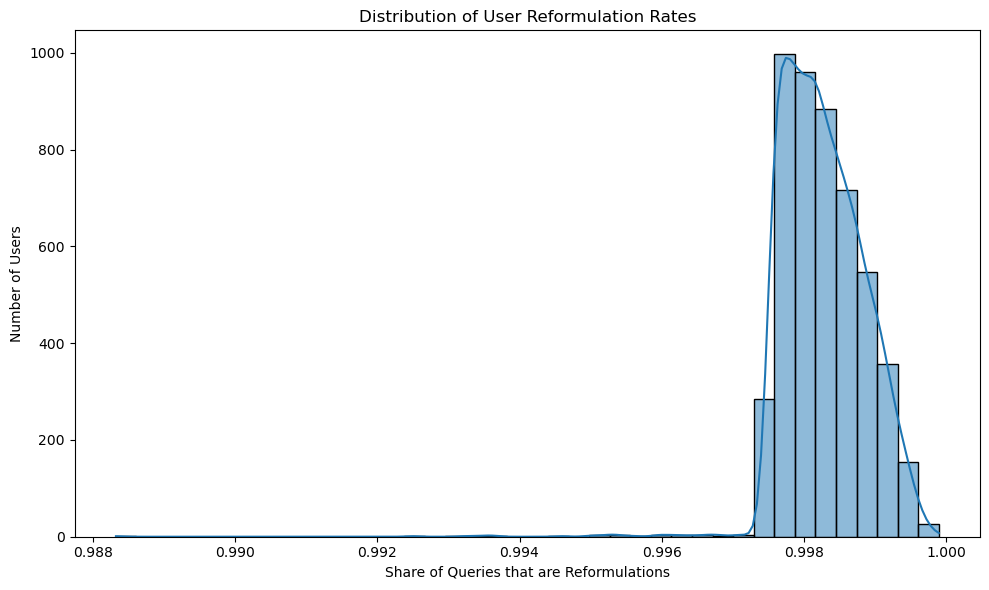

In [78]:
user_col = "device_name_actual"

# treat norm distance > 0 as a reformulation
df["is_reformulation"] = df["reformulation_levenshtein_norm"] > 0

user_reform_rate = (
    df.groupby(user_col)["is_reformulation"]
      .mean()
      .rename("reformulation_rate")
)

plt.figure(figsize=(10,6))
sns.histplot(user_reform_rate, bins=40, kde=True)
plt.xlabel("Share of Queries that are Reformulations")
plt.ylabel("Number of Users")
plt.title("Distribution of User Reformulation Rates")
plt.tight_layout()
plt.show()

**Key Findings**
- The first plot (share of queries that are reformulations) shows that almost all users have reformulation rates extremely close to 1.0, meaning that, under the current definition, nearly every query is counted as a reformulation of the previous one. This indicates that users rarely repeat exactly the same query string; instead, they usually change at least one character, word, or spacing when issuing a new query.

**(ii) Distribution of Average Normalised Reformulation Per User**

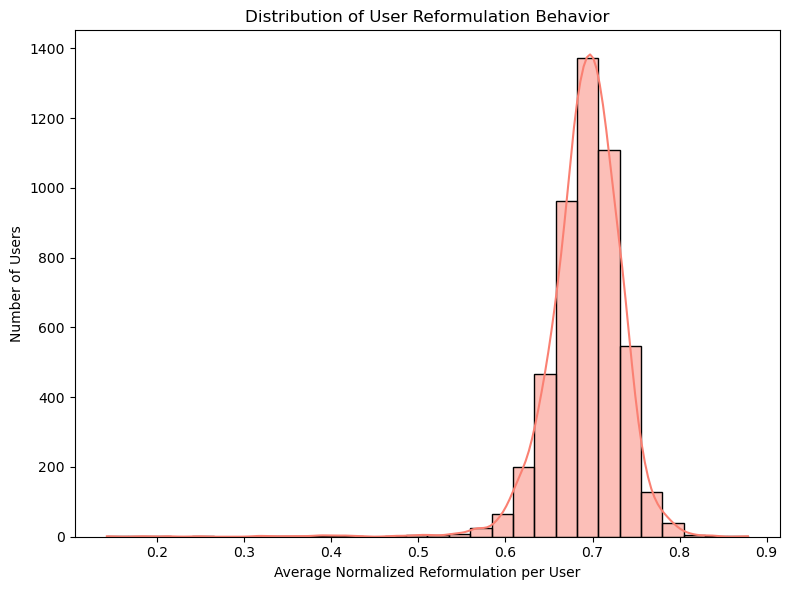

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate per user
user_reform_stats = df.groupby('device_name_actual')['reformulation_levenshtein_norm'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(8,6))
sns.histplot(
    user_reform_stats['mean'],
    bins=30,
    kde=True,
    color='salmon'
)
plt.xlabel("Average Normalized Reformulation per User")
plt.ylabel("Number of Users")
plt.title("Distribution of User Reformulation Behavior")
plt.tight_layout()
plt.show()


**Key Findings**
- The second plot (average normalised edit distance per user) reveals that typical reformulations are not just tiny tweaks but substantial rewrites. Most users cluster around an average normalised edit distance of roughly 0.65–0.7, implying that consecutive queries often differ in a large portion of their characters, consistent with users shifting terms, adding/removing entities, or rephrasing intent rather than only correcting small typos. 



**(iii) Distribution of Reformulation Strength at Query Level**

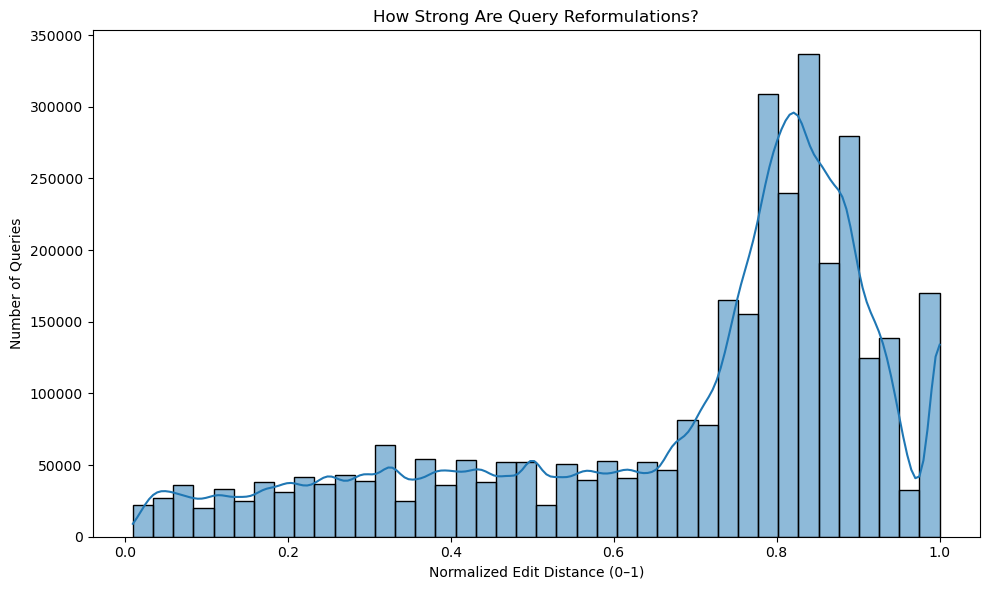

In [80]:
# consider only queries where there was some change
df_reform_only = df[df["reformulation_levenshtein_norm"] > 0]

plt.figure(figsize=(10,6))
sns.histplot(df_reform_only["reformulation_levenshtein_norm"], bins=40, kde=True)
plt.xlabel("Normalized Edit Distance (0–1)")
plt.ylabel("Number of Queries")
plt.title("How Strong Are Query Reformulations?")
plt.tight_layout()
plt.show()


**Key Findings**
- The third plot focuses on the normalised edit distance between consecutive queries at the query level. The mass of the distribution lies around 0.7–0.9, indicating that when users change a query, they typically alter a large proportion of the characters rather than making tiny edits; reformulations are usually substantial rewrites rather than minor corrections. There is still a spread across the full 0–1 range, which shows that both small tweaks and very large changes exist, but the high peak at large distances suggests that “try a very different query next” is the dominant behaviour.

**(iv) Percentage of Reformulated Queries**

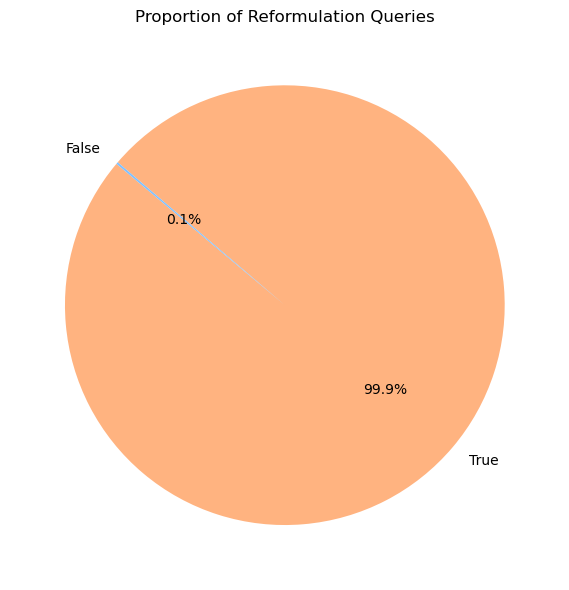

In [90]:
import matplotlib.pyplot as plt

# Count the True/False values
counts = df['is_reformulation'].value_counts()
labels = counts.index.astype(str)

# Pastel colors
colors = ['#FFB380', '#80C1FF']  # True=orange-ish, False=blue-ish

plt.figure(figsize=(6,6))
plt.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors
)
plt.title("Proportion of Reformulation Queries")
plt.tight_layout()
plt.show()


**Conclusion**

Together, these findings characterise the search experience as highly dynamic at the text level: users almost always modify their queries, and those modifications are usually quite large rather than incremental.

#### (b) Reformulation Intensity Across User Query Volumes

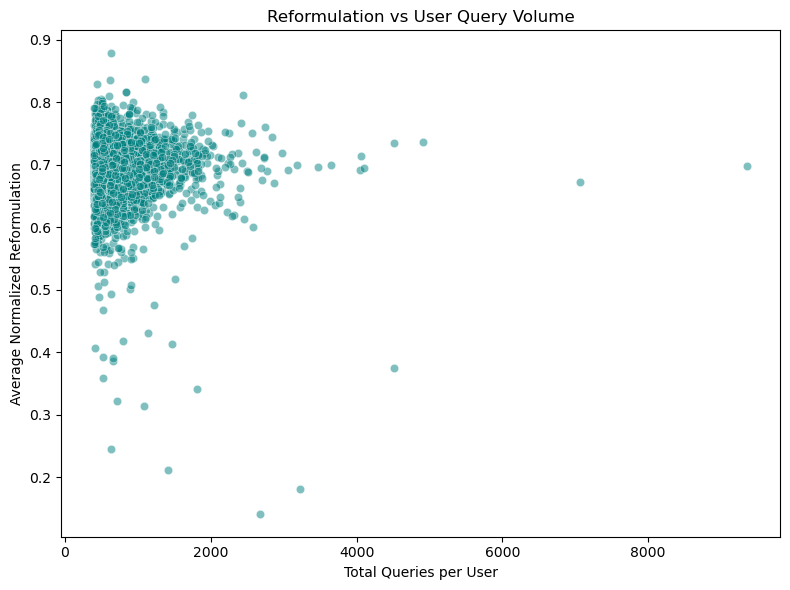

In [81]:
user_volume = df.groupby('device_name_actual')['search_q'].count().reset_index(name='num_queries')
user_avg_reform = df.groupby('device_name_actual')['reformulation_levenshtein_norm'].mean().reset_index(name='avg_reform_norm')

user_reform_plot = user_volume.merge(user_avg_reform, on='device_name_actual')

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=user_reform_plot,
    x='num_queries',
    y='avg_reform_norm',
    alpha=0.5,
    color='teal'
)
plt.xlabel("Total Queries per User")
plt.ylabel("Average Normalized Reformulation")
plt.title("Reformulation vs User Query Volume")
plt.tight_layout()
plt.show()


**Key Findings**
- The plot relates each user’s total number of queries to their average normalised reformulation distance. Most users, regardless of how many queries they issue, cluster around an average edit distance of roughly 0.6–0.75, indicating that substantial rewrites are common across both light and heavy users.​

- There is no strong monotonic trend between query volume and reformulation intensity: high‑volume users do not systematically reformulate more or less than low‑volume users, although a few extreme outliers appear at very high volumes and a wide range of edit distances. This suggests that reformulation style is more of an individual trait than a simple function of how active a user is.

#### (c) Relationship Between Reformulation Intensity and Comparative Behaviour

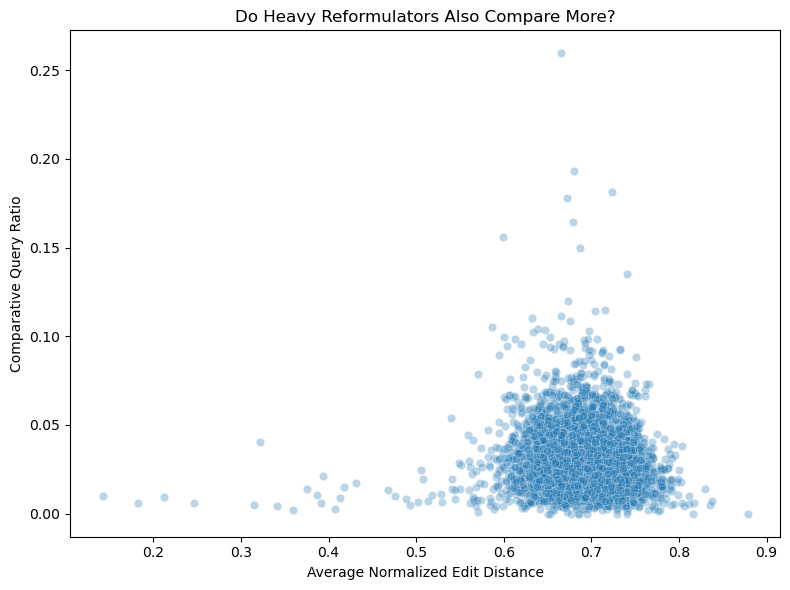

In [85]:
# Ensure column name
user_reform = user_reform.rename("avg_reformulation")  # if it's a Series
user_joint = pd.concat([user_reform, user_comp_rate], axis=1).dropna()

# Now the plot should work
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=user_joint, x="avg_reformulation", y="comparative_rate",
    alpha=0.3
)
plt.xlabel("Average Normalized Edit Distance")
plt.ylabel("Comparative Query Ratio")
plt.title("Do Heavy Reformulators Also Compare More?")
plt.tight_layout()
plt.show()



**Key Findings**
- The plot compares each user’s average normalised reformulation distance with their comparative query ratio. Most users form a dense cluster around edit distances of roughly 0.6–0.75 and very low comparative ratios (near 0–6%), indicating that substantial reformulations are common even among users who seldom issue explicit comparative queries.

- There is no clear upward trend linking stronger reformulation with higher comparative intensity; users who reformulate heavily are not systematically more likely to be heavy comparers. A few outliers combine high edit distances with above‑average comparative ratios, but these are rare, suggesting that “reformulating a lot” and “comparing a lot” represent largely independent dimensions of search behaviour.



#### (d) Top 15 Users By Reformulation Intensity

In [ ]:
min_queries = 20  # ignore users with tiny histories
query_counts = df.groupby(user_col).size()
valid_users = query_counts[query_counts >= min_queries].index

top_reform = user_reform.loc[valid_users].nlargest(15).sort_values()

plt.figure(figsize=(14,7))
bars = plt.barh(range(len(top_reform)), top_reform.values, color="mediumpurple")
plt.yticks(range(len(top_reform)), top_reform.index.astype(str))
plt.xlabel("Average Normalized Edit Distance")
plt.title("Top 15 Users/Devices by Reformulation Intensity")
for i, v in enumerate(top_reform.values):
    plt.text(v + 0.01, i, f"{v:.2f}", va="center")
plt.tight_layout()
plt.show()


**Key Findings**

- The bar chart lists the 15 users/devices with the highest average normalised edit distance between consecutive queries. All values are very high (around 0.80–0.88), meaning that these users typically change most of the characters in their queries from one step to the next.​

- Compared with the overall user distribution, this group represents an extreme tail of “heavy reformulators” whose search journeys are characterised by repeated, substantial rephrasing rather than small incremental edits. These profiles are likely to correspond to users who are either exploring alternatives broadly or struggling to express their intent, making them interesting candidates for targeted support such as query suggestions or interactive guidance.



#### (e) Reformulation Intensity Across Comparative User Segments

In [ ]:
user_col = "device_name_actual"

# Per‑user stats
user_reform = df.groupby(user_col)["reformulation_levenshtein_norm"].mean()
user_comp = df.groupby(user_col)["comparative"].apply(lambda x: (x=="comparative").mean())

user_stats = pd.DataFrame({
    "avg_reformulation": user_reform,
    "comparative_rate": user_comp
}).dropna()

# Bucket users by comparative rate
bins = [0, 0.02, 0.05, 0.1, 1.0]
labels = ["0–2%", "2–5%", "5–10%", "10%+"]
user_stats["comp_bucket"] = pd.cut(user_stats["comparative_rate"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.boxplot(data=user_stats, x="comp_bucket", y="avg_reformulation")
plt.xlabel("User Comparative Query Ratio")
plt.ylabel("Average Normalized Edit Distance")
plt.title("Reformulation Intensity Across Comparative User Segments")
plt.tight_layout()
plt.show()

**Key Findings**

- Each box represents users grouped by their comparative query ratio, from 0–2% up to 10%+ of queries being comparative. 

- For each segment, the median (line in the box) sits around 0.67–0.71, and the boxes and whiskers overlap a lot, meaning the typical user in every segment makes similarly large edits when reformulating.

- This pattern indicates that users who issue more comparative queries do not systematically reformulate more or less than those who rarely compare; reformulation intensity is relatively stable across comparative segments. While each group contains a few outliers with unusually low or high edit distances, these are exceptions rather than evidence of a strong relationship between comparison behaviour and how aggressively users rewrite their queries



## 6. Saving Final CSV For Surface Deep

In [92]:
import pandas as pd
from tqdm import tqdm

# Path to save
output_path = "/Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv"

# Chunk size (adjust if needed)
chunksize = 100_000

# If your DataFrame is already in memory
total_rows = len(df)
first = True

for start in tqdm(range(0, total_rows, chunksize), desc="Saving CSV in chunks"):
    end = min(start + chunksize, total_rows)
    chunk = df.iloc[start:end]
    
    if first:
        chunk.to_csv(output_path, index=False, mode='w')  # write header first time
        first = False
    else:
        chunk.to_csv(output_path, index=False, mode='a', header=False)  # append afterwards

print(f"Completed! DataFrame saved to: {output_path}")


Saving CSV in chunks: 100%|█████████████████████| 34/34 [00:34<00:00,  1.02s/it]

Completed! DataFrame saved to: /Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv


## 5.5 Feature 5: Time Interval Between Queries

**Time Interval Feature**

The `time_interval` feature captures the average duration (in seconds) between consecutive queries within the same query episode. This helps quantify user engagement and pacing during search sessions: shorter intervals indicate rapid, iterative querying, whereas longer intervals may reflect more thoughtful or exploratory search behaviour.

- The calculation is **grouped by user/session identifiers** (`school_name` + `device_name_actual` + `q_episode`) to ensure comparisons are only within the same query episode.
- Episodes with a **single query** are assigned a `time_interval` of 0.
- Results are **rounded to 2 decimal places** for readability.

---
**(i) Sequential Query Timing**
- For each episode, queries are sorted chronologically by `created_at`.
- Compute the difference in timestamps between each query and its previous query within the same episode.
- Compute the average of these differences to obtain a single `time_interval` per query episode.
- Missing or invalid timestamps are handled safely using `errors='coerce'`.

**(ii) Preservation of Original Order**
- A temporary `_original_index` column is used to remember the initial row order.
- After calculation, the dataframe is re-sorted to its original order and the helper column is dropped.

---
**Example**
| school | device | episode | created_at |diff (seconds) |
| ------ | ------ | ------- | ---------- |-------------- |
| A      | 1      | 2       | 21:21:00   |NaN            |
| A      | 1      | 2       | 21:21:54   |54             |
| A      | 1      | 2       | 21:24:07   |133            |
| A      | 1      | 2       | 21:24:34   |27             |

The first query in an episode has no previous query, so its time difference is undefined and ignored in the averaging step.

The average inter-query time is computed as:

$$
\text{Average} = \frac{54 + 133 + 27}{3} = 71.33
$$


In [4]:
import pandas as pd

def add_time_interval_feature_preserve_order(df):
    """
    Adds a `time_interval` feature to the dataframe without changing the original row order.

    time_interval:
    - Average difference in query times (seconds) within a query episode.
    - Episodes with a single query are assigned 0.
    - Rounded to 2 decimal places.
    """

    # 1. Make a deep copy to preserve original dataframe
    df_feat = df.copy(deep=True)

    # 2. Parse timestamps safely
    df_feat['created_at'] = pd.to_datetime(
        df_feat['created_at'], utc=True, errors='coerce'
    )

    # 3. Save original order
    df_feat['_original_index'] = df_feat.index

    # 4. Sort temporarily for correct diff calculation
    df_feat = df_feat.sort_values(
        by=['school_name', 'device_name_actual', 'q_episode', 'created_at']
    )

    # 5. Difference in query times within each episode (seconds)
    df_feat['inter_query_diff'] = (
        df_feat.groupby(['school_name', 'device_name_actual', 'q_episode'])['created_at']
        .diff()
        .dt.total_seconds()
    )

    # 6. Average inter-query duration per episode
    df_feat['time_interval'] = (
        df_feat.groupby(['school_name', 'device_name_actual', 'q_episode'])['inter_query_diff']
        .transform('mean')
    )

    # 7. Replace NaN (single-query episodes) with 0 and round to 2 decimals
    df_feat['time_interval'] = df_feat['time_interval'].fillna(0).round(2)

    # 8. Drop helper column
    df_feat.drop(columns=['inter_query_diff'], inplace=True)

    # 9. Restore original row order
    df_feat = df_feat.sort_values('_original_index').drop(columns=['_original_index'])

    return df_feat

# =====================
# Example usage
# =====================

# Suppose df is your original dataframe
df_updated = add_time_interval_feature_preserve_order(df)

# Preview the first few rows
df_updated.head()

school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode         regex  \
0            True           False        1.0  not_question   
1            True           False        2.0  not_question   
2           False           False        2.0  not_question   
3           False           False        2.0  not_question   
4           False           False        2.0  not_question   

   user_question_rate      closure closure_words      comparative  \
0            0.097917  not_closure            []  not_comparative   
1            0.097917  not_closure            []  not_comparative   
2            0.097917  not_closure            []  not_comparative   
3            0.097917  not_closure            []  not_comparative   
4            0.097917  not_closure            []  not_comparative   

  comparative_words  reformulation_levenshtein  \
0                []                          0   
1                []                         29   
2                []                          4   
3                []                         17   
4                []                         13   

   reformulation_levenshtein_norm  is_reformulation  time_interval  
0                            0.00             False           0.00  
1                            0.97              True          71.33  
2                            0.12              True          71.33  
3                            0.53              True          71.33  
4                            0.41              True          71.33

In [5]:
print(df.shape)

(3382011, 19)


**Handling Missing Timestamps (NaT) in `created_at`**

**Observation**:

In our dataset, there was 1 row where the created_at timestamp could not be parsed and became NaT (Not a Time). This row corresponds to the user/device combination:

| Column             | Value                        |
| ------------------ | ---------------------------- |
| school_name        | assumption_english_secondary |
| created_at         | NaT                          |
| device_name_actual | 23                           |
| uri                | False                        |
| search_q           | NaN                          |
| q_episode          | NaN                          |
| time_interval      | 0.0                          |

**Impact**:

- The single NaT row does not distort overall calculations.
- This row is preserved in the dataset to maintain data integrity but is flagged as having an invalid timestamp.
- Using default values ensures downstream analyses, aggregations, and model inputs are robust to missing timestamps.
- Other features, such as reformulation distances, remain unaffected by the missing timestamp because they rely on sequential query comparisons per episode.

**Summary**:
The dataset is robust to missing or corrupted timestamps: missing created_at entries result in time_interval = 0, and all other features are safely populated. In our example, only 1 row out of ~3M had NaT.


In [23]:
# Check which rows have NaT in the created_at column of the updated dataframe
nan_rows = df_updated[df_updated['created_at'].isna()]

# Preview the rows
print(nan_rows)

# Or just get the count
print("Number of NaT rows:", df_updated['created_at'].isna().sum())


                          school_name created_at    uri  device_name_actual  \
2794287  assumption_english_secondary        NaT  False                  23   

        was_allowed  profile_custom search_q has_safe_active is_navigational  \
2794287         NaN             NaN      NaN             NaN             NaN   

         q_episode         regex  user_question_rate      closure  \
2794287        NaN  not_question            0.127364  not_closure   

        closure_words      comparative comparative_words  \
2794287            []  not_comparative                []   

         reformulation_levenshtein  reformulation_levenshtein_norm  \
2794287                          0                             0.0   

         is_reformulation  time_interval  
2794287             False            0.0  
Number of NaT rows: 1


#### (a) Distribution of User-Level Mean Time Interval Between Queries

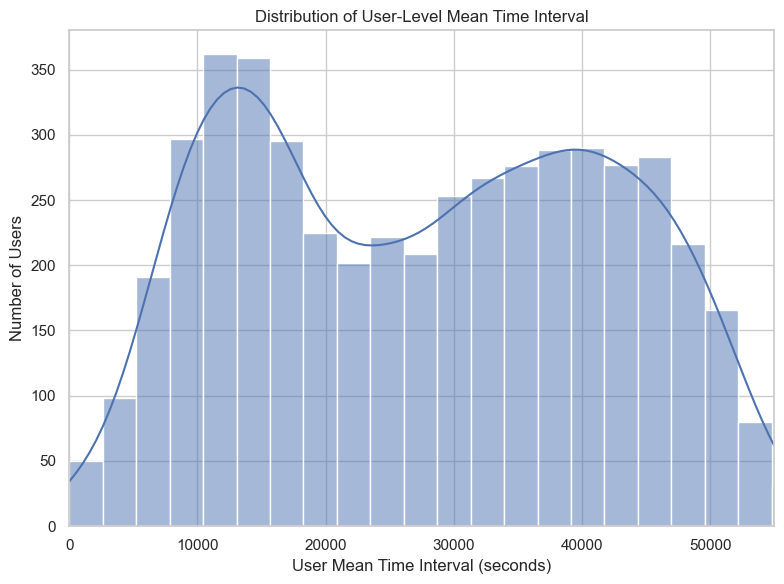

In [41]:
user_time = (
    df_updated
    .groupby('device_name_actual', dropna=False)['time_interval']
    .mean()
    .reset_index(name='user_mean_time_interval')
)

plt.figure(figsize=(8, 6))
sns.histplot(
    data=user_time,
    x='user_mean_time_interval',
    bins=40,
    kde=True
)
plt.xlim(0, np.nanquantile(user_time['user_mean_time_interval'], 0.99))
plt.xlabel("User Mean Time Interval (seconds)")
plt.ylabel("Number of Users")
plt.title("Distribution of User-Level Mean Time Interval")
plt.tight_layout()
plt.show()



**Key Findings**

 The histogram shows a wide spread in users’ average time between queries, with mean intervals ranging from close to 0 up to about 55,000 seconds (roughly 0-15 hours), indicating substantial heterogeneity in how intensively users engage with their PLDs.

- The shape is clearly multi‑modal, with a pronounced peak around 10,000-15,000 seconds (about 3-4 hours) and another broad hump between 35,000-45,000 seconds (about 10-12 hours), suggesting distinct pacing regimes such as “bursty” users who issue queries in relatively quick succession and slower users who typically return only after much longer breaks.

- Despite this heterogeneity, most users lie between roughly 5,000 and 50,000 seconds of mean interval, with relatively few extreme outliers, implying that tempo differences are gradual rather than driven by a handful of anomalous devices and supporting the use of time_interval as a meaningful continuous feature for subsequent segmentation or modelling.



#### (b) User Pacing Styles and Burstiness

These two figures characterise how users differ not only in their average time between queries but also in how stable vs bursty their timing is across interactions.

**(i) User Mean Time Interval vs Variance**

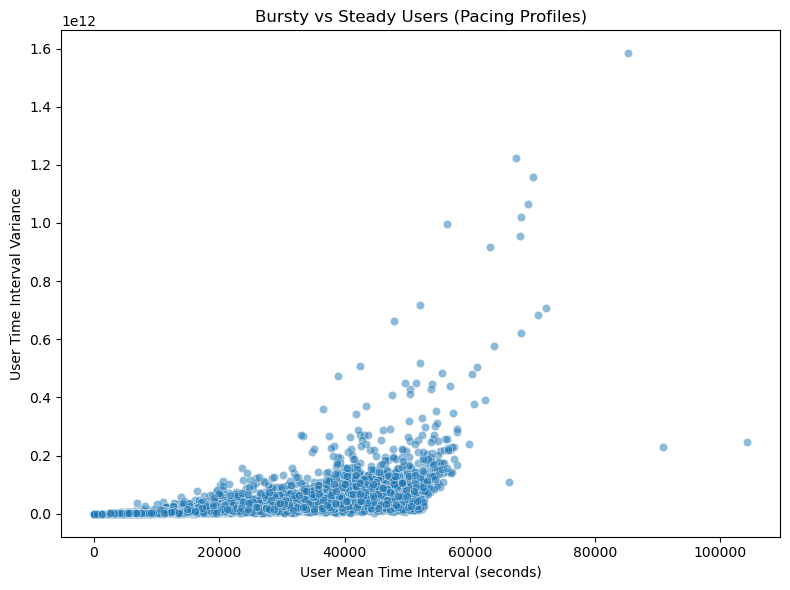

In [32]:
user_pacing = (
    df.groupby('device_name_actual', dropna=False)['time_interval']
      .agg(['mean', 'var', 'count'])
      .reset_index()
      .rename(columns={'mean':'user_time_mean', 'var':'user_time_var', 'count':'n_queries'})
)

min_q = 30
user_pacing = user_pacing[user_pacing['n_queries'] >= min_q]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_pacing,
    x='user_time_mean',
    y='user_time_var',
    alpha=0.5
)
plt.xlabel("User Mean Time Interval (seconds)")
plt.ylabel("User Time Interval Variance")
plt.title("Bursty vs Steady Users (Pacing Profiles)")
plt.tight_layout()
plt.show()

**Key Findings**
- Each point represents a user, with the x‑axis showing their mean time between queries and the y‑axis showing the variance of that interval, jointly capturing typical pace and stability of pacing.​

- The dense cloud at mean intervals below roughly 40,000 seconds and relatively low variance indicates a large group of users who interact at a consistently fast tempo with small fluctuations, while a smaller set of users with longer means and very high variance (up to around 1.6 ×1012) exhibit “bursty” behaviour, alternating between long idle gaps and short, intense querying bouts.


**(ii) Bursty vs Steady Users by Pacing Group**

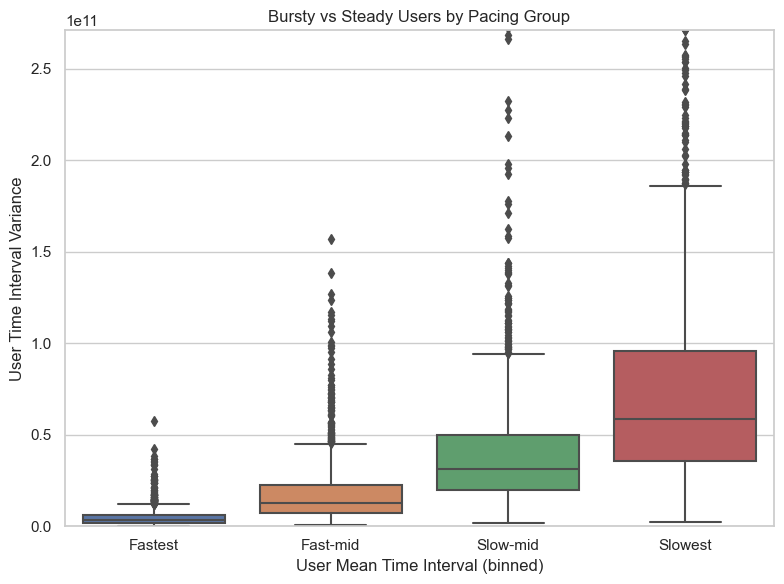

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# df_updated must contain: device_name_actual, time_interval
# Build user_pacing first
user_pacing = (
    df_updated.groupby('device_name_actual', dropna=False)['time_interval']
      .agg(['mean', 'var', 'count'])
      .reset_index()
      .rename(columns={
          'mean': 'user_time_mean',
          'var': 'user_time_var',
          'count': 'n_queries'
      })
)

# 1. Keep reasonably active users
min_q = 30
user_pacing_filt = user_pacing[user_pacing['n_queries'] >= min_q].copy()

# 2. Bin users by mean time interval (quantile bins)
user_pacing_filt['mean_time_bin'] = pd.qcut(
    user_pacing_filt['user_time_mean'],
    q=4,
    labels=['Fastest', 'Fast-mid', 'Slow-mid', 'Slowest']  # normal hyphen
)


# 3. Boxplot of variance by mean‑time bin
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=user_pacing_filt,
    x='mean_time_bin',
    y='user_time_var'
)
plt.ylim(0, user_pacing_filt['user_time_var'].quantile(0.99))  # trim extreme outliers
plt.xlabel("User Mean Time Interval (binned)")
plt.ylabel("User Time Interval Variance")
plt.title("Bursty vs Steady Users by Pacing Group")
plt.tight_layout()
plt.show()


**Key Findings**
- When users are split into four bins by mean time interval (Fastest, Fast‑mid, Slow‑mid, Slowest), the median variance increases monotonically from the Fastest to the Slowest group, and the spread of variance also widens, showing that slower‑paced users tend to have more irregular, bursty timing.​

- The Fastest group has a tight variance distribution with relatively few high‑variance outliers, whereas the Slowest group shows both higher typical variance and many extreme outliers above 2 × 1011, reinforcing the idea that long average gaps are often accompanied by highly uneven engagement patterns rather than simply uniformly slow use.


#### (c) Pacing Patterns of Top Users

These two figures zoom in on the 20 highest‑volume devices to examine how their average pacing and within‑user variability compare.

**(i) Mean Pacing for Top Users**

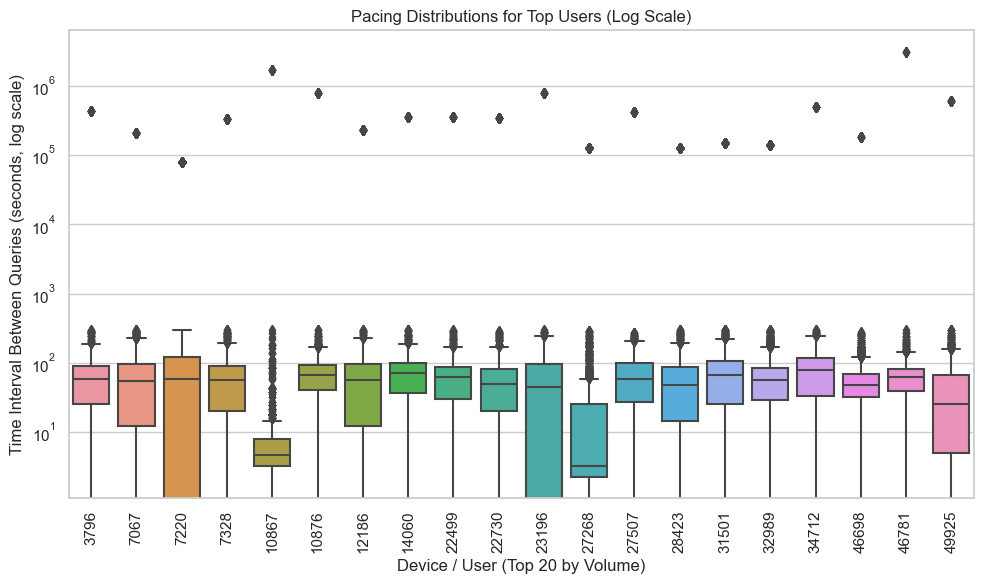

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20
top_users = (
    df_updated['device_name_actual']
    .value_counts()
    .head(top_n)
    .index
)

df_top = df_updated[df_updated['device_name_actual'].isin(top_users)].copy()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top,
    x='device_name_actual',
    y='time_interval'
)
plt.yscale('log')  # log scale to spread out small vs huge intervals
plt.xlabel("Device / User (Top 20 by Volume)")
plt.ylabel("Time Interval Between Queries (seconds, log scale)")
plt.title("Pacing Distributions for Top Users (Log Scale)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**Key Findings**
- The scatterplot shows that most top users cluster between roughly 4,000 and 8,000 seconds of mean time between queries (about 1-2 hours), indicating broadly similar average pacing despite large differences in total query volume.​

- A small number of devices stand out at the extremes, with mean intervals close to 1,000 seconds on the low side and above 8,000 seconds on the high side, highlighting a minority of top users who either interact almost continuously or spread their queries over much longer gaps.

**(ii) Pacing Distributions for Top Users**

In [48]:
user_mean_time = (
    df_updated.groupby('device_name_actual')['time_interval']
    .mean()
    .reset_index(name='user_mean_time_interval')
)

top_users = (
    df_updated['device_name_actual']
    .value_counts()
    .head(20)
    .index
)

top_mean = user_mean_time[user_mean_time['device_name_actual'].isin(top_users)]

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=top_mean,
    x='device_name_actual',
    y='user_mean_time_interval',
    s=60
)
plt.xlabel("Device / User (Top 20 by Volume)")
plt.ylabel("Mean Time Interval Between Queries (seconds)")
plt.title("Mean Pacing for Top Users")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


**Key Findings**
- The log-scaled boxplots reveal that within individual devices, time intervals span several orders of magnitude, from fractions of a second up to 105-106 seconds. This shows that even the same user alternates between rapid bursts and long pauses rather than operating at a single fixed tempo.

- The central boxes for most devices sit between roughly 10⁰ and 10² seconds, with long upper whiskers and many high‑end outliers, indicating that typical within‑session gaps are short but occasionally interrupted by very long breaks; this pattern is consistent across most of the top 20 users rather than being driven by just one or two anomalous devices.

#### (d) Do Faster Users Reformulate More?

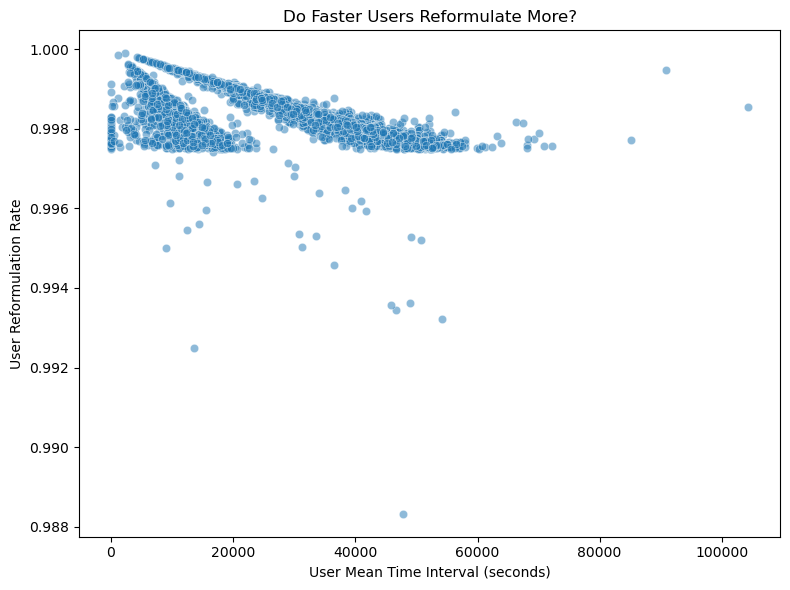

In [26]:
# user-level mean time interval and reformulation rate
user_pace = (
    df.groupby('device_name_actual', dropna=False)
      .agg(
          user_mean_time_interval=('time_interval', 'mean'),
          user_reform_rate=('is_reformulation', 'mean'),
          total_queries=('search_q', 'size')
      )
      .reset_index()
)

# optional: filter to users with enough queries
min_q = 20
user_pace = user_pace[user_pace['total_queries'] >= min_q]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=user_pace,
    x='user_mean_time_interval',
    y='user_reform_rate',
    alpha=0.5
)
plt.xlabel("User Mean Time Interval (seconds)")
plt.ylabel("User Reformulation Rate")
plt.title("Do Faster Users Reformulate More?")
plt.tight_layout()
plt.show()


**Key Findings**
- Almost all users have extremely high reformulation rates between 0.988 and 1.000, so reformulation is pervasive regardless of pacing; the cloud of points is tightly packed near the top of the y‑axis rather than spread across the full 0–1 range.

- There is at most a very weak downward trend: users with shorter mean time intervals (faster users) cluster around reformulation rates just below 1.0, while users with longer intervals scatter in a similar narrow band, indicating that tempo does not meaningfully differentiate reformulation propensity—fast and slow users both rewrite almost every query

#### (e) Episode Tempo & Closure/Comparative Mix

**(i) Scatterplots**

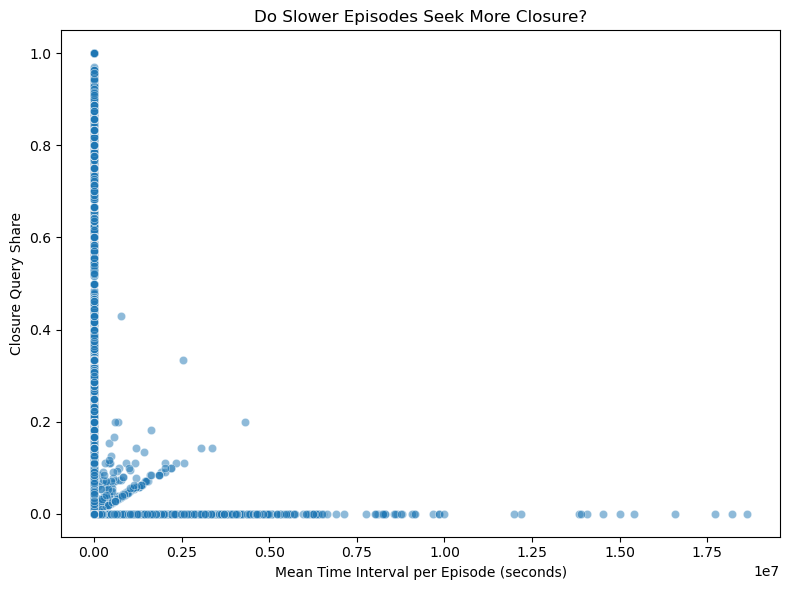

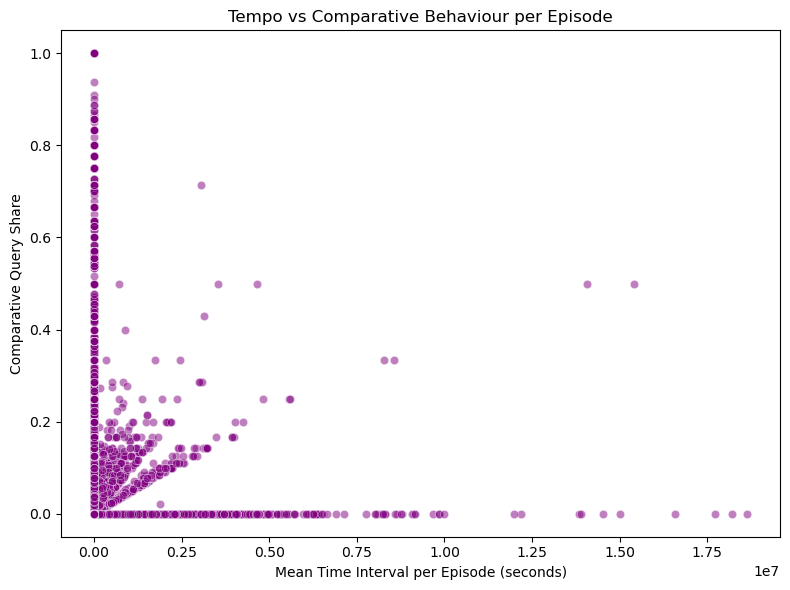

In [29]:
# episode-level aggregates
ep_beh = (
    df.groupby(['device_name_actual', 'q_episode'], dropna=False)
      .agg(
          episode_time_interval=('time_interval', 'mean'),
          question_rate=('regex', lambda s: (s == 'question').mean() if len(s) > 0 else np.nan),
          closure_rate=('closure', lambda s: (s == 'closure').mean() if len(s) > 0 else np.nan),
          comparative_rate=('comparative', lambda s: (s == 'comparative').mean() if len(s) > 0 else np.nan)
      )
      .reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ep_beh,
    x='episode_time_interval',
    y='closure_rate',
    alpha=0.5
)
plt.xlabel("Mean Time Interval per Episode (seconds)")
plt.ylabel("Closure Query Share")
plt.title("Do Slower Episodes Seek More Closure?")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ep_beh,
    x='episode_time_interval',
    y='comparative_rate',
    alpha=0.5,
    color='purple'
)
plt.xlabel("Mean Time Interval per Episode (seconds)")
plt.ylabel("Comparative Query Share")
plt.title("Tempo vs Comparative Behaviour per Episode")
plt.tight_layout()
plt.show()

**Key Findings for Tempo and Closure (Blue Graph)**
- Most episodes have closure query share ≈ 0, including very long intervals up to roughly 1.8x10^7 seconds, indicating that closure‑type queries are relatively rare in typical episodes regardless of pacing.

- A vertical band of points at very low mean time_interval shows closure shares ranging from 0 up to 1.0, which mainly reflects short episodes where all queries are labelled as closure. Beyond this, there is no clear trend that slower (higher‑interval) episodes are more or less closure‑oriented, suggesting that episode tempo does not systematically drive closure behaviour.​​

**Key Findings for Tempo and Comparative Behaviour (Purple Graph)**
- The majority of points lie at comparative query share ≈ 0, including intervals up to around 1.8x10^7 seconds, indicating that comparison is a relatively rare behaviour in most episodes regardless of how quickly users issue queries.

- A vertical band of episodes with very low mean time_interval shows comparative shares ranging from 0 up to 1.0, reflecting short episodes that can be entirely comparative. Beyond this region, there is no clear upward or downward trend, so tempo does not appear to systematically increase or suppress comparative behaviour at the episode level.



**(ii) Hexbin Plot for Tempo vs Comparative Behaviour per Episode

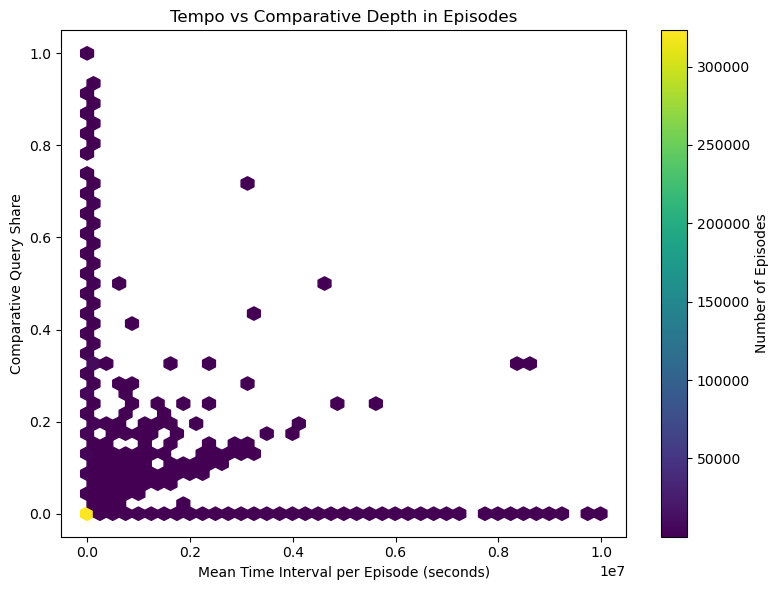

In [33]:
ep_beh = (
    df.groupby(['device_name_actual', 'q_episode'], dropna=False)
      .agg(
          episode_time_interval=('time_interval', 'mean'),
          comparative_rate=('comparative', lambda s: (s == 'comparative').mean()),
          n_queries=('search_q', 'size')
      )
      .reset_index()
)

ep_beh = ep_beh[ep_beh['n_queries'] >= 3]

plt.figure(figsize=(8, 6))
plt.hexbin(
    ep_beh['episode_time_interval'],
    ep_beh['comparative_rate'],
    gridsize=40, cmap='viridis', mincnt=1
)
plt.colorbar(label="Number of Episodes")
plt.xlabel("Mean Time Interval per Episode (seconds)")
plt.ylabel("Comparative Query Share")
plt.title("Tempo vs Comparative Depth in Episodes")
plt.tight_layout()
plt.show()


**Key Findings**
- The denser yellow cell at the bottom-left indicates that the most common pattern is fast, non‑comparative episodes

- There are scattered bins with higher comparative shares at short to moderate intervals, but no clear gradient in the colour scale along the x‑axis, suggesting that episode tempo does not systematically drive “comparative depth” once the overall rarity of comparative queries is taken into account.

**(f) Episode Tempo and Closure Success**

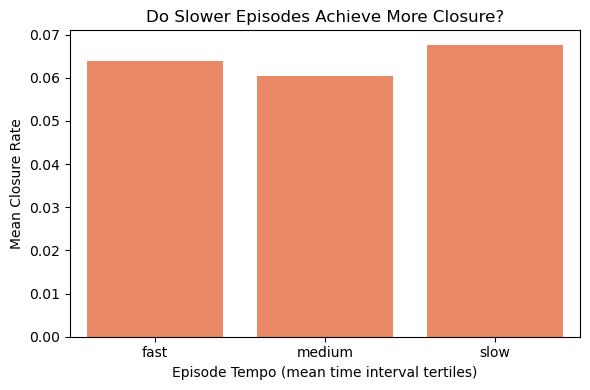

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_updated.copy()

ep = (
    df.groupby(['device_name_actual', 'q_episode'], dropna=False)
      .agg(
          episode_time_interval=('time_interval', 'mean'),
          closure_rate=('closure', lambda s: (s == 'closure').mean()),
          n_queries=('search_q', 'size')
      )
      .reset_index()
)

# drop trivially short episodes if you want (e.g. n_queries<2)
ep = ep[ep['n_queries'] >= 2]

# tempo bins
ep['tempo_bin'] = pd.qcut(ep['episode_time_interval'], q=3, labels=['fast', 'medium', 'slow'])

tempo_summary = (
    ep.groupby('tempo_bin')['closure_rate']
      .mean()
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=tempo_summary, x='tempo_bin', y='closure_rate', color='coral')
plt.xlabel("Episode Tempo (mean time interval tertiles)")
plt.ylabel("Mean Closure Rate")
plt.title("Do Slower Episodes Achieve More Closure?")
plt.tight_layout()
plt.show()


**Key Findings**
- The x‑axis groups episodes into fast, medium, and slow tempo tertiles based on mean time_interval, and the y‑axis plots the corresponding mean closure rate in each group.​

- Mean closure rate is low in all groups (around 6-7%), but there is a slight increase from about 0.061 in medium episodes to roughly 0.064 in fast episodes and 0.068 in slow episodes, suggesting that slower episodes may achieve closure marginally more often, although the effect size is small and closure behaviour remains broadly similar across pacing regimes.

#### (g) Reformulation Size Across Follow‑Up Delays

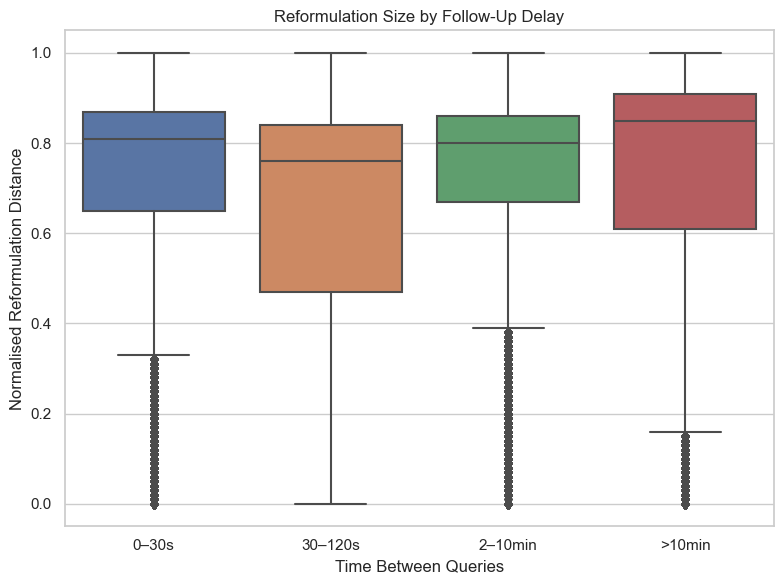

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_sub = df.copy()
df_sub = df_sub[df_sub['time_interval'].notna() & df_sub['reformulation_levenshtein_norm'].notna()]

# clip to 99th percentile
max_t = df_sub['time_interval'].quantile(0.99)
df_sub = df_sub[df_sub['time_interval'] <= max_t]

# bin time into categories
bins = [0, 30, 120, 600, max_t]  # 0–30s, 30–120s, 2–10min, >10min
labels = ['0–30s', '30–120s', '2–10min', '>10min']
df_sub['time_bin'] = pd.cut(df_sub['time_interval'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_sub,
    x='time_bin',
    y='reformulation_levenshtein_norm'
)
plt.xlabel("Time Between Queries")
plt.ylabel("Normalised Reformulation Distance")
plt.title("Reformulation Size by Follow-Up Delay")
plt.tight_layout()
plt.show()


**Key Findings**
- The medians are all high (around 0.75–0.9 normalised distance), with overlapping interquartile ranges, indicating that most follow‑ups are substantial rewrites regardless of delay, but there is a mild tendency for the very fastest (0–30s) to include more small edits (longer lower whisker) and the slowest (>10min) to skew slightly towards larger changes.

## 5.6 Feature 6: Total Time per Query Episode

**Time Total Feature**

The `time_total` feature captures the **total duration (in seconds) of a query episode**, computed as the sum of all `time_interval` values within the episode. This reflects the overall engagement time of a user during a single search session.

- The calculation is **grouped by user/session identifiers** (`school_name` + `device_name_actual` + `q_episode`) to ensure sums are computed **only within each query episode**.
- Episodes with a **single query** have `time_interval = 0`, so their `time_total` is also 0.
- Results are **rounded to 2 decimal places** for readability.
- The original dataframe order is preserved; the `time_total` column is added **without modifying other columns**.

---

**Episode Duration Calculation**

- For each query episode, sum the `time_interval` values for all queries in that episode:

$$
\text{time_total}_{episode} = \sum_{i=1}^{n} \text{time_interval}_i
$$

- All rows in the same episode receive the same `time_total` value, so each query in an episode knows the total duration of that session.

In [8]:
df_updated['time_total'] = (
    df_updated
    .groupby(['school_name', 'device_name_actual', 'q_episode'])['time_interval']
    .transform('sum')
    .round(2)
)

df_updated.head()


school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... user_question_rate  \
0            True           False        1.0  ...           0.097917   
1            True           False        2.0  ...           0.097917   
2           False           False        2.0  ...           0.097917   
3           False           False        2.0  ...           0.097917   
4           False           False        2.0  ...           0.097917   

       closure closure_words      comparative comparative_words  \
0  not_closure            []  not_comparative                []   
1  not_closure            []  not_comparative                []   
2  not_closure            []  not_comparative                []   
3  not_closure            []  not_comparative                []   
4  not_closure            []  not_comparative                []   

  reformulation_levenshtein  reformulation_levenshtein_norm  is_reformulation  \
0                         0                            0.00             False   
1                        29                            0.97              True   
2                         4                            0.12              True   
3                        17                            0.53              True   
4                        13                            0.41              True   

   time_interval  time_total  
0           0.00        0.00  
1          71.33      285.32  
2          71.33      285.32  
3          71.33      285.32  
4          71.33      285.32  

[5 rows x 21 columns]

#### (a) Distribution of Episode Duration (log-seconds) Across all users

In [73]:
ep = ep_time_all.copy()
ep = ep[ep['time_total'] > 0].copy()
ep['log10_time_total'] = np.log10(ep['time_total'])

plt.figure(figsize=(8, 5))
sns.histplot(
    data=ep,
    x='log10_time_total',
    bins=40,
    kde=True,
    color='#984ea3',   # purple
    edgecolor='white'
)
plt.xlabel("log10(Total Episode Time in seconds)")
plt.ylabel("Number of Episodes")
plt.title("Episode Duration (log scale) Across All Users")
plt.tight_layout()
plt.show()


**Key Findings**
- The main peak around log10 ≈ 2–2.5 means most episodes last roughly 102 - 102.5 seconds (ie. about 100–300 seconds or 1.5–5 minutes), so typical sessions are a few minutes long.​

- The left side shows some very short episodes and the right tail shows a small number of extremely long episodes (beyond 1 hour), confirming that episode time is highly right‑skewed with rare but very long sessions.

#### (b) Typical Episode Time vs Episode Length (1-20 Queries)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ep_stats from earlier
ep_stats = (
    df_updated
    .groupby(['device_name_actual', 'q_episode'], dropna=False)
    .agg(
        n_queries=('time_interval', 'size'),
        time_total=('time_total', 'first')
    )
    .reset_index()
)

# 1) keep episodes with, say, 1–20 queries
ep_stats_small = ep_stats[(ep_stats['n_queries'] >= 1) &
                          (ep_stats['n_queries'] <= 20)]

# 2) trim extreme durations (e.g. 99th percentile)
upper = ep_stats_small['time_total'].quantile(0.99)
ep_stats_small = ep_stats_small[ep_stats_small['time_total'] <= upper]

# 3) aggregate by n_queries
ep_trend = (
    ep_stats_small
    .groupby('n_queries')['time_total']
    .agg(
        median_time='median',
        q1=lambda s: s.quantile(0.25),
        q3=lambda s: s.quantile(0.75),
        count='size'
    )
    .reset_index()
)

# 4) plot
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=ep_trend,
    x='n_queries',
    y='median_time',
    marker='o'
)
plt.fill_between(
    ep_trend['n_queries'],
    ep_trend['q1'],
    ep_trend['q3'],
    alpha=0.2
)
plt.xlabel("Number of Queries in Episode (1–20)")
plt.ylabel("Median Total Episode Time (seconds)")
plt.title("Typical Episode Time vs Episode Length (Trimmed Range)")
plt.tight_layout()
plt.show()


**Key Findings**
- As episodes include more queries, typical episode time increases sharply from almost 0 seconds for single‑query episodes to about 600-700 seconds (roughly 10-12 minutes) when episodes have around 12017 queries.

- Then the curve flattens, so each additional query adds relatively little extra time, suggesting diminishing returns in time per extra query.

- The shaded band, which shows the middle 50 % of episodes, stays wide at all lengths (indicating large variation in duration even for the same query count), but both its top edge and the median line rise together up to around 12–17 queries and then stop growing much, meaning that even the longer‑than‑typical episodes do not become dramatically longer once episodes are already quite query‑heavy.



#### (c) Episode Duration Behaviour for Heavy Users

**(i) Distribution of Episode Time for Each Top User**

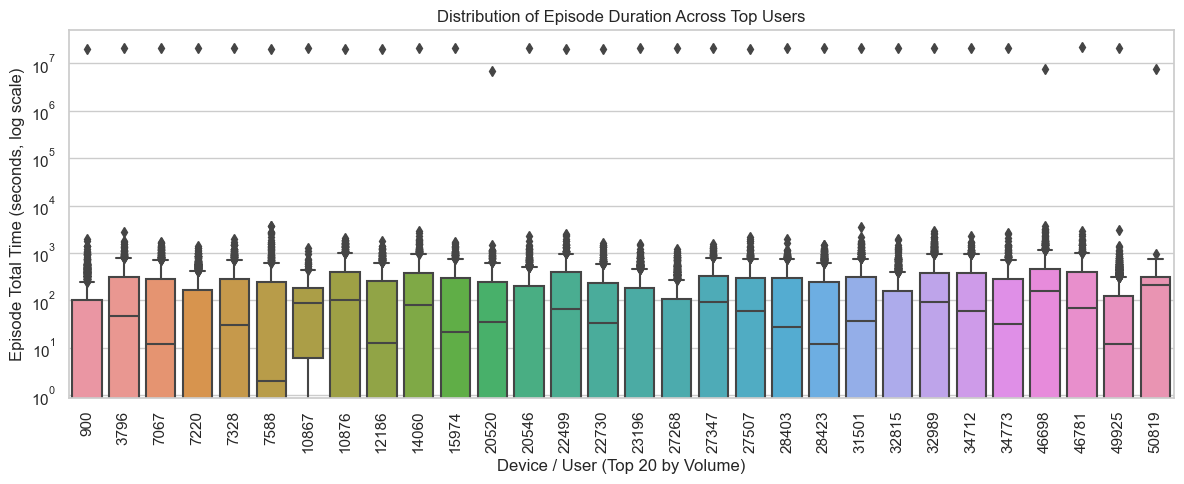

In [85]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=ep_all,
    x='device_name_actual',
    y='time_total'
)
plt.yscale('log')  # sessions often heavy-tailed
plt.xticks(rotation=90)
plt.xlabel("Device / User (Top 20 by Volume)")
plt.ylabel("Episode Total Time (seconds, log scale)")
plt.title("Distribution of Episode Duration Across Top Users")
plt.tight_layout()
plt.show()


**Key Findings**
- The first boxplot shows that most top users have similar typical episode durations once episodes are log‑scaled. Their medians cluster between about 
10 and 100 seconds, while every user has a long tail of rare, very long episodes reaching hours.​

- Differences between users are more in the spread than in the centre: some users have tighter boxes (more consistent episode times), while others have wider boxes and more extreme outliers, indicating more variable search sessions.


**(ii) Mix of Short vs Long Episodes for Each Top User**


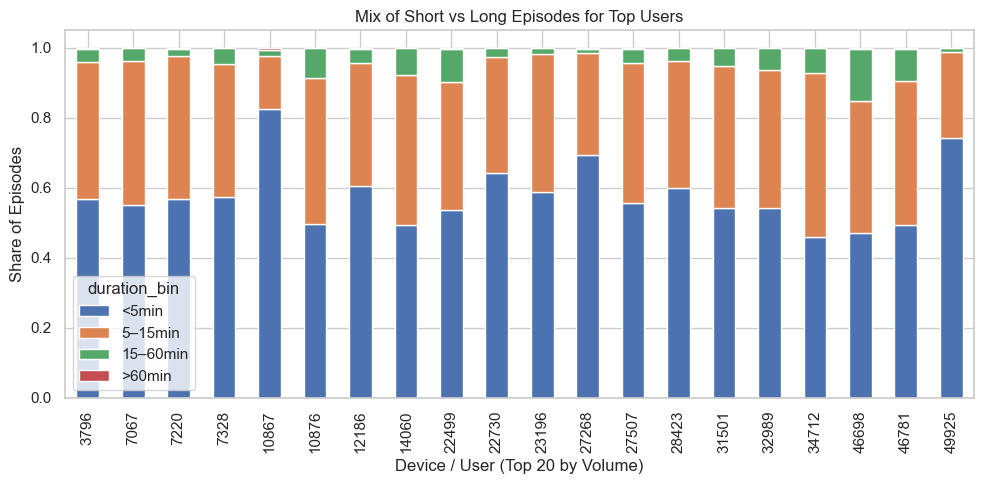

In [88]:
top_devices = df['device_name_actual'].value_counts().head(20).index

ep_all = (
    df[df['device_name_actual'].isin(top_devices)]
    .groupby(['device_name_actual', 'q_episode'], dropna=False)
    .agg(time_total=('time_total', 'first'))
    .reset_index()
)

bins = [0, 300, 900, 3600, np.inf]  # <5min, 5–15, 15–60, >60
labels = ['<5min', '5–15min', '15–60min', '>60min']
ep_all['duration_bin'] = pd.cut(ep_all['time_total'], bins=bins, labels=labels)

share = (
    ep_all.pivot_table(
        index='device_name_actual',
        columns='duration_bin',
        values='time_total',
        aggfunc='count',
        fill_value=0
    )
)
share = share.div(share.sum(axis=1), axis=0)

share.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel("Device / User (Top 20 by Volume)")
plt.ylabel("Share of Episodes")
plt.title("Mix of Short vs Long Episodes for Top Users")
plt.tight_layout()
plt.show()


**Key Findings**
- The stacked bars reveal that, for almost all top users, short episodes under 5 minutes dominate, with 5-15 minute episodes providing most of the remaining mass and only a small share extending beyond 15 minutes.​

- However, the height of the 15-60 minute and >60 minute segments varies across users, indicating that some heavy users spend a much larger fraction of their activity in long, deep sessions compared with others whose activity is mostly short bursts.


**(iii) Episode Duration By User Segment (Short/Medium/Long)**

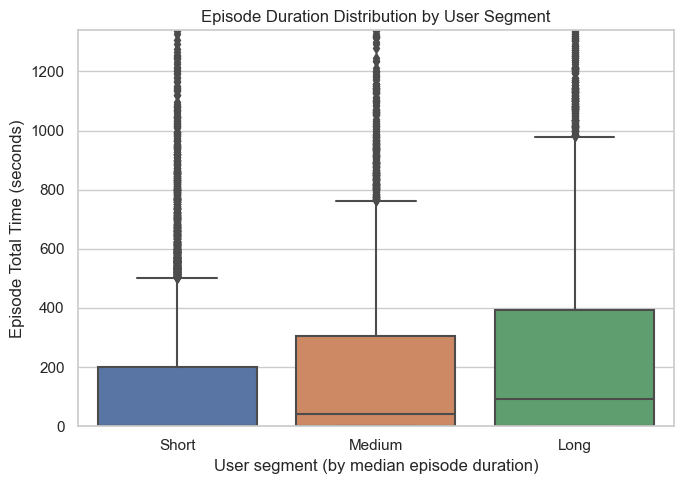

In [92]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    data=ep_all_lvl,
    x='dur_level',
    y='time_total'
)
plt.ylim(0, ep_all_lvl['time_total'].quantile(0.99))  # trim extreme tail
plt.xlabel("User segment (by median episode duration)")
plt.ylabel("Episode Total Time (seconds)")
plt.title("Episode Duration Distribution by User Segment")
plt.tight_layout()
plt.show()


**Key Findings**
- Typical session time shifts upward from Short to Long users. Short‑segment users (bottom third by median duration) usually have episodes under about 200 seconds, whereas medium users cluster around roughly 300 seconds and long‑segment users around 400 seconds or more, meaning the segmentation genuinely separates users by how long they tend to stay in a search episode.​

- Long‑segment users generate the heaviest tails. All groups have some very long episodes, but the whiskers and outliers extend much further for the Long segment; this suggests that the users whose typical sessions are already long are also the ones most likely to engage in occasional, extremely long search episodes, indicating a group of “deep‑dive” users who both often and sometimes intensely engage with search.​


#### (d)  Distribution of User Search Tempo (Median Seconds per Query)

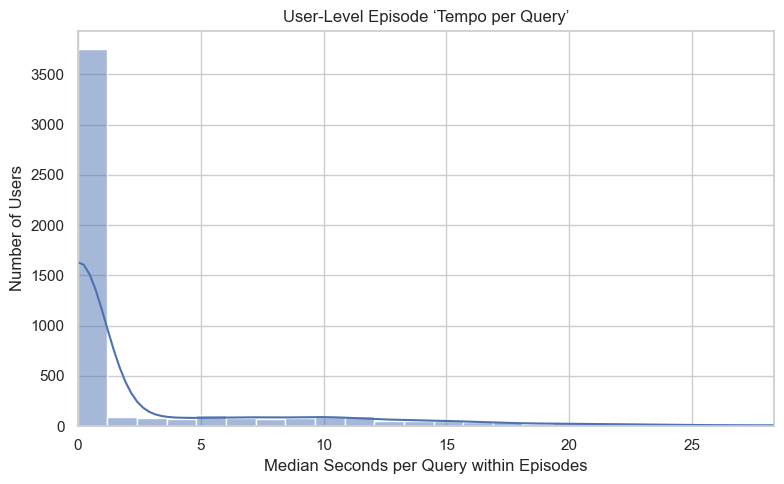

In [87]:
ep_stats = (
    df.groupby(['device_name_actual', 'q_episode'], dropna=False)
      .agg(
          time_total=('time_total', 'first'),
          n_queries=('search_q', 'size')
      )
      .reset_index()
)

# user-level slope: seconds per query
user_eff = (
    ep_stats.groupby('device_name_actual')
            .apply(lambda g: (g['time_total'] / g['n_queries']).median())
            .reset_index(name='median_seconds_per_query')
)

plt.figure(figsize=(8, 5))
sns.histplot(
    data=user_eff,
    x='median_seconds_per_query',
    bins=40,
    kde=True
)
plt.xlim(0, user_eff['median_seconds_per_query'].quantile(0.99))
plt.xlabel("Median Seconds per Query within Episodes")
plt.ylabel("Number of Users")
plt.title("User-Level Episode ‘Tempo per Query’")
plt.tight_layout()
plt.show()


**Key Findings**
- Most users operate at a very fast tempo, with median gaps of roughly 0-1 second between queries; this suggests that, during episodes, they fire off queries in rapid bursts, likely scanning results and refining searches rather than pausing for long stretches.​

- The long right tail indicates a smaller group of slower, more deliberate users whose median gap per query can exceed 10 seconds, implying that some individuals spend more time reading or thinking between searches, even though they are a minority compared with the fast‑tempo majority.



#### User Closure Orientation vs Typical Episode Time

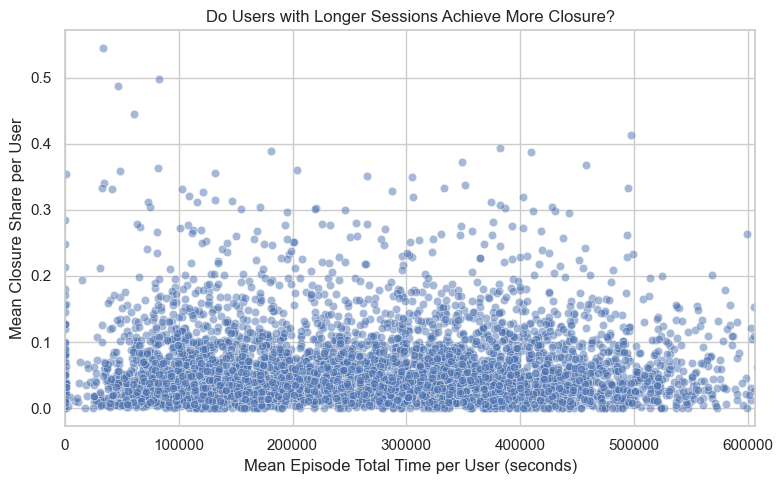

In [89]:
ep_beh_user = (
    ep_beh.groupby('device_name_actual')
          .agg(
              mean_time_total=('time_total', 'mean'),
              mean_closure_share=('closure_share', 'mean'),
              mean_comp_share=('comp_share', 'mean')
          )
          .reset_index()
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ep_beh_user,
    x='mean_time_total',
    y='mean_closure_share',
    alpha=0.5
)
plt.xlim(0, ep_beh_user['mean_time_total'].quantile(0.99))
plt.xlabel("Mean Episode Total Time per User (seconds)")
plt.ylabel("Mean Closure Share per User")
plt.title("Do Users with Longer Sessions Achieve More Closure?")
plt.tight_layout()
plt.show()


**Key Findings**
- The plot shows that how long users’ episodes typically last is largely unrelated to how closure‑oriented they are.​

- Across the whole x‑axis, most users have a mean closure share below about 0.2, and the cloud does not slope upward or downward, indicating that users with long average episode times are not consistently more (or less) likely to issue closure queries than users with short episodes.​

- A small number of users reach high closure shares (above 0.4) at many different mean‑time values, suggesting that closure behaviour is mainly an individual habit or style rather than something driven by having longer sessions.



## 5.7 Feature 7: Number of Queries Per Query Episode

**Query Count Feature**

The `num_query_episode` feature captures the **number of queries submitted within a single query episode**. This feature reflects the depth and intensity of a user’s search behaviour during one session: **higher values indicate more iterative or exploratory querying**, while **lower values suggest more concise search behaviour**.

- The calculation is grouped by user/session identifiers (`school_name` + `device_name_actual` + `q_episode`) to ensure counts are computed only within the same query episode.
- Each query within the same episode is assigned the same query count, allowing every row to be aware of the episode’s total query volume.
- All rows in the same episode receive the same `num_query_episode` value, enabling downstream analyses to jointly consider query depth, time-based engagement (`time_interval`, `time_total`), and reformulation behaviour.

In [21]:
df_updated['num_query_episode'] = (
    df_updated
    .groupby(['school_name', 'device_name_actual', 'q_episode'])['q_episode']
    .transform('count')
)

df_updated.head()


school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ...      closure  closure_words  \
0            True           False        1.0  ...  not_closure             []   
1            True           False        2.0  ...  not_closure             []   
2           False           False        2.0  ...  not_closure             []   
3           False           False        2.0  ...  not_closure             []   
4           False           False        2.0  ...  not_closure             []   

       comparative comparative_words reformulation_levenshtein  \
0  not_comparative                []                         0   
1  not_comparative                []                        29   
2  not_comparative                []                         4   
3  not_comparative                []                        17   
4  not_comparative                []                        13   

  reformulation_levenshtein_norm  is_reformulation  time_interval  time_total  \
0                           0.00             False           0.00        0.00   
1                           0.97              True          71.33      285.32   
2                           0.12              True          71.33      285.32   
3                           0.53              True          71.33      285.32   
4                           0.41              True          71.33      285.32   

   num_query_episode  
0                1.0  
1                4.0  
2                4.0  
3                4.0  
4                4.0  

[5 rows x 22 columns]

#### (a) Distribution of Typical Episode Depth per User

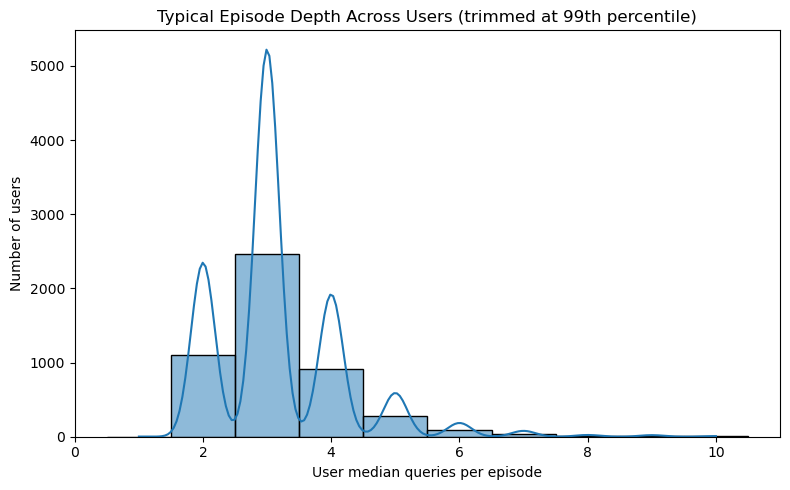

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# user-level typical depth
user_depth = (
    df_updated
    .groupby('device_name_actual')['num_query_episode']
    .median()
    .reset_index(name='median_ep_queries')
)

# cap at, say, 99th percentile to remove extreme outliers
upper = user_depth['median_ep_queries'].quantile(0.99)
user_depth_trim = user_depth[user_depth['median_ep_queries'] <= upper]

plt.figure(figsize=(8, 5))
sns.histplot(
    data=user_depth_trim,
    x='median_ep_queries',
    bins=np.arange(0.5, upper + 1.5, 1),  # 1-query wide bins
    kde=True
)
plt.xlabel("User median queries per episode")
plt.ylabel("Number of users")
plt.title("Typical Episode Depth Across Users (trimmed at 99th percentile)")
plt.tight_layout()
plt.show()


**Key Findings**

- The distribution of users’ typical episode depth is right‑skewed, with most users having relatively shallow episodes and a minority exhibiting much deeper episodes, a pattern common in engagement metrics such as session depth.​

- Most users cluster around 2-4 median queries per episode, with a clear peak near 3; this suggests that a “typical” user tends to issue only a small number of queries in a session-like episode.

- There is a right‑skewed tail extending beyond 5 queries per episode, indicating a minority of users who routinely run longer, more exploratory episodes.

- Trimming at the 99th percentile ensures that extreme outliers do not dominate the visualisation, making this figure suitable for describing “typical” user behaviour while still showing meaningful variation in depth.



#### (b) Search Effort by Episode: Query Volume vs Total Episode Time

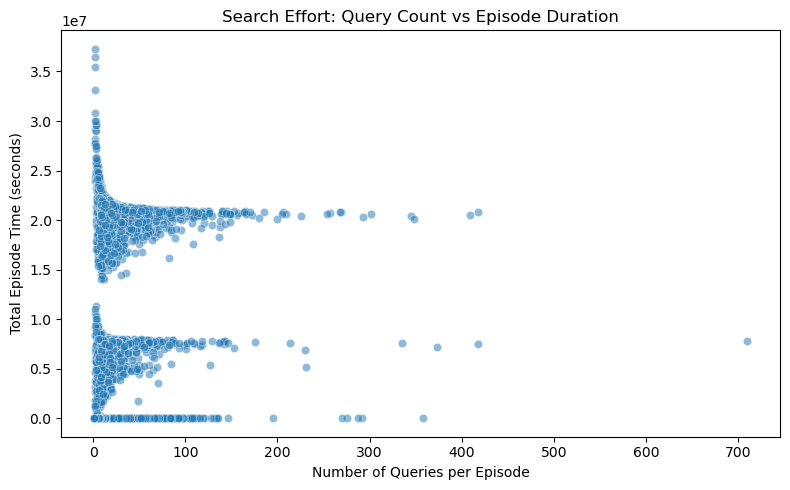

In [24]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ep_queries,
    x='num_query_episode',
    y='time_total',
    alpha=0.5
)

plt.xlabel("Number of Queries per Episode")
plt.ylabel("Total Episode Time (seconds)")
plt.title("Search Effort: Query Count vs Episode Duration")
plt.tight_layout()
plt.show()


**Key Findings**
- There is a positive association between query count and episode duration: episodes with more queries generally last longer, providing evidence that higher query volume corresponds to greater search effort at the episode level.​

- The wide vertical spread of points at low query counts (eg. 1-20 queries) is evidence that episodes with similar query volumes can differ greatly in duration, indicating heterogeneous behaviours such as quick task completion versus long idle or reading time within short episodes.​

- The dots line up in horizontal stripes, meaning many episodes end at the same few duration values rather than at completely random times. This pattern is evidence that something in the system or in user habits is creating those “preferred” durations. 
    - For example, there might be a standard timeout (eg. session ends after X seconds), a logging limit (only record up to Y seconds), or groups of users who tend to spend similar amounts of time per episode. 
    - In other words, technical rules or consistent user routines are forcing episode lengths into a few common values, instead of a smooth spread of times.



#### (c) Episode Depth Patterns Across High‑Activity Devices

**(i) Distribution of Episode Depth for Top Devices**

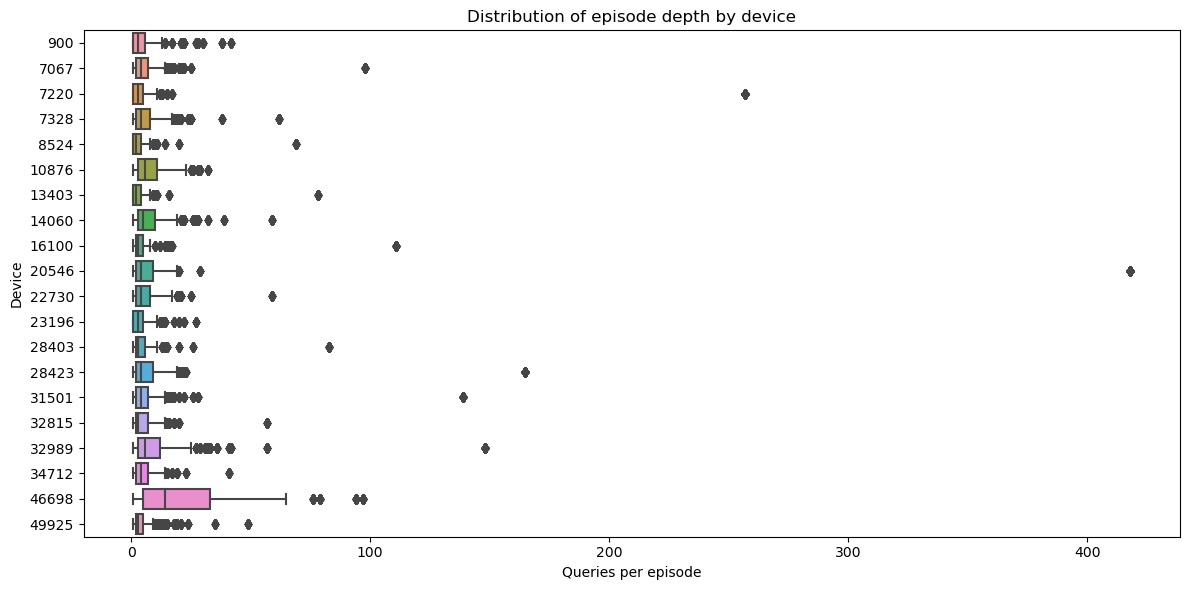

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top,
    x='num_query_episode',
    y='device_name_actual',
    orient='h'
)

plt.xlabel("Queries per episode")
plt.ylabel("Device")
plt.title("Distribution of episode depth by device")
plt.tight_layout()
plt.show()


**Key Findings**
- For most devices, the middle 50% of episodes are quite shallow, with boxes concentrated below roughly 20 queries per episode, indicating that typical sessions for these heavy users still involve relatively short query sequences.

- Several devices (for example, those with noticeably wider boxes) have more variable episode depth, meaning the same user alternates between very short and substantially longer episodes, consistent with mixed task types or changing information needs.​

- There are extreme outlier episodes on multiple devices, with some boxes accompanied by points stretching well beyond 100, 200, and even 400 queries per episode. These represent rare but very high‑effort episodes that could disproportionately influence averages and may warrant separate analysis or filtering.​

- Differences in median line position across devices show that some users consistently run deeper episodes than others, suggesting persistent individual differences in search strategy or workload rather than purely random variation.



**(ii) Episode Depth Over Time for Top 20 Devices**

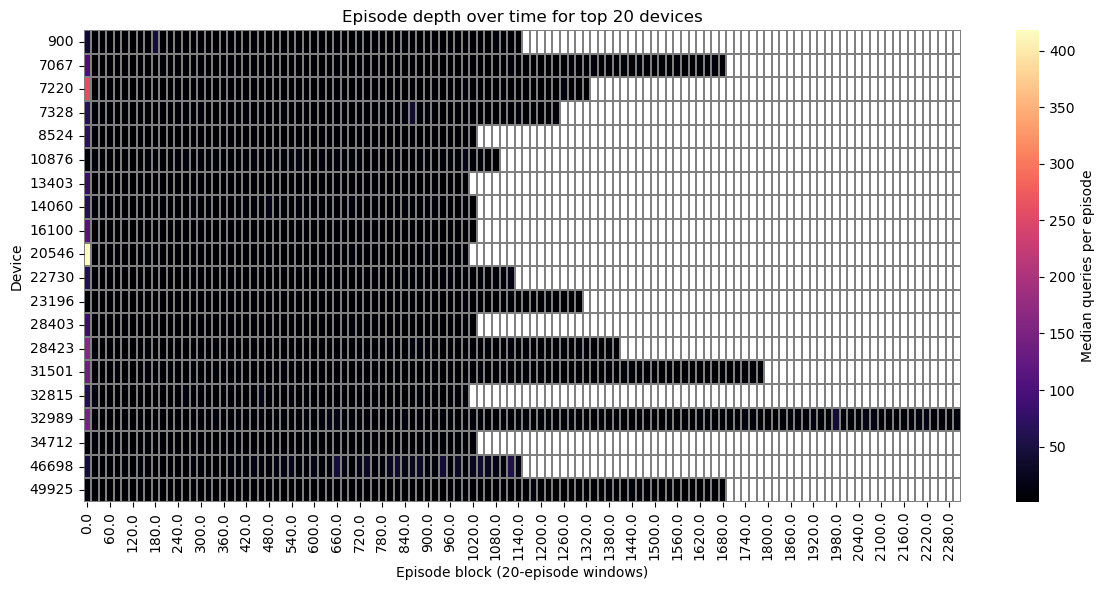

In [47]:
# Top 20 users
top_users = (
    df_updated.groupby('device_name_actual')['q_episode']
    .nunique()
    .sort_values(ascending=False)
    .head(20)
    .index
)

df_top = df_updated[df_updated['device_name_actual'].isin(top_users)].copy()

# Episode blocks of 20
df_top['episode_block'] = (df_top['q_episode'] // 20) * 20

# Aggregate: median queries per episode for each user–block
agg = (
    df_top.groupby(['device_name_actual', 'episode_block'])['num_query_episode']
    .median()
    .reset_index()
)

# Pivot to user × block matrix
heat = agg.pivot(
    index='device_name_actual',     # rows = users
    columns='episode_block',        # columns = time blocks
    values='num_query_episode'      # cell = median depth
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heat,
    cmap='magma',
    linewidths=0.3,
    linecolor='grey',
    cbar_kws={'label': 'Median queries per episode'}
)

plt.xlabel("Episode block (20-episode windows)")
plt.ylabel("Device")
plt.title("Episode depth over time for top 20 devices")
plt.tight_layout()
plt.show()


**Key Findings**
- Almost all cells are very dark (low median queries), showing that even among the top 20 devices, typical episodes remain shallow across most of their lifetimes.

- A few devices have bright cells in early blocks (eg. around episode block 0-40), indicating rare periods where median episode depth spikes dramatically, likely driven by one or a few very deep episodes within those windows.

- Some rows extend much further to the right than others, revealing that certain devices accumulate far more episodes than others, which is useful context when interpreting user‑level engagement as not all “top” devices are equally long‑lived.


#### (d) Change in Episode Depth Over Time (Device 36719)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '20.0'),
  Text(2, 0, '40.0'),
  Text(3, 0, '60.0'),
  Text(4, 0, '80.0'),
  Text(5, 0, '100.0'),
  Text(6, 0, '120.0'),
  Text(7, 0, '140.0'),
  Text(8, 0, '160.0'),
  Text(9, 0, '180.0'),
  Text(10, 0, '200.0'),
  Text(11, 0, '220.0'),
  Text(12, 0, '240.0')])

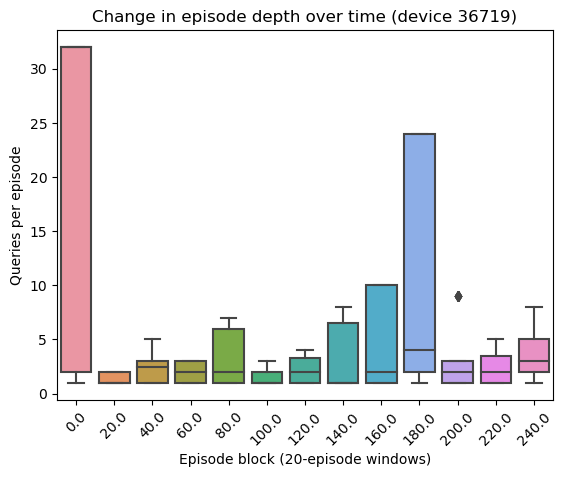

In [42]:
# e.g. bin episodes into chunks of 20
df_tmp = df_updated[df_updated['device_name_actual'] == one_device].copy()
df_tmp['episode_block'] = (df_tmp['q_episode'] // 20) * 20

sns.boxplot(
    data=df_tmp,
    x='episode_block',
    y='num_query_episode'
)
plt.xlabel("Episode block (20-episode windows)")
plt.ylabel("Queries per episode")
plt.title(f"Change in episode depth over time (device {one_device})")
plt.xticks(rotation=45)



**Key Findings**
- Episode depth is highly variable in early blocks, with the first 20 episodes including some very deep sessions (>30 queries), showing exploratory or heavy‑effort behaviour at the start.

- After the initial block, most episode blocks have low median depth (around 2–4 queries), indicating that typical sessions for this device are short, though variability increases again around blocks 160–180 where some longer episodes reappear.

- Outliers in later blocks (for example around 180–200) show that occasional high‑effort episodes persist, but they are rare compared with the large number of shallow episodes, a pattern box plots are designed to highlight effectively.​



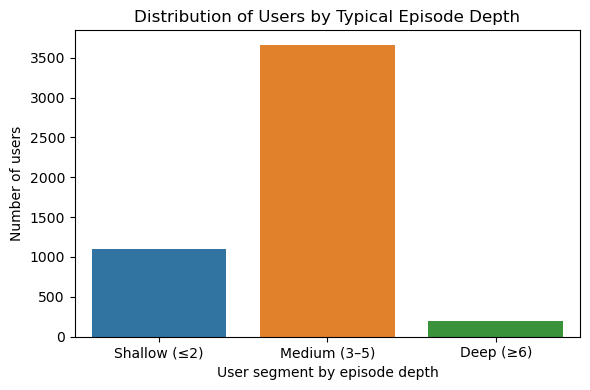

In [32]:
bins = [0, 2, 5, user_depth['median_ep_queries'].max()]
labels = ['Shallow (≤2)', 'Medium (3–5)', 'Deep (≥6)']

user_depth['depth_segment'] = pd.cut(
    user_depth['median_ep_queries'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(6, 4))
sns.countplot(data=user_depth, x='depth_segment')
plt.xlabel("User segment by episode depth")
plt.ylabel("Number of users")
plt.title("Distribution of Users by Typical Episode Depth")
plt.tight_layout()
plt.show()



**Key Findings**
- Median episode depth is split into:
    1. 0-2 queries → Shallow (≤2)
    2. 2-5 queries → Medium (3–5)
    3. 5 up to the maximum → Deep (≥6)

- The medium‑depth segment (3-5 queries) contains the majority of users, indicating that most people typically issue a small handful of queries per episode rather than just one or two or very long chains.

- A substantial but smaller number of users fall into the shallow (≤2) segment, showing that a meaningful group tends to complete tasks with extremely short episodes.

- The deep (≥6) segment is comparatively tiny, confirming that users who habitually run long, multi‑query episodes are rare and form a distinct high‑effort minority in the population.


#### (f) Closure Orientation as Episodes Get Deeper

**(i) Distribution of Closure Orientation by Episode Depth**

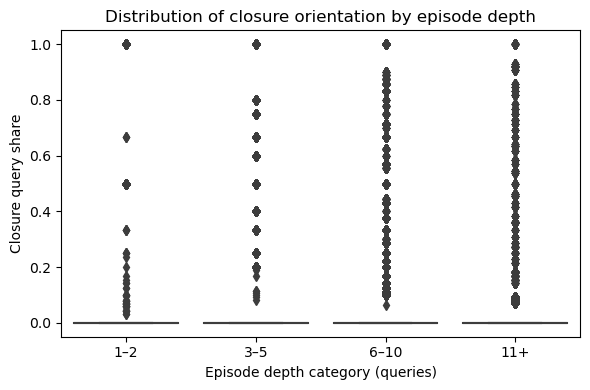

In [49]:
# Coarser bins for easier interpretation
ep_level['depth_cat'] = pd.cut(
    ep_level['num_queries'],
    bins=[1, 2, 5, 10, ep_level['num_queries'].quantile(0.99)],
    labels=['1–2', '3–5', '6–10', '11+'],
    include_lowest=True
)

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=ep_level,
    x='depth_cat',
    y='closure_share'
)
plt.xlabel("Episode depth category (queries)")
plt.ylabel("Closure query share")
plt.title("Distribution of closure orientation by episode depth")
plt.tight_layout()
plt.show()


**Key Findings**
- At every depth category (1–2, 3–5, 6–10, 11+ queries), closure share spans a wide range from near 0 to near 1, showing high variability in how closure‑oriented episodes are, regardless of length.​

- Deeper categories (6–10 and 11+) contain more episodes with high closure share (dense points near the top), suggesting that longer episodes more often include many closure queries, but this is not universal.




**ii. Closure Orientatino by Episode Depth (Binned Mean)**

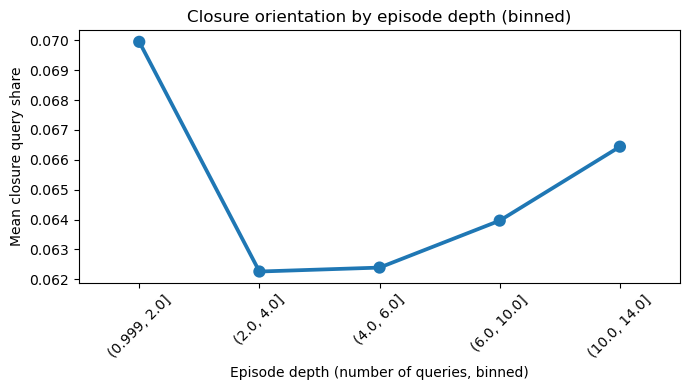

In [52]:
# 1. Build episode-level table (as you had)
ep_level = (
    df_updated
    .groupby(['device_name_actual', 'q_episode'])
    .agg(
        num_queries=('num_query_episode', 'first'),
        time_total=('time_total', 'first'),
        closure_share=('closure', lambda s: (s == 'closure').mean())
    )
    .reset_index()
)

# 2. Define monotonic bins for episode depth
q99 = ep_level['num_queries'].quantile(0.99)

# ensure the last edge is strictly larger than the previous one
last_edge = max(10, q99)

bins = [1, 2, 4, 6, 10, last_edge]

ep_level['depth_bin'] = pd.cut(
    ep_level['num_queries'],
    bins=bins,
    include_lowest=True
)

# 3. Aggregate closure share within each bin
depth_stats = (
    ep_level
    .groupby('depth_bin')['closure_share']
    .agg(['mean', 'median', 'count'])
    .reset_index()
)

# 4. Plot: mean closure share by depth bin
plt.figure(figsize=(7, 4))
sns.pointplot(
    data=depth_stats,
    x='depth_bin',
    y='mean'
)
plt.xlabel("Episode depth (number of queries, binned)")
plt.ylabel("Mean closure query share")
plt.title("Closure orientation by episode depth (binned)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Key Findings**
- On average, very shallow episodes (≤2 queries) have the highest closure share, followed by a dip for 3–6‑query episodes, then a gradual increase again for deeper episodes.

- This U‑shaped pattern suggests two distinct ways to reach closure: either quickly in a very short episode or after a longer, more exploratory sequence, while mid‑length episodes are least closure‑heavy on average.


#### g. Comparative Orientation as Episodes Get Deeper

**(i) Distribution of Comparative Orientation by Episode Depth**


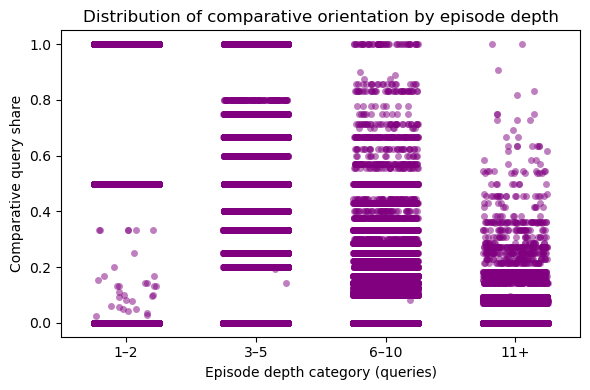

In [55]:
# 0. Build episode-level table WITH comparative_share
ep_level = (
    df_updated
    .groupby(['device_name_actual', 'q_episode'])
    .agg(
        num_queries=('num_query_episode', 'first'),
        time_total=('time_total', 'first'),
        closure_share=('closure', lambda s: (s == 'closure').mean()),
        comparative_share=('comparative', lambda s: (s == 'comparative').mean())
    )
    .reset_index()
)

# 1. Depth categories (same as before)
ep_level['depth_cat'] = pd.cut(
    ep_level['num_queries'],
    bins=[1, 2, 5, 10, ep_level['num_queries'].quantile(0.99)],
    labels=['1–2', '3–5', '6–10', '11+'],
    include_lowest=True
)

# 2. (Optional) jittered distribution by category
plt.figure(figsize=(6, 4))
sns.stripplot(
    data=ep_level,
    x='depth_cat',
    y='comparative_share',
    jitter=0.25,
    alpha=0.5,
    color='purple'
)
plt.xlabel("Episode depth category (queries)")
plt.ylabel("Comparative query share")
plt.title("Distribution of comparative orientation by episode depth")
plt.tight_layout()
plt.show()

**Key Findings**
- Within each depth band (1–2, 3–5, 6–10, 11+ queries), comparative share ranges from 0 to 1, showing high variability in how strongly episodes emphasise comparisons regardless of length.

- Deeper episodes (especially 6–10 and 11+) contain many more points with moderate to high comparative share, indicating that comparative behaviour is more common in longer episodes even though low‑comparative deep episodes still exist.


**(ii) Mean Comparative Orientation by Episode Depth (Binned)**

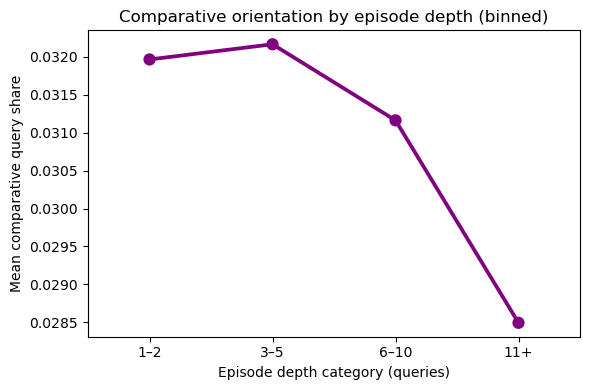

In [56]:
# 3. Mean comparative share by depth bin (main summary)
depth_stats_comp = (
    ep_level
    .groupby('depth_cat')['comparative_share']
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.pointplot(
    data=depth_stats_comp,
    x='depth_cat',
    y='comparative_share',
    color='purple'
)
plt.xlabel("Episode depth category (queries)")
plt.ylabel("Mean comparative query share")
plt.title("Comparative orientation by episode depth (binned)")
plt.tight_layout()
plt.show()

**Key Findings**
- Average comparative share is highest in short to medium episodes (1–5 queries) and then gradually declines as episodes get deeper.

- The drop in the 11+ category suggests that, on average, very deep episodes are not more comparative overall, even though the distribution plot shows that some individual deep episodes are highly comparative.


#### (h) Question Orientation as Episodes Get Deeper
**(i) Distribution of Question Use By Episode Depth**

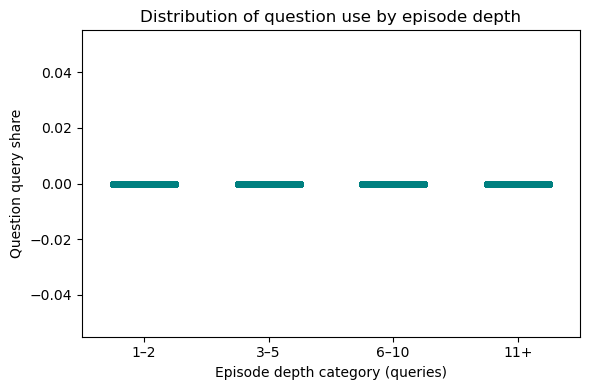

In [58]:
# 0. Episode-level table with question_share added
ep_level = (
    df_updated
    .groupby(['device_name_actual', 'q_episode'])
    .agg(
        num_queries      = ('num_query_episode', 'first'),
        time_total       = ('time_total', 'first'),
        closure_share    = ('closure',     lambda s: (s == 'closure').mean()),
        comparative_share= ('comparative', lambda s: (s == 'comparative').mean()),
        question_share   = ('regex',       lambda s: (s == 'Question').mean())
    )
    .reset_index()
)

# 1. Depth categories (re-use same bins as closure/comparative)
ep_level['depth_cat'] = pd.cut(
    ep_level['num_queries'],
    bins=[1, 2, 5, 10, ep_level['num_queries'].quantile(0.99)],
    labels=['1–2', '3–5', '6–10', '11+'],
    include_lowest=True
)

# 2. (Optional) jittered distribution
plt.figure(figsize=(6, 4))
sns.stripplot(
    data=ep_level,
    x='depth_cat',
    y='question_share',
    jitter=0.25,
    alpha=0.5,
    color='teal'
)
plt.xlabel("Episode depth category (queries)")
plt.ylabel("Question query share")
plt.title("Distribution of question use by episode depth")
plt.tight_layout()
plt.show()

**Key Findings**
- Every point sits exactly at zero on the y‑axis for all depth categories (1–2, 3–5, 6–10, 11+), showing that the question query share is 0 in every episode under the current regex rule.

- This indicates that the heuristic for detecting questions almost never flags a query as a question, so this plot does not reveal any meaningful relationship between episode depth and question use.


**(ii) Question Orientation By Episode Depth (Binned)**

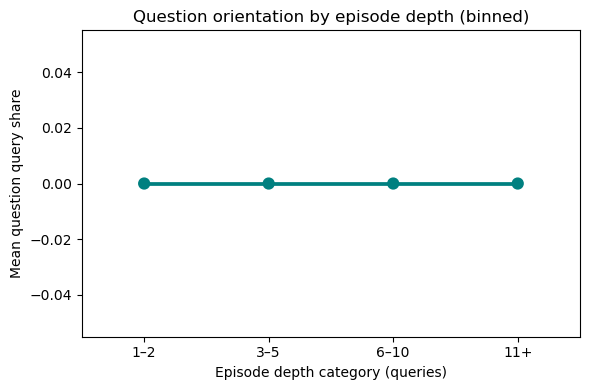

In [59]:
# 3. Mean question share by depth bin (main summary)
depth_stats_q = (
    ep_level
    .groupby('depth_cat')['question_share']
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.pointplot(
    data=depth_stats_q,
    x='depth_cat',
    y='question_share',
    color='teal'
)
plt.xlabel("Episode depth category (queries)")
plt.ylabel("Mean question query share")
plt.title("Question orientation by episode depth (binned)")
plt.tight_layout()
plt.show()


**Key Findings**
- The mean question share is flat at 0 across all depth bins, confirming that on average, episodes of all lengths contain no queries recognised as questions by the regex detector.


#### (i) Reformulation Intensity as Episodes Get Deeper


In [ ]:
# add reformulation share and mean time_interval
ep_level2 = (
    df_updated
    .groupby(['device_name_actual', 'q_episode'], dropna=False)
    .agg(
        num_queries=('num_query_episode', 'first'),
        time_total=('time_total', 'first'),
        mean_interval=('time_interval', 'mean'),
        reform_share=('is_reformulation', 'mean'),
    )
    .reset_index()
)

max_q2 = ep_level2['num_queries'].quantile(0.99)
ep_trim2 = ep_level2[ep_level2['num_queries'] <= max_q2]

# -------- Depth vs reformulation share --------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ep_trim2,
    x='num_queries',
    y='reform_share',
    alpha=0.3
)
plt.xlabel("Number of queries in episode")
plt.ylabel("Reformulation share")
plt.title("Episode Depth vs Reformulation Intensity")
plt.tight_layout()
plt.show()


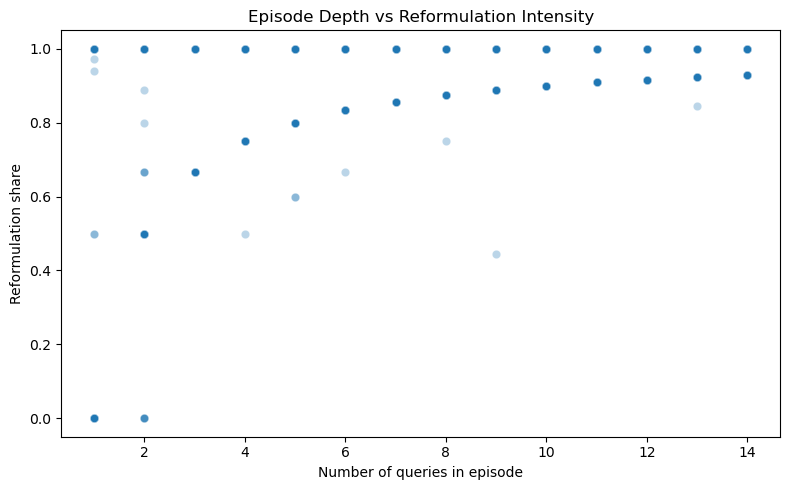

**Key Findings**
- For shallow episodes (1–3 queries), reformulation share ranges from 0 up to 1, but many points are below 0.8, meaning short episodes can be either mostly fresh queries or mostly reformulations.

- As episode depth increases, points cluster very close to the top of the scale (≈0.9–1.0), indicating that longer episodes are dominated by reformulation queries rather than entirely new intents.

- This pattern suggests that deep episodes are typically users iterating on the same underlying task, refining or rephrasing queries many times rather than launching many distinct tasks within one episode.



#### (j) Episode Depth vs Tempo per Query

In [ ]:
# -------- Depth vs mean inter-query interval --------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ep_trim2,
    x='num_queries',
    y='mean_interval',
    alpha=0.3,
    color='orange'
)
plt.ylim(0, ep_trim2['mean_interval'].quantile(0.99))
plt.xlabel("Number of queries in episode")
plt.ylabel("Mean inter-query time (seconds)")
plt.title("Episode Depth vs Tempo per Query")
plt.tight_layout()
plt.show()

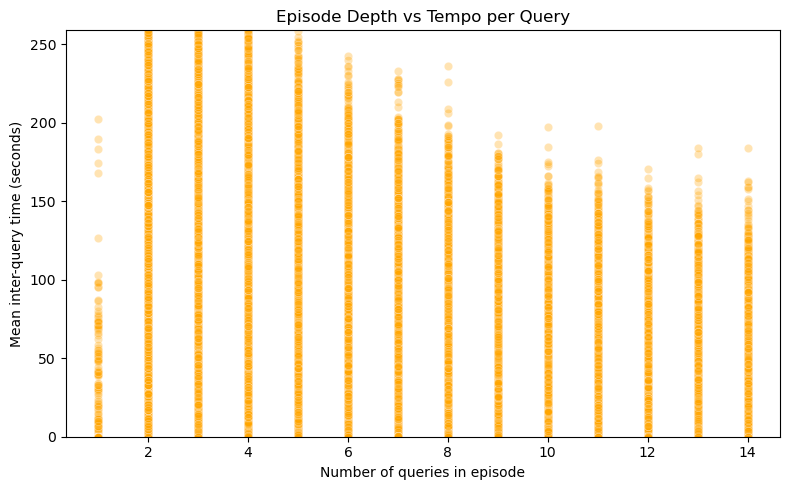

**Key Findings**
- For every depth value from 1 to 14 queries, there is a wide vertical spread of mean inter‑query times, indicating large variability in pacing even among episodes with the same number of queries.

- The upper envelope of points tends to decline slightly with greater depth (fewer very slow episodes at high depths), suggesting that deeper episodes are more often associated with faster, more continuous querying, while very slow, spaced‑out behaviour is more common in shallow episodes.



## 5.8 Feature 8: Open, Non-Possibility Type Questions (O_NP)

**O_NP Feature**

The O_NP feature identifies queries that are **open-ended questions** and **not framed as hypothetical or possibility questions**. This captures the intent of a user to ask factual or descriptive questions rather than asking about potential or conditional scenarios.

- The calculation is based on the first two tokens of the query (`search_q`) to determine the type of question.
- Open tokens: (`'who'`, `'when'`, `'what'`, `'where'`, `'how'`, `'why'`)
- Possibility tokens (to exclude): (`'can'`, `'may'`, `'might'`, `'could'`, `'would'`, `'if'`, `'will'`)
- Queries that start with an **open token** and **do not include any possibility token in the first two words** are flagged as `O_NP = True`.

- All other queries are flagged as `O_NP = False`.

---
**Processing Logic**
- **Token Extraction and Rule Application**
    - Each query is converted to lowercase (`str.lower()`) for consistent token matching.
    - The first two tokens of each query are extracted using `str.split(n=2)` and slicing (`x[:2]`).
    - `cond_open` checks if the first token is in the open tokens list.

    - `cond_no_poss` checks that none of the first two tokens are in the possibility tokens list.

    - The row is flagged `O_NP = True` only if both conditions are satisfied (`cond_open` & `cond_no_poss`).
    
---
**Example**
| search_q                         | O_NP  |
| -------------------------------- | ----- |
| "What is the capital of France?" | True  |
| "Can we travel to Mars?"         | False |
| "Why do cats purr?"              | True  |
| "Will it rain tomorrow?"         | False |
| "How does photosynthesis work?"  | True  |
- Queries flagged as `True` satisfy the open-ended, non-possibility question rule.

- Queries flagged as `False` are either possibility questions or non-open questions.


In [202]:
df = pd.read_csv('/Users/tdf/Downloads/df_updated_surface_deep_final.csv')
df.head()

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_85201/4240931661.py:1: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/tdf/Downloads/df_updated_surface_deep_final.csv')


school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ...      closure  closure_words  \
0            True           False        1.0  ...  not_closure             []   
1            True           False        2.0  ...  not_closure             []   
2           False           False        2.0  ...  not_closure             []   
3           False           False        2.0  ...  not_closure             []   
4           False           False        2.0  ...  not_closure             []   

       comparative comparative_words reformulation_levenshtein  \
0  not_comparative                []                         0   
1  not_comparative                []                        29   
2  not_comparative                []                         4   
3  not_comparative                []                        17   
4  not_comparative                []                        13   

  reformulation_levenshtein_norm  is_reformulation  time_interval  time_total  \
0                           0.00             False           0.00        0.00   
1                           0.97              True          71.33      285.32   
2                           0.12              True          71.33      285.32   
3                           0.53              True          71.33      285.32   
4                           0.41              True          71.33      285.32   

   num_query_episode  
0                1.0  
1                4.0  
2                4.0  
3                4.0  
4                4.0  

[5 rows x 22 columns]

In [203]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Tokens for the rule
open_tokens = ('who', 'when', 'what', 'where', 'how', 'why')
possibility_tokens = ('can', 'may', 'might', 'could', 'would', 'if', 'will')

# Output column initialization
df['O_NP'] = False  # default False

# Set chunk size (adjust if needed)
chunksize = 100_000
total_rows = len(df)

for start in tqdm(range(0, total_rows, chunksize), desc="Processing chunks for O_NP"):
    end = min(start + chunksize, total_rows)
    chunk_index = df.index[start:end]

    # Slice the chunk
    chunk = df.loc[chunk_index, 'search_q'].astype(str).str.lower()

    # Extract first two tokens
    first_two = chunk.str.split(n=2).apply(lambda x: x[:2])

    # Apply conditions
    cond_open = first_two.apply(lambda x: x[0] in open_tokens if len(x) > 0 else False)
    cond_no_poss = first_two.apply(lambda x: all(tok not in possibility_tokens for tok in x))

    # Assign to main dataframe
    df.loc[chunk_index, 'O_NP'] = cond_open & cond_no_poss

print("Completed! 'O_NP' column added.")
df.head()


Processing chunks for O_NP: 100%|███████████████| 34/34 [00:46<00:00,  1.37s/it]

Completed! 'O_NP' column added.


school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... closure_words  \
0            True           False        1.0  ...            []   
1            True           False        2.0  ...            []   
2           False           False        2.0  ...            []   
3           False           False        2.0  ...            []   
4           False           False        2.0  ...            []   

       comparative comparative_words reformulation_levenshtein  \
0  not_comparative                []                         0   
1  not_comparative                []                        29   
2  not_comparative                []                         4   
3  not_comparative                []                        17   
4  not_comparative                []                        13   

  reformulation_levenshtein_norm is_reformulation  time_interval  time_total  \
0                           0.00            False           0.00        0.00   
1                           0.97             True          71.33      285.32   
2                           0.12             True          71.33      285.32   
3                           0.53             True          71.33      285.32   
4                           0.41             True          71.33      285.32   

   num_query_episode   O_NP  
0                1.0  False  
1                4.0  False  
2                4.0  False  
3                4.0  False  
4                4.0  False  

[5 rows x 23 columns]

In [204]:
import pandas as pd
from tqdm import tqdm

# Reset index just to be safe
df = df.reset_index(drop=True)

# Initialize columns
df['tokens'] = None
df['n_tokens'] = 0

# Chunk size for scalability
chunksize = 100_000
total_rows = len(df)

for start in tqdm(range(0, total_rows, chunksize), desc="Processing tokens"):
    end = min(start + chunksize, total_rows)
    
    # Extract query text in lowercase
    q = df.loc[start:end-1, 'search_q'].astype(str).str.lower()
    
    # Split by whitespace to get tokens
    tokens_list = q.str.split()
    
    # Assign tokens list
    df.loc[start:end-1, 'tokens'] = tokens_list
    
    # Compute number of tokens
    df.loc[start:end-1, 'n_tokens'] = tokens_list.apply(len)

# Check
df.head()


Processing tokens: 100%|████████████████████████| 34/34 [00:23<00:00,  1.45it/s]


school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... comparative_words  \
0            True           False        1.0  ...                []   
1            True           False        2.0  ...                []   
2           False           False        2.0  ...                []   
3           False           False        2.0  ...                []   
4           False           False        2.0  ...                []   

   reformulation_levenshtein reformulation_levenshtein_norm is_reformulation  \
0                          0                           0.00            False   
1                         29                           0.97             True   
2                          4                           0.12             True   
3                         17                           0.53             True   
4                         13                           0.41             True   

  time_interval time_total  num_query_episode   O_NP  \
0          0.00       0.00                1.0  False   
1         71.33     285.32                4.0  False   
2         71.33     285.32                4.0  False   
3         71.33     285.32                4.0  False   
4         71.33     285.32                4.0  False   

                                   tokens  n_tokens  
0                                    [wy]         1  
1    [hospital, between, 1959, and, 1970]         5  
2  [hospital, between, 1960s, and, 1970s]         5  
3                 [hospital, after, 1965]         3  
4  [hospital, after, 1965, in, singapore]         5  

[5 rows x 25 columns]

### Data Aggregation for Plots

In [81]:
# DIAGNOSTIC: Check problematic columns
print("=== COLUMN TYPES ===")
print(df[['O_NP', 'comparative', 'is_reformulation', 'num_query_episode', 
          'time_interval', 'time_total']].dtypes)
print("\n=== SAMPLE VALUES ===")
print(df[['O_NP', 'comparative', 'is_reformulation']].head(10))

# FIX: Convert string columns to boolean/numeric
df['comparative'] = df['comparative'].map({'comparative': True, 'not_comparative': False}).astype(bool)
df['is_reformulation'] = df['is_reformulation'].astype(bool)  # Ensure boolean
df['O_NP'] = df['O_NP'].astype(bool)  # Ensure boolean

print("\nColumns fixed!")
print(df[['O_NP', 'comparative', 'is_reformulation']].dtypes)


=== COLUMN TYPES ===
O_NP                    bool
comparative           object
is_reformulation        bool
num_query_episode    float64
time_interval        float64
time_total           float64
dtype: object

=== SAMPLE VALUES ===
    O_NP      comparative  is_reformulation
0  False  not_comparative             False
1  False  not_comparative              True
2  False  not_comparative              True
3  False  not_comparative              True
4  False  not_comparative              True
5  False  not_comparative              True
6  False  not_comparative              True
7  False  not_comparative              True
8  False  not_comparative              True
9  False  not_comparative              True

Columns fixed!
O_NP                bool
comparative         bool
is_reformulation    bool
dtype: object


In [82]:
ep_level = (
    df
    .groupby(['school_name', 'device_name_actual', 'q_episode'])
    .agg({
        'O_NP': 'mean',
        'comparative': 'mean', 
        'is_reformulation': 'mean',
        'num_query_episode': 'max',
        'time_interval': 'mean',
        'time_total': 'max'
    })
    .reset_index()
    .rename(columns={
        'O_NP': 'O_NP_share', 
        'comparative': 'comparative_share', 
        'is_reformulation': 'reformulation_share'
    })
)

print("Episode-level dataframe created!")
print("Shape:", ep_level.shape)
print("\nColumns:", ep_level.columns.tolist())
print("\nSample:")
ep_level.head()


Episode-level dataframe created!
Shape: (1449738, 9)

Columns: ['school_name', 'device_name_actual', 'q_episode', 'O_NP_share', 'comparative_share', 'reformulation_share', 'num_query_episode', 'time_interval', 'time_total']

Sample:


school_name  device_name_actual  q_episode  O_NP_share  \
0  assumption_english_secondary                   0        0.0        0.00   
1  assumption_english_secondary                   0        1.0        0.25   
2  assumption_english_secondary                   0        2.0        0.00   
3  assumption_english_secondary                   0        3.0        0.00   
4  assumption_english_secondary                   0        4.0        0.00   

   comparative_share  reformulation_share  num_query_episode  time_interval  \
0           0.066667                 1.00               15.0     1253837.50   
1           0.000000                 0.75                4.0          86.67   
2           0.000000                 1.00                1.0           0.00   
3           0.000000                 1.00                1.0           0.00   
4           0.000000                 1.00                3.0          30.00   

    time_total  
0  18807562.50  
1       346.68  
2         0.00  
3         0.00  
4        90.00

#### (a) Patterns of Question Use in Student Search Behaviour

**(i) Query Length for Questions vs Statements**

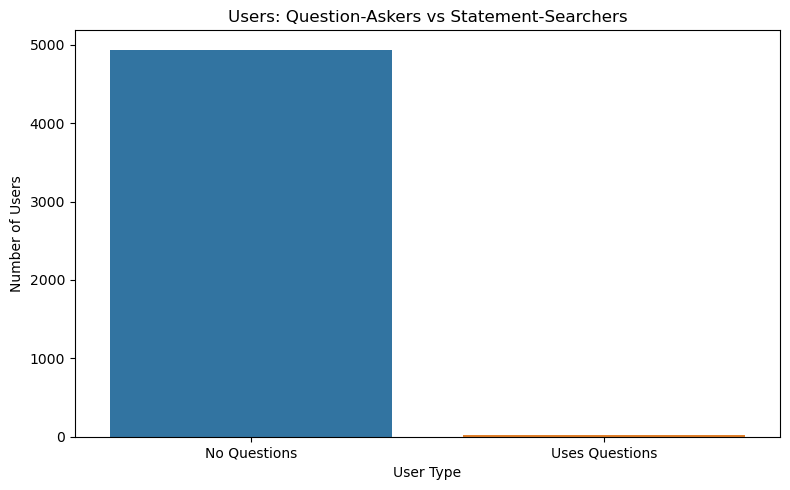

Question users: O_NP_user
No Questions      4939
Uses Questions      22
Name: count, dtype: int64
Typical O_NP share: 0.000


In [87]:
# ULTRA-SIMPLE Plot 1: Binary user types
user_o_np = ep_level.groupby('device_name_actual')['O_NP_share'].median().reset_index()
user_o_np['O_NP_user'] = (user_o_np['O_NP_share'] > 0).map({True: 'Uses Questions', False: 'No Questions'})

plt.figure(figsize=(8, 5))
sns.countplot(data=user_o_np, x='O_NP_user')
plt.title("Users: Question-Askers vs Statement-Searchers")
plt.xlabel("User Type"); plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

print(f"Question users: {user_o_np['O_NP_user'].value_counts()}")
print(f"Typical O_NP share: {user_o_np['O_NP_share'].median():.3f}")


**Key Findings**
- Across 4,961 devices, only 22 (0.4%) ever issued an open, non‑possibility question, while the large majority of 4,939 users (99.6%) relied entirely on non‑question or keyword‑style queries.

**(ii) Question‑Askers vs Statement‑Searchers**

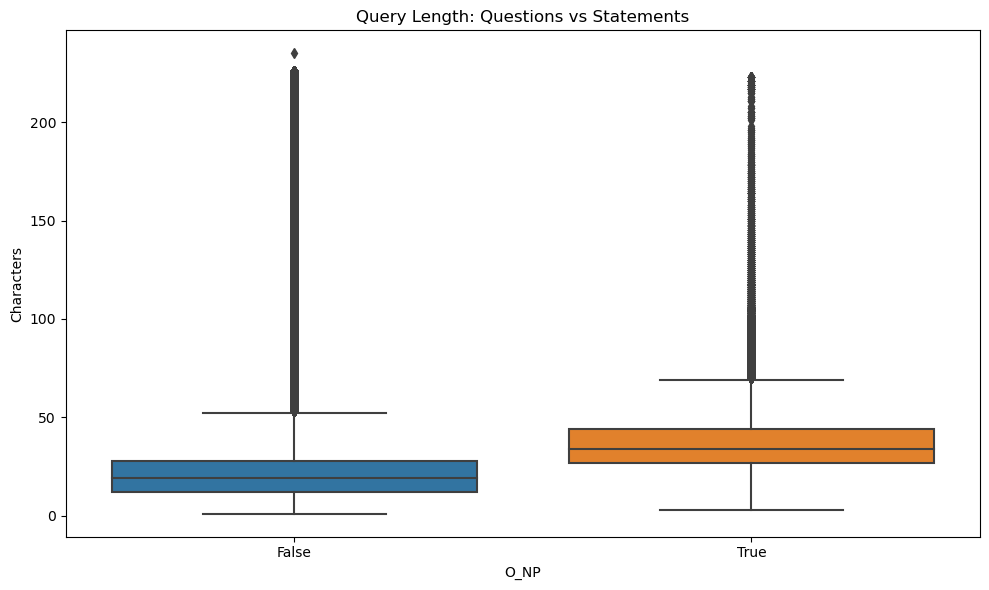

Query length stats:
            mean  median    count
O_NP                             
False  24.699753    19.0  2939444
True   36.648271    34.0   442543


In [98]:
df['query_length'] = df['search_q'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='O_NP', y='query_length')
plt.title("Query Length: Questions vs Statements")
plt.xlabel("O_NP"); plt.ylabel("Characters")
plt.tight_layout()
plt.show()

print("Query length stats:")
print(df.groupby('O_NP')['query_length'].agg(['mean', 'median', 'count']))


**Key Findings**
- Students’ explicit questions are markedly longer than their other queries. For non-O_NP queries, the median length is 19 characters (mean 24.7; n = 2,939,444), whereas O_NP queries have a median of 34 characters (mean 36.6; n = 442,543).

- This implies that when students formulate open, non‑possibility questions, they typically invest more words to specify their information need, in contrast to the shorter, more fragmentary forms used for non‑question queries.


**(iii) Query Length (Tokens) for Open vs Non‑Open Questions**

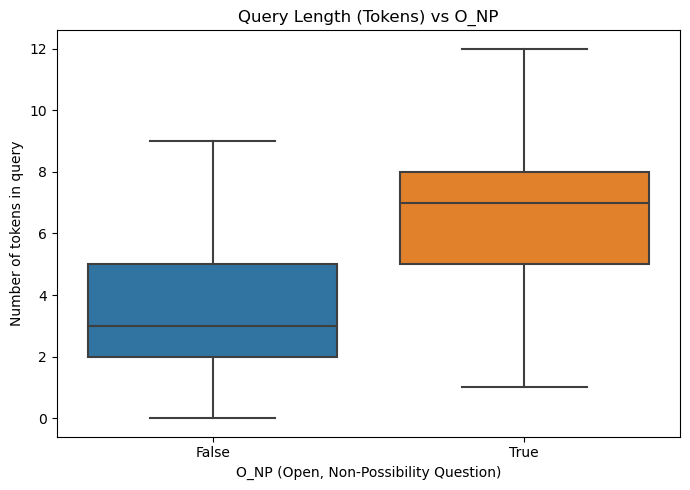

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: trim extreme token counts to avoid long tails
max_tokens = df['n_tokens'].quantile(0.99)
df_plot = df[df['n_tokens'] <= max_tokens]

plt.figure(figsize=(7, 5))
sns.boxplot(
    data=df_plot,
    x='O_NP',
    y='n_tokens',
    showfliers=False
)

plt.xlabel("O_NP (Open, Non-Possibility Question)")
plt.ylabel("Number of tokens in query")
plt.title("Query Length (Tokens) vs O_NP")
plt.tight_layout()
plt.show()

**Key Findings**
- Open, non‑possibility questions (O_NP = True) contain substantially more tokens than non‑O_NP queries; their median length is clearly higher, and the entire IQR box is shifted upward, indicating consistently longer wording for explicit questions.

- The upper whisker for O_NP extends to longer queries, indicating that when students ask open questions they often elaborate more, producing the longest and most linguistically complex queries in the dataset.




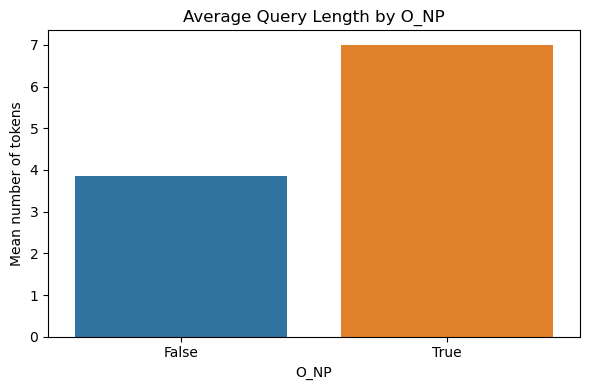

In [132]:
mean_tokens = (
    df.groupby('O_NP')['n_tokens']
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=mean_tokens,
    x='O_NP',
    y='n_tokens'
)

plt.xlabel("O_NP")
plt.ylabel("Mean number of tokens")
plt.title("Average Query Length by O_NP")
plt.tight_layout()
plt.show()

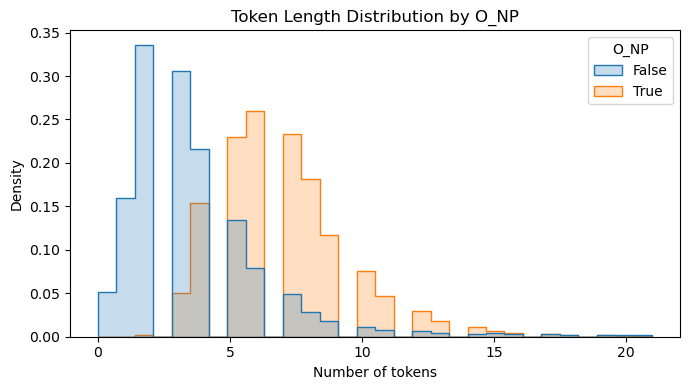

In [133]:
plt.figure(figsize=(7, 4))
sns.histplot(
    data=df_plot,
    x='n_tokens',
    hue='O_NP',
    bins=30,
    element='step',
    stat='density',
    common_norm=False
)

plt.xlabel("Number of tokens")
plt.title("Token Length Distribution by O_NP")
plt.tight_layout()
plt.show()


**Key Findings**
- Open, non‑possibility questions (O_NP = True) are systematically longer in tokens than non‑O_NP queries: their token‑length distribution is shifted to the right, with a higher mode and mean.

- The distributions overlap, but O_NP queries show a heavier right tail, meaning the very longest queries are much more likely to be explicit open questions rather than statement‑style searches.


#### (b) Episode Query Length vs Open Question Share

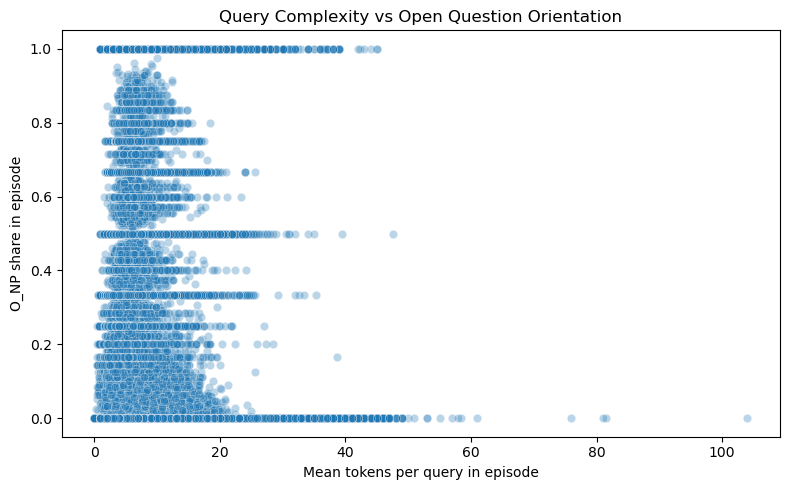

In [134]:
# Episode-level aggregation
ep_tokens = (
    df.groupby(['device_name_actual', 'q_episode'])
    .agg(
        mean_tokens=('n_tokens', 'mean'),
        O_NP_share=('O_NP', 'mean')
    )
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=ep_tokens,
    x='mean_tokens',
    y='O_NP_share',
    alpha=0.3
)

plt.xlabel("Mean tokens per query in episode")
plt.ylabel("O_NP share in episode")
plt.title("Query Complexity vs Open Question Orientation")
plt.tight_layout()
plt.show()


**Key Findings**
- Episodes span a wide range of mean tokens per query even when their O_NP share is near zero, and similarly wide variation appears at high O_NP shares; there is no clear monotonic relationship between episode‑level query length and O_NP orientation.

- The dense cluster at low–moderate mean token counts combined with vertical spreads across the full O_NP range suggests that open‑question use is a distinct behavioural choice rather than just a by‑product of writing longer queries.

#### (c) Typical Question Use vs Episode Effort at the User Level

**(i) Scatterplot**

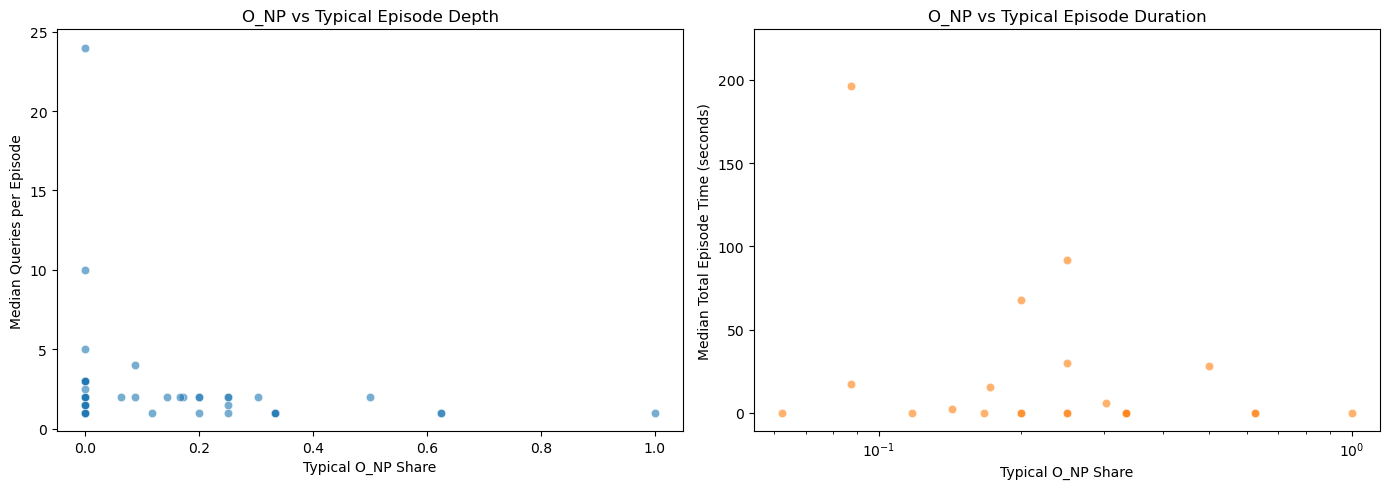

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate user-level profiles
user_profiles = ep_level.groupby('device_name_actual').agg({
    'O_NP_share': 'median',
    'num_query_episode': 'median',
    'time_total': 'median'
}).reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -------- Scatterplot 1: O_NP vs Median Episode Depth --------
sns.scatterplot(
    data=user_profiles,
    x='O_NP_share',
    y='num_query_episode',
    ax=axes[0],
    alpha=0.6,
    color='#1f77b4'  # Blue
)
axes[0].set_title("O_NP vs Typical Episode Depth")
axes[0].set_xlabel("Typical O_NP Share")
axes[0].set_ylabel("Median Queries per Episode")

# -------- Scatterplot 2: O_NP vs Median Episode Duration --------
sns.scatterplot(
    data=user_profiles,
    x='O_NP_share',
    y='time_total',
    ax=axes[1],
    alpha=0.6,
    color='#ff7f0e'  # Orange
)
axes[1].set_xscale('log')
axes[1].set_title("O_NP vs Typical Episode Duration")
axes[1].set_xlabel("Typical O_NP Share")
axes[1].set_ylabel("Median Total Episode Time (seconds)")

plt.tight_layout()
plt.show()


**Key Findings**

**Left Panel: O_NP vs typical Episode Depth**
- Users with zero or very low typical O_NP share span the full range of episode depths, from very shallow (1–2 queries) to quite deep episodes (above 20 queries), indicating that long episodes do not require frequent open questions.​

- Among users who do use O_NP more often (to the right of the x‑axis), median episode depth remains mostly low (around 1–3 queries per episode), suggesting that higher question use does not systematically translate into deeper sessions.

**Right Panel: O_NP vs Typical Episode Duration**
- At low typical O_NP shares, users show a wide spread of median episode times, including some with very long sessions, implying that lengthy episodes can occur even when almost no open questions are asked.​

- As typical O_NP share increases, median total episode time generally stays modest and shows no clear monotonic increase, indicating little evidence that frequent question use is associated with substantially longer episodes on average.


**(ii) Boxplots**
- **0 (none)**: episodes with O_NP_share = 0, i.e. no O_NP questions at all (1,163,201 episodes).​

- **More than 0–0.1**: episodes where more than 0% but at most 10% of queries are O_NP (5,499 episodes).​

- **0.1–0.5**: episodes with 10–50% of queries classified as O_NP (108,386 episodes).​

- **More than 0.5**: episodes where more than half of the queries are O_NP questions (172,652 episodes).​



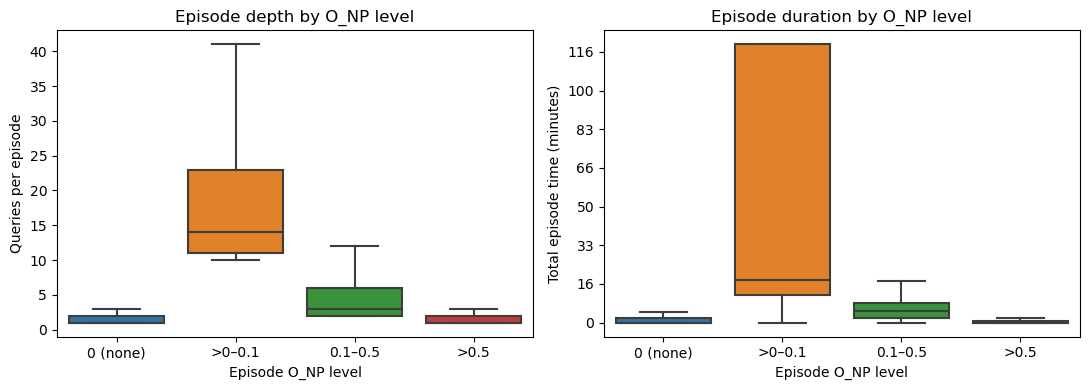

O_NP_level
0 (none)    1163201
>0–0.1         5499
0.1–0.5      108386
>0.5         172652
Name: count, dtype: int64


In [103]:
# copy to avoid modifying original
ep_plot = ep_level.copy()

# trim extremes for readability
ep_plot['num_q_clipped'] = ep_plot['num_query_episode'].clip(upper=100)       # e.g. cap at 100
ep_plot['time_clipped']  = ep_plot['time_total'].clip(upper=60*60*2)          # cap at 2 hours (7200s)

import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Left: depth
sns.boxplot(
    data=ep_plot,
    x='O_NP_level',           # your categorical bins
    y='num_q_clipped',
    ax=axes[0],
    showfliers=False          # hide remaining outliers for clarity
)
axes[0].set_xlabel("Episode O_NP level")
axes[0].set_ylabel("Queries per episode")
axes[0].set_title("Episode depth by O_NP level")

# Right: duration
sns.boxplot(
    data=ep_plot,
    x='O_NP_level',
    y='time_clipped',
    ax=axes[1],
    showfliers=False
)
axes[1].set_xlabel("Episode O_NP level")
axes[1].set_ylabel("Total episode time (minutes)")
axes[1].set_title("Episode duration by O_NP level")
axes[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, _: int(v/60)))  # seconds → minutes

plt.tight_layout()
plt.show()

print(
    ep_level['O_NP_level']
    .value_counts()
    .sort_index()
)



**Key Findings**

**Left Plot: O_NP vs typical Episode Depth**
- Episodes with no open questions are typically very shallow, with most medians around 1–2 queries per episode.​

- Moving from 0 (none) to low O_NP (>0–0.1), typical episode depth increases noticeably: medians are around 10–15 queries, with some episodes reaching several dozen queries, indicating that episodes that mix a small number of questions into mostly non‑question queries tend to be the deepest.​

- For medium (0.1–0.5) and high (>0.5) O_NP levels, episode depths drop back to more modest values (a few queries), suggesting that strongly question‑dominated episodes are not the ones driving the very deep sessions.

**Right Plot: O_NP vs Typical Episode Duration**
- Episodes with no questions are generally short, clustering at a few minutes or less once time is shown in minutes.​

- Low‑O_NP episodes (>0–0.1) show the longest and most variable durations, with a very wide interquartile range extending to over an hour in some cases, again implying that the deepest and slowest sessions are those where questions are present but not dominant.​

- Medium and high O_NP episodes (0.1–0.5, >0.5) have shorter, tighter duration distributions, indicating that heavily question‑oriented episodes tend to be relatively focused and time‑bounded rather than sprawling over very long periods.


#### (d) Stability of Open Question Use Over Time for Top Users

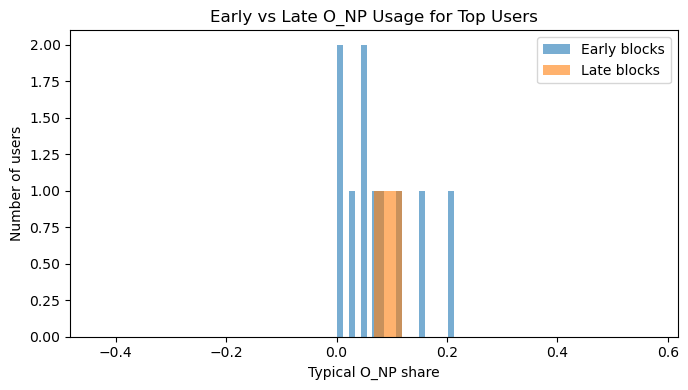

In [106]:
# early vs late blocks per user
block_stats = (
    ep_top
    .groupby(['device_name_actual', 'episode_block'])['O_NP_share']
    .mean()
    .reset_index()
)

early = block_stats[block_stats['episode_block'] <= 2].groupby('device_name_actual')['O_NP_share'].mean()
late  = block_stats[block_stats['episode_block'] >= block_stats['episode_block'].max()-2].groupby('device_name_actual')['O_NP_share'].mean()

plt.figure(figsize=(7, 4))
plt.hist(early, bins=20, alpha=0.6, label='Early blocks')
plt.hist(late,  bins=20, alpha=0.6, label='Late blocks')
plt.xlabel("Typical O_NP share")
plt.ylabel("Number of users")
plt.title("Early vs Late O_NP Usage for Top Users")
plt.legend()
plt.tight_layout()
plt.show()


**Key Findings**

- Both the blue (early blocks) and orange (late blocks) bars are concentrated in a narrow band of O_NP_share values (roughly around 0–0.2), with no clear shift of the late distribution towards higher shares.​

- This suggests that, for these heavy users, the tendency to issue open, non‑possibility questions is stable over time rather than increasing with experience; there is no evidence of a systematic move from fragment‑style queries to more explicit factual questions across their episodes.



#### (e) Top Users’ Open Question Use Across Episode Depths

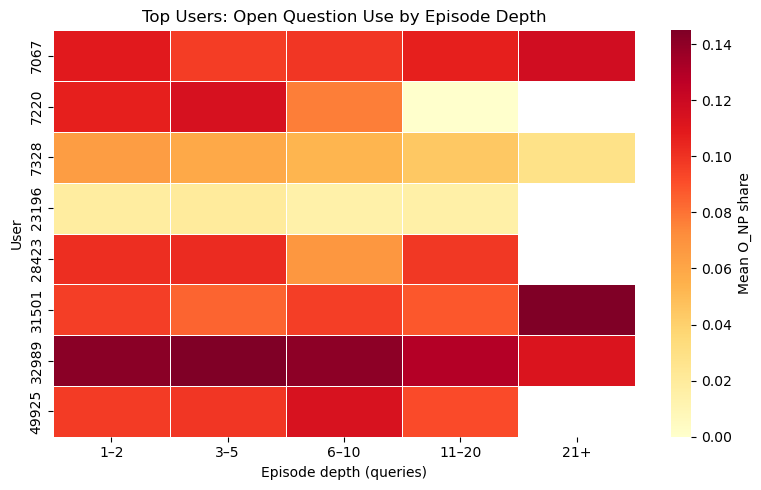

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Restrict to top users
top_users = ep_level['device_name_actual'].value_counts().head(8).index
hm = ep_level[ep_level['device_name_actual'].isin(top_users)].copy()

# 2. Bin episode depth into interpretable ranges
hm['depth_bin'] = pd.cut(
    hm['num_query_episode'],
    bins=[0, 2, 5, 10, 20, np.inf],
    labels=['1–2', '3–5', '6–10', '11–20', '21+']
)

# 3. Compute mean O_NP_share and episode counts per cell
stats = (
    hm.groupby(['device_name_actual', 'depth_bin'])['O_NP_share']
      .agg(['mean', 'count'])
      .reset_index()
)

# 4. Light filter: hide only *very* sparse cells
min_episodes = 5
stats.loc[stats['count'] < min_episodes, 'mean'] = np.nan

# 5. Pivot to user × depth_bin matrix
pivot = stats.pivot(
    index='device_name_actual',
    columns='depth_bin',
    values='mean'
)

# 6. Tune colour scale to actual data range for contrast
vmax = np.nanpercentile(pivot.values, 95)  # 95th percentile as upper bound
vmin = 0.0

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot,
    cmap='YlOrRd',
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Mean O_NP share'}
)
plt.xlabel("Episode depth (queries)")
plt.ylabel("User")
plt.title("Top Users: Open Question Use by Episode Depth")
plt.tight_layout()
plt.show()


**Key Findings**
- Across users, mean O_NP share mostly lies in a narrow band below about 0.15 in all depth bins, indicating that even these heavy users rarely let open questions dominate their episodes, regardless of whether they run 1-2 queries or 21+ queries per episode.​

- Some users (for example those with darker cells in the 11-20 or 21+ columns) show slightly higher question use in deeper episodes, whereas others maintain similar or even decreasing O_NP shares as depth increases, suggesting that the relationship between depth and question behaviour is idiosyncratic rather than systematic across top users.​

#### (f) Open Question Use by Episode Depth (All Episodes)

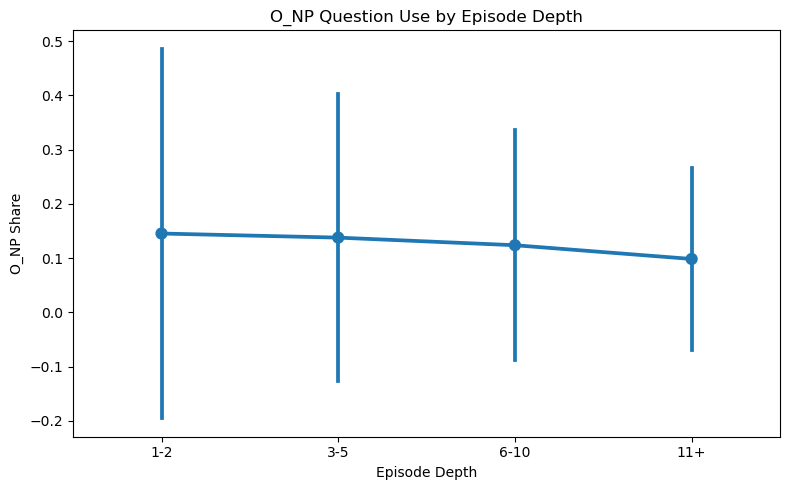

In [95]:
ep_level['depth_cat'] = pd.cut(ep_level['num_query_episode'], 
                              bins=[0, 2, 5, 10, np.inf], 
                              labels=['1-2', '3-5', '6-10', '11+'])

plt.figure(figsize=(8, 5))
sns.pointplot(data=ep_level, x='depth_cat', y='O_NP_share', errorbar='sd')
plt.title("O_NP Question Use by Episode Depth")
plt.xlabel("Episode Depth"); plt.ylabel("O_NP Share")
plt.tight_layout()
plt.show()


**Key Findings**
- Mean O_NP share is modest at all depths (around 0.10–0.15), and the line is nearly flat across the 1–2, 3–5, 6–10, and 11+ query bins, indicating no strong systematic increase or decrease in open‑question use as episodes get deeper.​

- The very large error bars, especially for shallow episodes, show substantial variability between episodes within each depth bin, implying that whether an episode contains many or few O_NP questions is more a matter of episode‑specific context or user style than of depth alone

#### (g) Open Question Use vs Other Episode Behaviours (Episode Level)


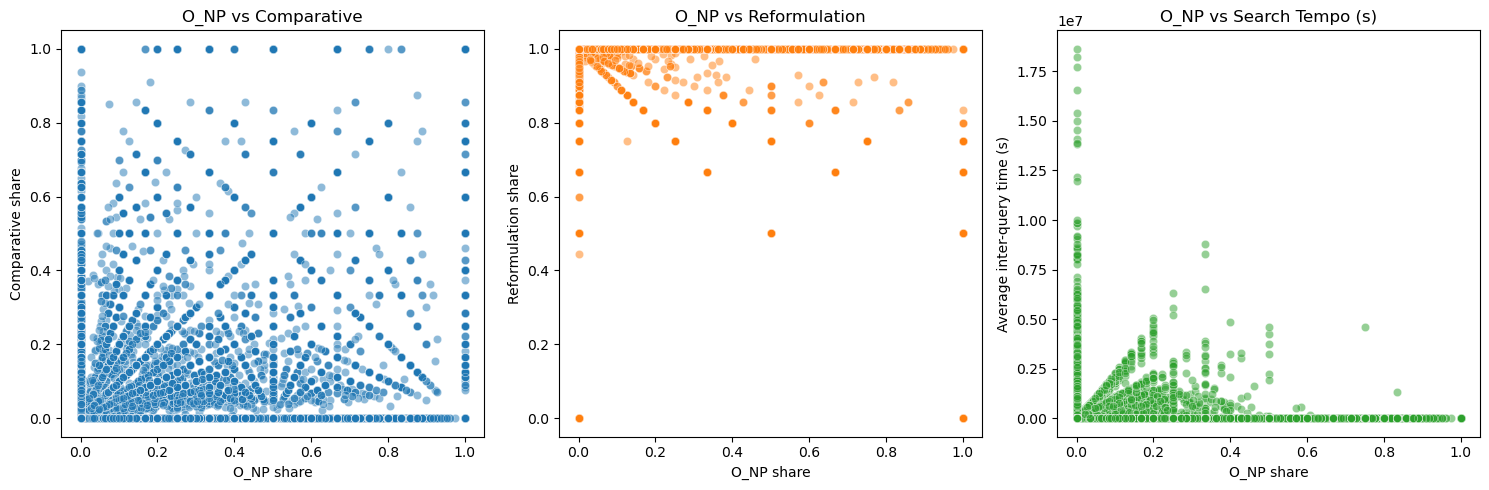

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(
    data=ep_level,
    x='O_NP_share', y='comparative_share',
    ax=axes[0], alpha=0.5, color='#1f77b4'   # blue
)
axes[0].set_title("O_NP vs Comparative")
axes[0].set_xlabel("O_NP share")
axes[0].set_ylabel("Comparative share")

sns.scatterplot(
    data=ep_level,
    x='O_NP_share', y='reformulation_share',
    ax=axes[1], alpha=0.5, color='#ff7f0e'   # orange
)
axes[1].set_title("O_NP vs Reformulation")
axes[1].set_xlabel("O_NP share")
axes[1].set_ylabel("Reformulation share")

sns.scatterplot(
    data=ep_level,
    x='O_NP_share', y='time_interval',
    ax=axes[2], alpha=0.5, color='#2ca02c'   # green
)
axes[2].set_title("O_NP vs Search Tempo (s)")
axes[2].set_xlabel("O_NP share")
axes[2].set_ylabel("Average inter-query time (s)")

plt.tight_layout()
plt.show()


**Key Findings**
- **O_NP vs comparative share (left)**: Points fill much of the square without a clear upward or downward trend, showing that episodes with higher shares of open questions do not systematically have higher or lower shares of comparative queries; question‑asking and comparative framing appear largely independent behaviours.​

- **O_NP vs reformulation share (middle)**: Most episodes, regardless of O_NP_share, sit near a reformulation share of 1.0, reflecting that once an episode passes a few queries it is almost always dominated by reformulations; there is no visible gradient indicating that open‑question episodes are more or less reformulation‑heavy.​

- **O_NP vs search tempo (right)**: The cloud is heavily concentrated near low O_NP_share and short average inter‑query times, with a long vertical tail of slow episodes but no consistent slope, suggesting that episodes rich in open questions are not reliably slower or faster than those dominated by non‑question queries.

#### (h) Daily Rhythm of Open Question Use

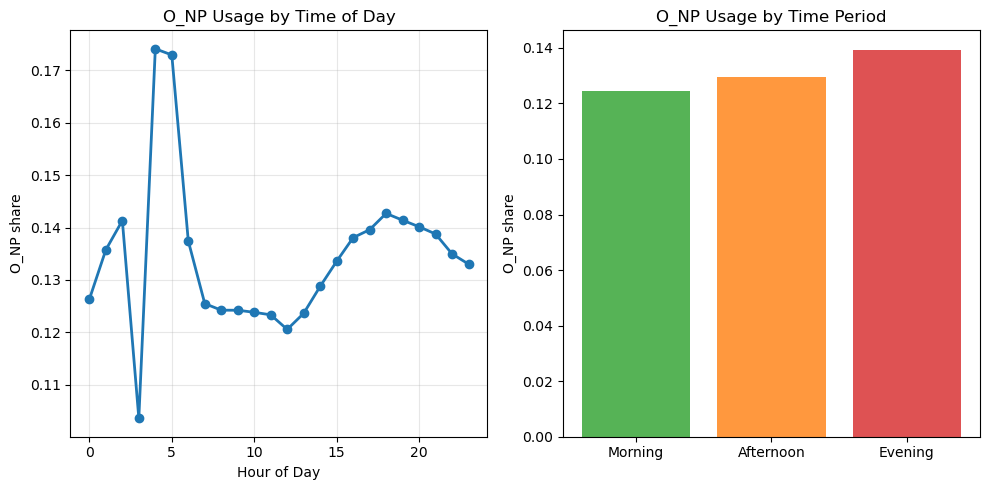

In [114]:
df['hour'] = pd.to_datetime(df['created_at']).dt.hour
hourly_o_np = df.groupby('hour')['O_NP'].mean()

plt.figure(figsize=(10, 5))

# Left: line plot with one colour
plt.subplot(1, 2, 1)
plt.plot(hourly_o_np.index, hourly_o_np.values,
         'o-', linewidth=2, color='#1f77b4')   # blue
plt.xlabel("Hour of Day")
plt.ylabel("O_NP share")
plt.title("O_NP Usage by Time of Day")
plt.grid(True, alpha=0.3)

# Right: bar plot with different colours per bar
morning = df[df['hour'] < 12]['O_NP'].mean()
afternoon = df[(df['hour'] >= 12) & (df['hour'] < 18)]['O_NP'].mean()
evening = df[df['hour'] >= 18]['O_NP'].mean()
periods = ['Morning', 'Afternoon', 'Evening']
values = [morning, afternoon, evening]
colors = ['#2ca02c', '#ff7f0e', '#d62728']    # green, orange, red

plt.subplot(1, 2, 2)
plt.bar(periods, values, alpha=0.8, color=colors)
plt.title("O_NP Usage by Time Period")
plt.ylabel("O_NP share")

plt.tight_layout()
plt.show()


**Key Findings**
- The hourly line plot shows that O_NP share fluctuates within a relatively narrow band over the day (roughly 0.12–0.17), with some local peaks in the early morning hours but no strong monotonic rise or fall across the full 24‑hour cycle.​

- Aggregated by time period, O_NP share is slightly higher in the evening than in the morning or afternoon, but the differences are small, suggesting that while students may ask open questions marginally more often later in the day, overall question‑asking is not strongly time‑of‑day dependent.

#### (i) Open Question Use vs Topic Breadth and Specificity

entity_category_diversity         float64
specific_entity_diversity         float64
category_entity_diversity         float64
user_entity_category_diversity    float64
user_specific_entity_diversity    float64
user_category_entity_diversity    float64
query_specificity                  object
topic_diversity                   float64
topic_count                         int64
dtype: object
Episode-level diversity shape: (1449738, 11)
Merged episodes: (1449738, 20)


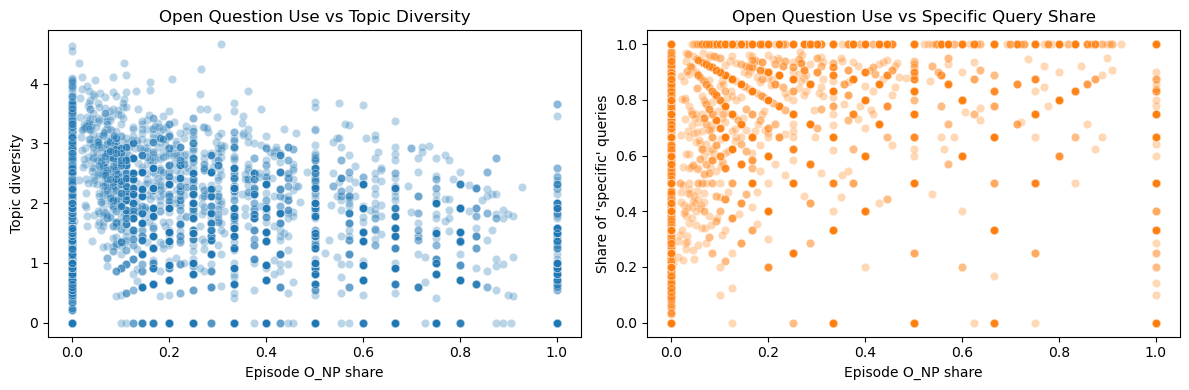

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check dtypes once (optional, just to confirm)
print(specific_broad[[
    'entity_category_diversity', 'specific_entity_diversity',
    'category_entity_diversity', 'user_entity_category_diversity',
    'user_specific_entity_diversity', 'user_category_entity_diversity',
    'query_specificity', 'topic_diversity', 'topic_count'
]].dtypes)

# 2. Keep only numeric diversity columns (exclude categorical 'query_specificity')
numeric_cols = [
    'entity_category_diversity',
    'specific_entity_diversity',
    'category_entity_diversity',
    'user_entity_category_diversity',
    'user_specific_entity_diversity',
    'user_category_entity_diversity',
    'topic_diversity',
    'topic_count'
]

cols = ['school_name', 'device_name_actual', 'q_episode'] + numeric_cols
sb = specific_broad[cols].copy()

# 3. Episode-level means for these numeric columns
ep_div = (
    sb.groupby(['school_name', 'device_name_actual', 'q_episode'])[numeric_cols]
      .mean()
      .reset_index()
)

print("Episode-level diversity shape:", ep_div.shape)

# 4. OPTIONAL: derive an episode-level 'specific_share' from query_specificity
#    if you want to use that as well.
qs = specific_broad[['school_name', 'device_name_actual', 'q_episode', 'query_specificity']].copy()
qs['is_specific'] = (qs['query_specificity'] == 'specific').astype(int)

ep_qs = (
    qs.groupby(['school_name', 'device_name_actual', 'q_episode'])['is_specific']
      .mean()
      .reset_index()
      .rename(columns={'is_specific': 'specific_share'})
)

# 5. Merge episode-level diversity with your existing ep_level (which has O_NP_share)
ep_merged = (
    ep_level
    .merge(ep_div, on=['school_name', 'device_name_actual', 'q_episode'], how='inner')
    .merge(ep_qs,  on=['school_name', 'device_name_actual', 'q_episode'], how='left')
)

print("Merged episodes:", ep_merged.shape)

# 6. Sample up to 100k rows for plotting to keep it fast/light
sampled = ep_merged.sample(
    n=min(len(ep_merged), 100_000),
    random_state=42
)

# 7. Example plots: O_NP vs topic_diversity and specific_share
plt.figure(figsize=(12, 4))

# Left: O_NP vs topic_diversity
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=sampled,
    x='O_NP_share',
    y='topic_diversity',
    alpha=0.3,
    color='#1f77b4'
)
plt.xlabel("Episode O_NP share")
plt.ylabel("Topic diversity")
plt.title("Open Question Use vs Topic Diversity")

# Right: O_NP vs specific_share (if available)
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=sampled,
    x='O_NP_share',
    y='specific_share',
    alpha=0.3,
    color='#ff7f0e'
)
plt.xlabel("Episode O_NP share")
plt.ylabel("Share of 'specific' queries")
plt.title("Open Question Use vs Specific Query Share")

plt.tight_layout()
plt.show()


**Key Findings**
- **O_NP vs Topic Diversity/Semantic Diversity (Left Plot)**: Topic diversity spans a wide range at all values of O_NP_share, with no strong monotonic trend; episodes with many open questions are not consistently more or less topically diverse than those dominated by non‑question queries.
- **O_NP vs Specific-Query Share (Right Plot)**: The full vertical spread from 0 to 1 at almost every O_NP_share indicates that some episodes with many open questions are built almost entirely from “specific” queries, while others mix open questions with broad queries. Again there is no clear linear relationship, suggesting that open‑question use and specificity are partially independent dimensions of search formulation.


#### (j) Open Question Use vs Lexical Diversity

Merged for lexical: (1449738, 12)


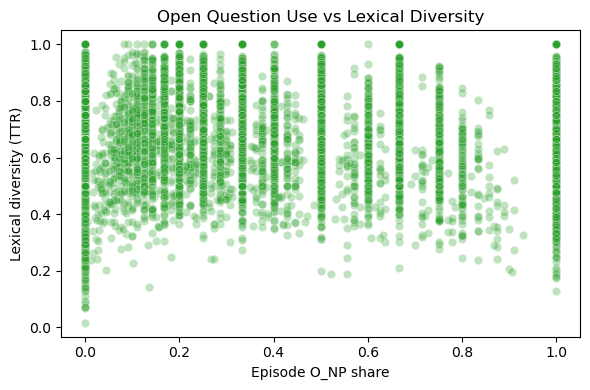

In [126]:
import re
import numpy as np
import pandas as pd

def simple_tokenize(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"[a-zA-Z0-9']+", text.lower())

# per‑query tokens
specific_broad = specific_broad.copy()
specific_broad['tokens'] = specific_broad['search_q'].apply(simple_tokenize)

# episode-level TTR
ep_tokens = (
    specific_broad
    .groupby(['school_name', 'device_name_actual', 'q_episode'])['tokens']
    .sum()
)

ep_lex = ep_tokens.apply(
    lambda toks: len(set(toks)) / len(toks) if len(toks) > 0 else np.nan
).reset_index().rename(columns={0: 'lexical_diversity', 'tokens': 'lexical_diversity'})
ep_lex.columns = ['school_name', 'device_name_actual', 'q_episode', 'lexical_diversity']

# ep_level already has O_NP_share per (school_name, device_name_actual, q_episode)

ep_merged_lex = (
    ep_level
    .merge(ep_lex,
           on=['school_name', 'device_name_actual', 'q_episode'],
           how='inner')
)

print("Merged for lexical:", ep_merged_lex.shape)

# sample for plotting
sampled_lex = ep_merged_lex.sample(
    n=min(len(ep_merged_lex), 100_000),
    random_state=42
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=sampled_lex,
    x='O_NP_share',
    y='lexical_diversity',
    alpha=0.3,
    color='#2ca02c'
)
plt.xlabel("Episode O_NP share")
plt.ylabel("Lexical diversity (TTR)")
plt.title("Open Question Use vs Lexical Diversity")
plt.tight_layout()
plt.show()



**Key Findings**
- Episodes across the full range of O_NP_share (from 0 to 1) display highly variable lexical diversity, with points spread from very low to near‑maximal TTR at almost every x‑value; there is no obvious monotonic increase or decrease.​

- The dense vertical bands and the overall “rectangular” cloud suggest that using more open questions does not systematically lead to more or less varied wording in queries; lexical diversity appears largely independent of open‑question share at the episode level.

In [135]:
df.head()

school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ...  \
0            True           False        1.0  ...   
1            True           False        2.0  ...   
2           False           False        2.0  ...   
3           False           False        2.0  ...   
4           False           False        2.0  ...   

  reformulation_levenshtein_norm  is_reformulation time_interval time_total  \
0                           0.00             False          0.00       0.00   
1                           0.97              True         71.33     285.32   
2                           0.12              True         71.33     285.32   
3                           0.53              True         71.33     285.32   
4                           0.41              True         71.33     285.32   

   num_query_episode   O_NP  hour  query_length  \
0                1.0  False  21.0           2.0   
1                4.0  False  21.0          30.0   
2                4.0  False  21.0          32.0   
3                4.0  False  21.0          19.0   
4                4.0  False  21.0          32.0   

                                   tokens  n_tokens  
0                                    [wy]         1  
1    [hospital, between, 1959, and, 1970]         5  
2  [hospital, between, 1960s, and, 1970s]         5  
3                 [hospital, after, 1965]         3  
4  [hospital, after, 1965, in, singapore]         5  

[5 rows x 27 columns]

## 5.9 Feature 9: Open, Possibility Type Questions (O_P)

**O_P Feature**

The **O_P** feature identifies queries that are **open-ended questions** but are **framed as hypothetical or possibility-based questions**. This captures user intent to explore potential outcomes, conditions, or feasibility rather than requesting purely factual or descriptive information.

- The calculation is based on the **first two tokens** of the query (`search_q`) to determine the type of question.
- **Open tokens:** (`'who'`, `'when'`, `'what'`, `'where'`, `'how'`, `'why'`)
- **Possibility tokens:** (`'can'`, `'may'`, `'might'`, `'could'`, `'would'`, `'if'`, `'will'`)
- Queries that **start with an open token** and **contain at least one possibility token in the first two words** are flagged as `O_P = True`.
- All other queries are flagged as `O_P = False`.

---

### Processing Logic

**Token Extraction and Rule Application**

- Each query is converted to lowercase (`str.lower()`) to ensure consistent token matching.
- The **first two tokens** of each query are extracted using `str.split(n=2)` and slicing (`x[:2]`).
- `cond_open` checks whether the **first token** belongs to the set of open question words.
- `cond_poss` checks whether **any of the first two tokens** belong to the set of possibility/modal tokens.
- A query is flagged as `O_P = True` **only if both conditions are satisfied** (`cond_open & cond_poss`).

To ensure scalability on large datasets (≈3 million rows), the computation is performed in **fixed-size chunks**, and the `O_P` column is added **without removing or reordering any rows**.

---

**Example**

| search_q                             | O_P   |
|------------------------------------|-------|
| How can we reduce air pollution?   | True  |
| Why might the sky appear red?      | True  |
| What is photosynthesis?            | False |
| Who invented the telephone?        | False |
| Will climate change worsen?        | False |

- Queries flagged as `True` satisfy the **open, possibility-type question** rule.
- Queries flagged as `False` are either **non-open questions** or **open questions without possibility framing**.


In [205]:
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Token rules
# -----------------------------
open_tokens = ('who', 'when', 'what', 'where', 'how', 'why')
possibility_tokens = ('can', 'may', 'might', 'could', 'would', 'if', 'will')

# -----------------------------
# Initialize column (NO row loss)
# -----------------------------
df['O_P'] = False   # default value

# -----------------------------
# Chunk processing
# -----------------------------
chunksize = 100_000
total_rows = len(df)

for start in tqdm(range(0, total_rows, chunksize), desc="Processing chunks for O_P"):
    end = min(start + chunksize, total_rows)
    idx = df.index[start:end]

    # Lowercase query text
    q = df.loc[idx, 'search_q'].astype(str).str.lower()

    # Extract first two tokens
    first_two = q.str.split(n=2).apply(lambda x: x[:2])

    # Conditions
    cond_open = first_two.apply(
        lambda x: x[0] in open_tokens if len(x) > 0 else False
    )

    cond_poss = first_two.apply(
        lambda x: any(tok in possibility_tokens for tok in x)
    )

    # Assign result
    df.loc[idx, 'O_P'] = cond_open & cond_poss

df.head()


Processing chunks for O_P: 100%|████████████████| 34/34 [00:54<00:00,  1.61s/it]


school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... reformulation_levenshtein  \
0            True           False        1.0  ...                         0   
1            True           False        2.0  ...                        29   
2           False           False        2.0  ...                         4   
3           False           False        2.0  ...                        17   
4           False           False        2.0  ...                        13   

   reformulation_levenshtein_norm is_reformulation time_interval time_total  \
0                            0.00            False          0.00       0.00   
1                            0.97             True         71.33     285.32   
2                            0.12             True         71.33     285.32   
3                            0.53             True         71.33     285.32   
4                            0.41             True         71.33     285.32   

  num_query_episode   O_NP                                  tokens  n_tokens  \
0               1.0  False                                    [wy]         1   
1               4.0  False    [hospital, between, 1959, and, 1970]         5   
2               4.0  False  [hospital, between, 1960s, and, 1970s]         5   
3               4.0  False                 [hospital, after, 1965]         3   
4               4.0  False  [hospital, after, 1965, in, singapore]         5   

     O_P  
0  False  
1  False  
2  False  
3  False  
4  False  

[5 rows x 26 columns]

#### (a) User-Level Prevalence of Open Possibility Questions (O_P)

**(i) Histogram**

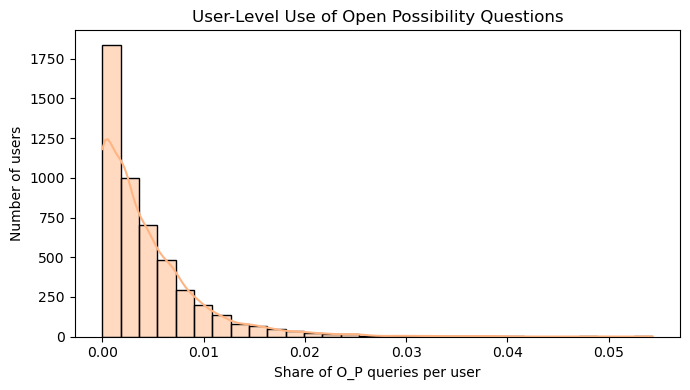

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

user_col = "device_name_actual"

user_op_share = (
    df.groupby(user_col)["O_P"]
      .mean()
      .rename("O_P_share")
      .reset_index()
)

plt.figure(figsize=(7,4))
sns.histplot(
    data=user_op_share,
    x="O_P_share",
    bins=30,
    kde=True,
    color=sns.color_palette("pastel")[1]
)
plt.xlabel("Share of O_P queries per user")
plt.ylabel("Number of users")
plt.title("User-Level Use of Open Possibility Questions")
plt.tight_layout()
plt.show()


**Key Findings**
- The distribution is highly right‑skewed, with the vast majority of users having an O_P share very close to zero (bars concentrated between 0 and about 0.01 on the x‑axis), showing that possibility‑framed questions make up well under 1% of queries for most students.​

- A long, thinning tail extends out toward O_P shares above 0.02 and up to roughly 0.05, indicating a small minority of users who employ O_P substantially more often, but these heavier users are numerically rare compared to the mass near zero.​

**(ii) Bar Chart**

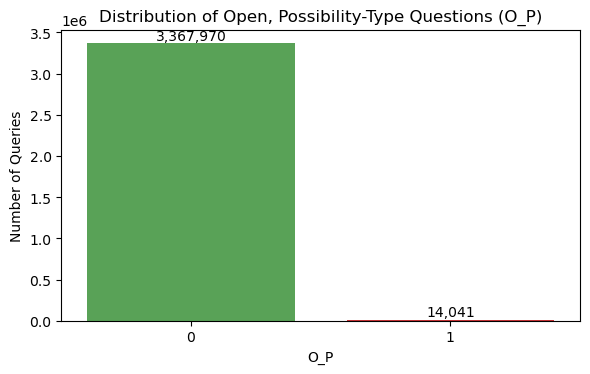

O_P counts:
O_P
0    3367970
1      14041
Name: count, dtype: int64

O_P percentages:
O_P
0    99.58
1     0.42
Name: proportion, dtype: float64


In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=df,
    x='O_P',
    palette=['#4daf4a', '#e41a1c']
)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xlabel("O_P")
plt.ylabel("Number of Queries")
plt.title("Distribution of Open, Possibility-Type Questions (O_P)")
plt.tight_layout()
plt.show()

# Count values
op_counts = df['O_P'].value_counts().sort_index()
op_percent = df['O_P'].value_counts(normalize=True).sort_index() * 100

print("O_P counts:")
print(op_counts)

print("\nO_P percentages:")
print(op_percent.round(2))


**Key Findings**
- Open possibility questions (O_P) are extremely rare: only 14,041 out of 3,367,970 queries are tagged O_P, so just 0.42% of all queries are possibility‑type questions, while 99.58% are not.​

- This implies that students overwhelmingly search with statements or non‑possibility questions, and the use of hypothetical “can/might/could” style questions is a distinct, exceptional behaviour rather than a routine way of querying.​


#### (b) Episode Depth vs O_P (Search Iteration Behaviour)
**(i) Boxplots**

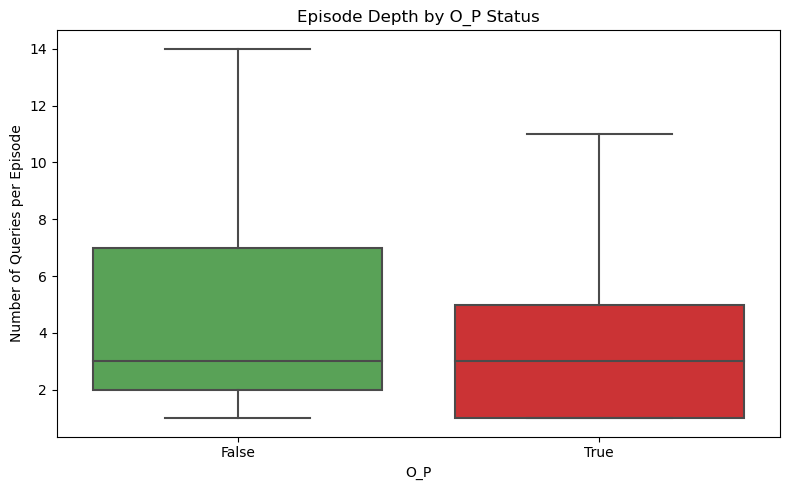

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    data=df,
    x='O_P',
    y='num_query_episode',
    order=[False, True],          # force boolean order
    showfliers=False,
    palette=['#4daf4a', '#e41a1c']
)

# Explicitly set tick labels
ax.set_xticklabels(['False', 'True'])

plt.xlabel("O_P")
plt.ylabel("Number of Queries per Episode")
plt.title("Episode Depth by O_P Status")
plt.tight_layout()
plt.show()




**Key Findings**
-  The boxplot shows that episodes without O_P questions tend to be deeper than episodes that include them.

- For episodes with O_P = False, the median depth is about 3 queries, with the middle 50% spanning roughly 2 to 7 queries and an upper whisker up to around 14 queries, indicating a substantial tail of very long, non‑O_P episodes.​

- For episodes with O_P = True, the median depth is slightly lower (around 3 but with a tighter spread), the IQR is narrower (roughly 1 to 5 queries), and the maximum is around 11 queries, suggesting that possibility‑type questions tend to appear in shorter or moderate‑length episodes rather than in the deepest, most extended search sessions.

**(ii) Histogram**

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_85201/993147162.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.histplot(


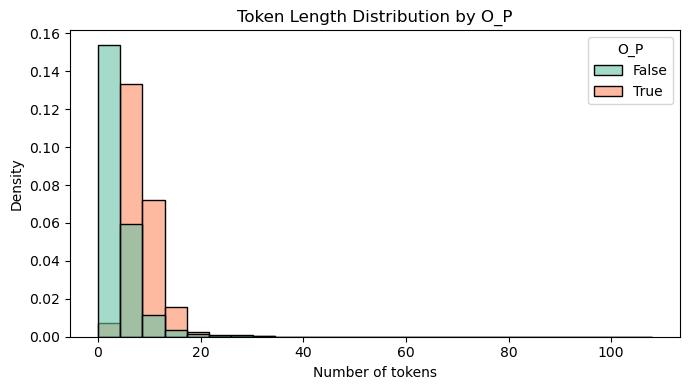

In [139]:
plt.figure(figsize=(7,4))
sns.histplot(
    data=df,
    x="n_tokens",
    hue="O_P",
    bins=25,
    stat="density",
    common_norm=False,
    palette=sns.color_palette("Set2"),
    alpha=0.6
)
plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.title("Token Length Distribution by O_P")
plt.tight_layout()
plt.show()


**Key Findings**
- The green curve (O_P = False) peaks at shorter lengths (around 2-4 tokens) and decays quickly, whereas the orange curve (O_P = True) peaks further to the right (around 5-7 tokens) and maintains more mass up to about 10-12 tokens, confirming that possibility‑type questions typically use more words than other queries.​

- Both distributions are right‑skewed with long, thin tails out to very high token counts (20+ tokens), but those extreme long queries are more likely to be O_P, reinforcing that the most verbose queries in the corpus are disproportionately possibility‑framed questions.


#### (c) User-Level O_P Reliance and Typical Episode Depth

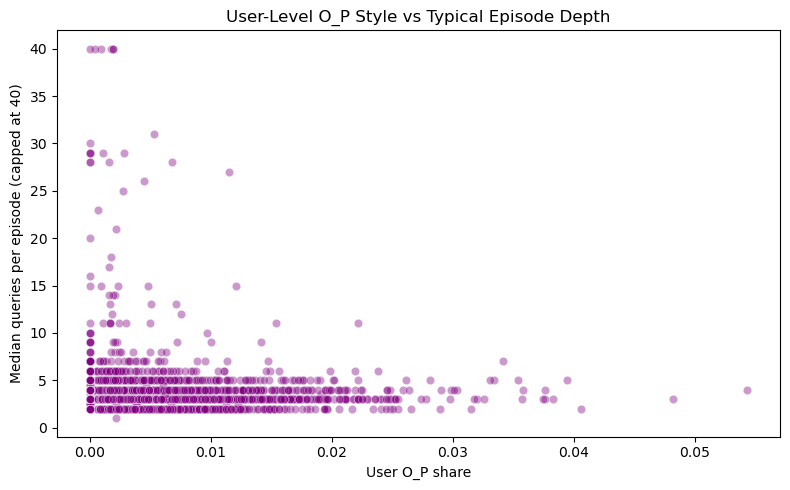

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

up = user_profiles.copy()

# 1. Cap median depth to keep extreme users from dominating
cap = 40
up['median_ep_depth_capped'] = up['median_ep_depth'].clip(upper=cap)

# 2. (Optional) add a rough activity measure = typical episode depth times O_P_share
# or, if you have n_episodes separately, use that instead
# up['n_episodes'] = ...
# here just use a constant size for simplicity
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=up,
    x='O_P_share',
    y='median_ep_depth_capped',
    alpha=0.4,
    color='purple'
)

plt.xlabel("User O_P share")
plt.ylabel("Median queries per episode (capped at 40)")
plt.title("User-Level O_P Style vs Typical Episode Depth")
plt.tight_layout()
plt.show()



**Key Findings**
- User‑level reliance on O_P questions is not strongly tied to typical episode depth. Across the whole x‑axis, from almost zero O_P_share up to about 0.05, most users have median episode depths in the 2–6 query range, forming a dense horizontal band that shows similar episode lengths regardless of how often they use O_P.​

- A few users have extremely deep typical episodes (capped at 40 queries in the plot), but these outliers appear mostly at very low O_P shares, suggesting that the deepest, most extended search styles tend to rely on non‑O_P queries rather than on frequent possibility‑type questions.

#### (d)  User Query Length vs Possibility Question Reliance


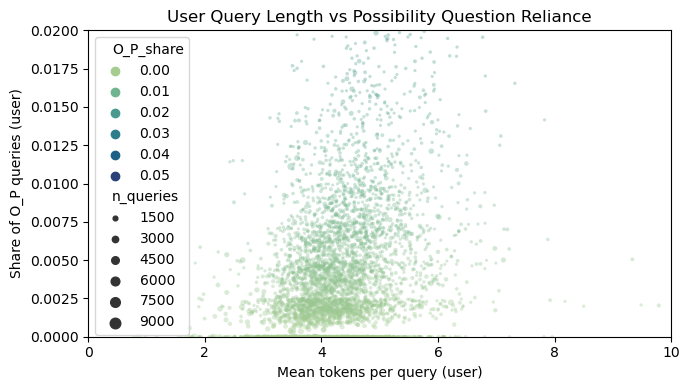

<Axes: xlabel='mean_tokens', ylabel='O_P_share'>

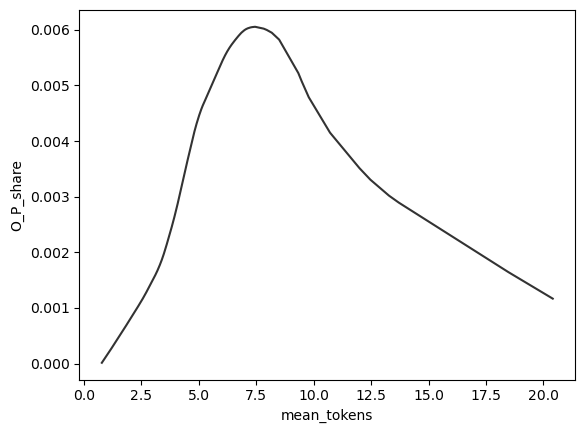

In [179]:
plt.figure(figsize=(7, 4))

sns.scatterplot(
    data=user_stats,
    x="mean_tokens",
    y="O_P_share",
    size="n_queries",
    sizes=(5, 60),
    hue="O_P_share",
    palette="crest",
    alpha=0.35,
    edgecolor="none"
)
plt.ylim(0, 0.02)
plt.xlim(0, 10)   # if almost all users lie here
plt.xlabel("Mean tokens per query (user)")
plt.ylabel("Share of O_P queries (user)")
plt.title("User Query Length vs Possibility Question Reliance")
plt.tight_layout()
plt.show()

sns.regplot(
    data=user_stats,
    x="mean_tokens",
    y="O_P_share",
    scatter=False,
    lowess=True,
    color="black",
    line_kws={"linewidth": 1.5, "alpha": 0.8}
)



**Key Findings**

**Upper Plot**
- Possibility question reliance is very low for almost all users: O_P_share is mostly below about 0.01 even among heavier queriers, so possibility questions remain a marginal behaviour.

- Users whose typical queries are moderately long (around 4–7 tokens) display the highest observed O_P_share, while users with very short or very long average query lengths almost never rely heavily on possibility questions.

**Lower Plot**
- The smoothed curve shows a hump-shaped relationship: O_P_share rises steadily from near zero as mean_tokens increases, peaks around 7–8 tokens, then declines for very verbose users.

- This indicates that possibility questions are most characteristic of users who write neither the shortest nor the longest queries, but instead occupy a mid‑complexity querying style.

#### (e) Where in Episodes Do Possibility Questions Appear

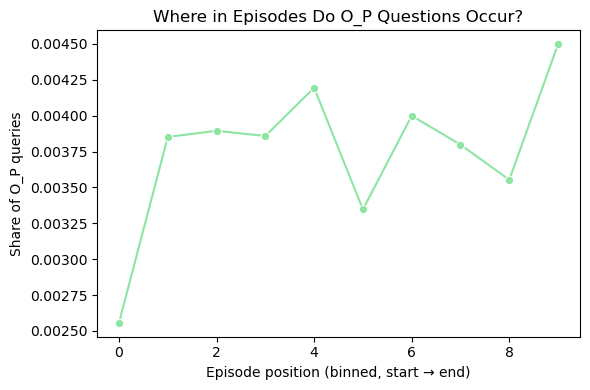

In [144]:
# add position within episode
df = df.sort_values(['device_name_actual', 'q_episode', 'created_at'])
df['q_pos'] = df.groupby(['device_name_actual', 'q_episode']).cumcount() + 1
df['ep_len'] = df.groupby(['device_name_actual', 'q_episode'])['search_q'].transform('size')
df['q_pos_norm'] = df['q_pos'] / df['ep_len']  # 0–1 position

# bin positions
df['pos_bin'] = pd.cut(df['q_pos_norm'], bins=10, labels=False)

pos_stats = (
    df.groupby('pos_bin')['O_P']
      .mean()
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=pos_stats,
    x='pos_bin',
    y='O_P',
    marker='o',
    color=sns.color_palette('pastel')[2]
)
plt.xlabel('Episode position (binned, start → end)')
plt.ylabel('Share of O_P queries')
plt.title('Where in Episodes Do O_P Questions Occur?')
plt.tight_layout()
plt.show()



**Key Findings**
- O_P questions are least common at the very first step of an episode, then rise quickly after the opening query, suggesting students usually start with a simple probe before moving into possibility‑framed queries later in the session.

- Across interior positions, the share of O_P queries stays within a narrow band and peaks near the tail end of episodes (rightmost bin), indicating that possibility questions are slightly more likely as students converge on or refine their information need toward closure rather than at the initial exploration stage.



#### (f) Possibility Question Share vs Reformulation Intensity in Episodes

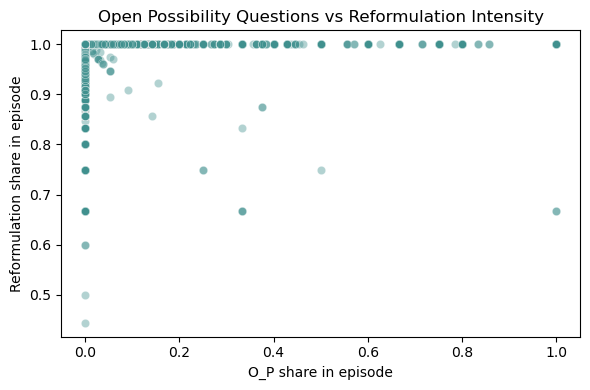

In [145]:
ep_stats = (
    df.groupby(['device_name_actual', 'q_episode'])
      .agg(
          O_P_share=('O_P', 'mean'),
          O_NP_share=('O_NP', 'mean'),
          reform_share=('is_reformulation', 'mean'),
          n_queries=('search_q', 'size')
      )
      .reset_index()
)

# filter tiny episodes
ep_stats = ep_stats[ep_stats['n_queries'] >= 3]

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=ep_stats,
    x='O_P_share',
    y='reform_share',
    alpha=0.4,
    color=sns.color_palette('crest')[2]
)
plt.xlabel('O_P share in episode')
plt.ylabel('Reformulation share in episode')
plt.title('Open Possibility Questions vs Reformulation Intensity')
plt.tight_layout()
plt.show()


**Key Findings**
- Almost all points lie at reformulation share near 1.0, forming a very tight band at the top, which shows that most multi‑query episodes are overwhelmingly made up of reformulations, independent of how many possibility questions they contain.

- Across the x‑axis, episodes range from 0 to 1 in O_P_share, but there is no systematic trend: high‑O_P episodes do not have clearly higher or lower reformulation than low‑O_P episodes; the few points with lower reformulation share are almost all at very low O_P_share, suggesting that non‑reformulation episodes are also mostly non‑possibility episodes.

#### (g) Episode‑Level Mix of Possibility vs Non‑Possibility Questions

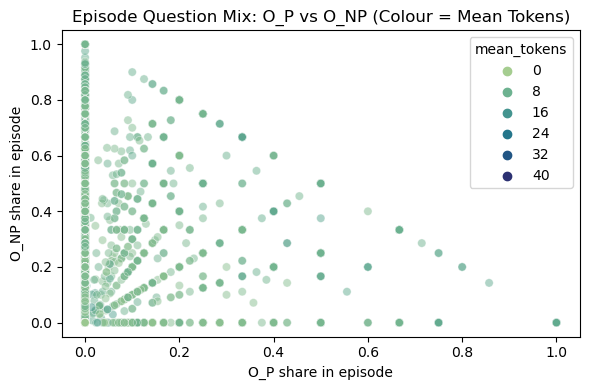

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Episode-level stats from query dataframe
ep_len_stats = (
    df.groupby(['school_name', 'device_name_actual', 'q_episode'])
      .agg(
          O_P_share=('O_P', 'mean'),
          mean_tokens=('n_tokens', 'mean'),
          n_queries=('search_q', 'size')
      )
      .reset_index()
)

# 2. Merge with ep_level (using O_NP_share instead of success_rate)
ep_merged = ep_len_stats.merge(
    ep_level[['school_name', 'device_name_actual', 'q_episode', 'O_NP_share']],
    on=['school_name', 'device_name_actual', 'q_episode'],
    how='inner'
)

# 3. Optional: restrict to episodes with at least 3 queries
ep_merged = ep_merged[ep_merged['n_queries'] >= 3]

# 4. Plot: O_P_share vs O_NP_share, coloured by mean_tokens
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=ep_merged.sample(min(len(ep_merged), 100_000), random_state=42),
    x='O_P_share',
    y='O_NP_share',
    hue='mean_tokens',
    palette='crest',
    alpha=0.5
)
plt.xlabel('O_P share in episode')
plt.ylabel('O_NP share in episode')
plt.title('Episode Question Mix: O_P vs O_NP (Colour = Mean Tokens)')
plt.tight_layout()
plt.show()


**Key Findings**
- Most episodes cluster near O_P_share ≈ 0 and a wide range of O_NP_share, meaning many sessions contain non‑possibility questions only, or none at all, and almost no possibility questions.

- Episodes with higher O_P_share tend to have moderate O_NP_share rather than zero, suggesting that possibility questions usually appear in mixed episodes that also contain standard open questions, rather than in purely possibility‑only sessions.

- The colour scale indicates no strong link between mean query length and the O_P–O_NP mix: episodes across the triangle share similar, mid‑green tones, so longer queries are not confined to a specific question‑type composition.



#### (h)  Top Users’ Possibility Question Use Across Episode Depths

<function matplotlib.pyplot.show(close=None, block=None)>

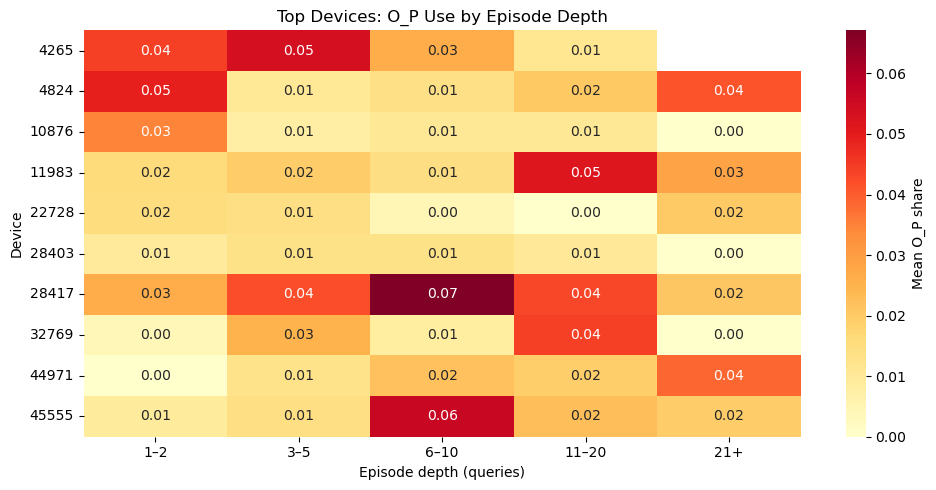

In [185]:
# Pick top devices by total O_P count
top_devices = (df.groupby("device_name_actual")["O_P"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(10)
                 .index)

# Episode-level stats for those devices
top_ep = ep_stats[ep_stats["device_name_actual"].isin(top_devices)].copy()

# Bin episode depth
depth_bins = [1, 2, 5, 10, 20, np.inf]
depth_labels = ["1–2", "3–5", "6–10", "11–20", "21+"]
top_ep["depth_bin"] = pd.cut(top_ep["episode_depth"],
                             bins=depth_bins, labels=depth_labels, right=True)

# Pivot for heatmap
heat = top_ep.groupby(["device_name_actual", "depth_bin"])["episode_O_P_share"].mean().unstack("depth_bin")

plt.figure(figsize=(10, 5))
sns.heatmap(
    heat,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={"label": "Mean O_P share"}
)
plt.xlabel("Episode depth (queries)")
plt.ylabel("Device")
plt.title("Top Devices: O_P Use by Episode Depth")
plt.tight_layout()
plt.show

**Key Findings**
- For most devices, O_P shares stay low across all depths (generally below 0.07), reinforcing that possibility questions remain a minority behaviour even among the heaviest users.

- Several devices (eg. 28417, 44971, 45555) show higher O_P shares in mid‑ or deep‑depth bins (6–10 or 11–20 queries), suggesting that some heavy users lean more on possibility questions during longer, more exploratory episodes, whereas others (e.g. 4824, 22728) keep O_P usage low regardless of depth.

#### (i) Possibility Question Usage Across the Day

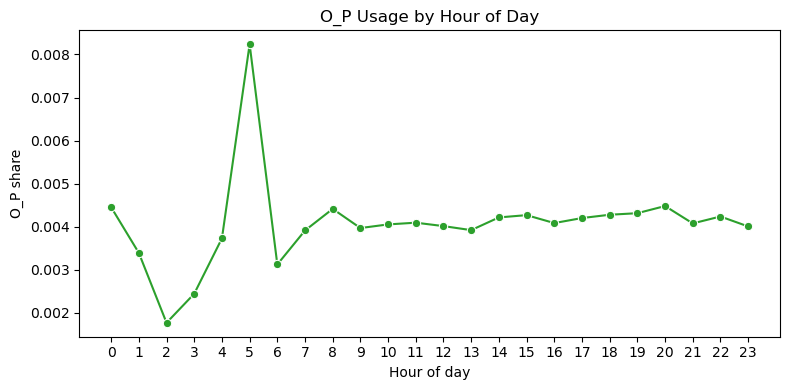

In [186]:
hour_stats = (
    df.groupby("hour")
      .agg(
          O_P_share=("O_P", "mean"),
          n_queries=("O_P", "size")
      )
      .reset_index()
)

plt.figure(figsize=(8, 4))
sns.lineplot(
    data=hour_stats,
    x="hour",
    y="O_P_share",
    marker="o",
    color="#2ca02c"
)
plt.xlabel("Hour of day")
plt.ylabel("O_P share")
plt.title("O_P Usage by Hour of Day")
plt.xticks(range(0, 24, 1))
plt.tight_layout()
plt.show()

**Key Findings**
- O_P share hovers around 0.003–0.0045 for most hours, indicating that possibility questions are consistently rare at all times.

- There is a sharp spike around 5 a.m. plus some noise in the very early hours, which likely reflects small sample sizes rather than a systematic behavioural peak; daytime and evening hours look quite flat.


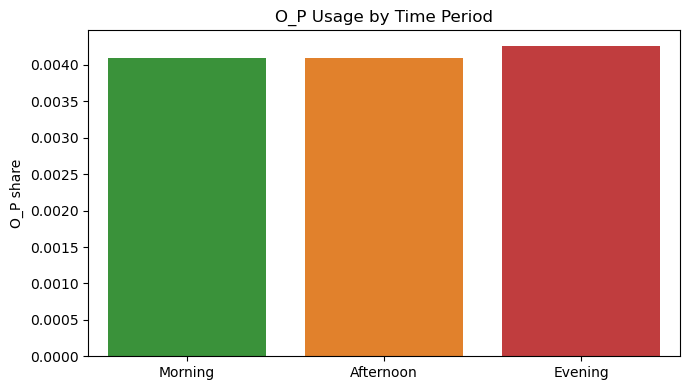

In [187]:
def period_from_hour(h):
    if 6 <= h < 12:
        return "Morning"
    elif 12 <= h < 18:
        return "Afternoon"
    else:
        return "Evening"

df["time_period"] = df["hour"].apply(period_from_hour)

period_stats = (
    df.groupby("time_period")
      .agg(O_P_share=("O_P", "mean"))
      .reindex(["Morning", "Afternoon", "Evening"])
      .reset_index()
)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=period_stats,
    x="time_period",
    y="O_P_share",
    palette=["#2ca02c", "#ff7f0e", "#d62728"]
)
plt.xlabel("")
plt.ylabel("O_P share")
plt.title("O_P Usage by Time Period")
plt.tight_layout()
plt.show()

**Key Findings**
- Morning, afternoon, and evening bars are very similar in height, with only a slight increase in the evening, confirming that once hours are aggregated, time‑of‑day differences in O_P usage are minimal.

- This supports the interpretation that possibility‑style querying is not strongly tied to circadian patterns, unlike some behaviours that peak in late‑night or after‑school windows.


## 5.10 Feature 10: Closed, Non-Possibility Type Questions (C_NP)

**C_NP Feature**

The **C_NP** feature identifies queries that are **closed-ended questions** and are **not framed as hypothetical or possibility-based questions**. This captures user intent to request concrete, factual, or definitive information rather than exploring potential outcomes or conditions.

- The calculation is based on the **first token** of the query (`search_q`) to determine the type of question.
- **Closed, non-possibility tokens:** (`'must'`, `'should'`, `'do'`, `'is'`, `'are'`, `'does'`, `'did'`, `'have'`, `'has'`)
- Queries that **start with any of the above tokens** are flagged as `C_NP = True`.
- All other queries are flagged as `C_NP = False`.

---

### Processing Logic

**Token Extraction and Rule Application**

- Each query is converted to lowercase (`str.lower()`) to ensure consistent token matching.
- The **first token** of each query is extracted using `str.split(n=1).str[0]`.
- A query is flagged as `C_NP = True` **if the first token is in the set of closed, non-possibility tokens**.
- The computation is performed in **fixed-size chunks** to handle large datasets efficiently.
- The `C_NP` column is added **without removing or reordering any rows**.

---

**Example**

| search_q                     | C_NP  |
|-------------------------------|-------|
| Do you like ice cream?        | True  |
| What is your name?            | False |
| Should I go now?              | True  |
| How are you?                  | False |
| Has she finished her work?    | True |
| Tell me a story.              | False |

- Queries flagged as `True` satisfy the **closed, non-possibility question** rule.
- Queries flagged as `False` either **do not start with a closed token** or are **open/hypothetical in nature**.


In [207]:
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Closed, non-possibility token rules
# -----------------------------
closed_nonpos_tokens = ('must', 'should', 'do', 'is', 'are', 'does', 'did', 'have', 'has')

# -----------------------------
# Initialize a temporary series for C_NP
# -----------------------------
c_np_series = pd.Series(False, index=df.index)  # default False

# -----------------------------
# Chunk processing
# -----------------------------
chunksize = 100_000
total_rows = len(df)

for start in tqdm(range(0, total_rows, chunksize), desc="Processing chunks for C_NP"):
    end = min(start + chunksize, total_rows)
    
    # Lowercase query text
    q = df.iloc[start:end]['search_q'].astype(str).str.lower()
    
    # Extract first token
    first_token = q.str.split(n=1).str[0]
    
    # Condition: first token in closed_nonpos_tokens
    cond_c_np = first_token.isin(closed_nonpos_tokens)
    
    # Assign to temporary series
    c_np_series.iloc[start:end] = cond_c_np

# -----------------------------
# Append as the last column without changing existing column order
# -----------------------------
df = pd.concat([df, c_np_series.rename('C_NP')], axis=1)

# Verify
df.head()


Processing chunks for C_NP: 100%|███████████████| 34/34 [00:20<00:00,  1.62it/s]


school_name                 created_at  \
0  orchid_park_secondary  2023-07-09 21:06:21+00:00   
1  orchid_park_secondary  2023-07-09 21:21:00+00:00   
2  orchid_park_secondary  2023-07-09 21:21:54+00:00   
3  orchid_park_secondary  2023-07-09 21:24:07+00:00   
4  orchid_park_secondary  2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ...  \
0            True           False        1.0  ...   
1            True           False        2.0  ...   
2           False           False        2.0  ...   
3           False           False        2.0  ...   
4           False           False        2.0  ...   

  reformulation_levenshtein_norm  is_reformulation time_interval time_total  \
0                           0.00             False          0.00       0.00   
1                           0.97              True         71.33     285.32   
2                           0.12              True         71.33     285.32   
3                           0.53              True         71.33     285.32   
4                           0.41              True         71.33     285.32   

  num_query_episode   O_NP                                  tokens  n_tokens  \
0               1.0  False                                    [wy]         1   
1               4.0  False    [hospital, between, 1959, and, 1970]         5   
2               4.0  False  [hospital, between, 1960s, and, 1970s]         5   
3               4.0  False                 [hospital, after, 1965]         3   
4               4.0  False  [hospital, after, 1965, in, singapore]         5   

     O_P   C_NP  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4  False  False  

[5 rows x 27 columns]

#### (a) Distribution of User Closed Question Reliance
**(i) Histogram**

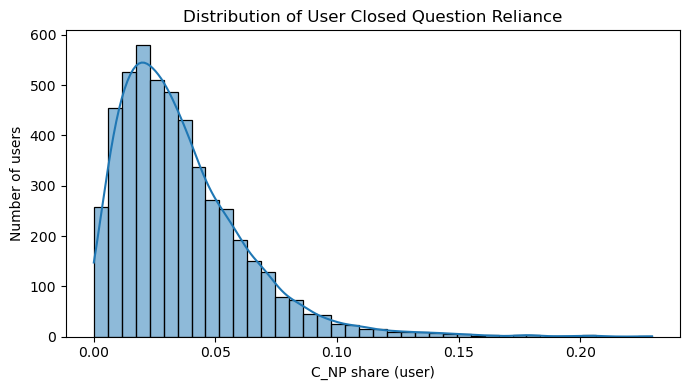

In [233]:
plt.figure(figsize=(7, 4))
sns.histplot(data=user_cnp, x='C_NP_share', bins=40, kde=True)
plt.xlabel("C_NP share (user)")
plt.ylabel("Number of users")
plt.title("Distribution of User Closed Question Reliance")
plt.tight_layout()
plt.show()


**Key Findings**
- The distribution is strongly right‑skewed: most users have C_NP shares between roughly 0 and 0.05, and the peak is very close to zero, meaning the typical user uses closed questions only in a small fraction of their queries.

- There is a thin tail of users with higher C_NP shares (up to about 0.2), indicating a distinct minority who habitually frame a much larger portion of their searches as closed, non‑possibility questions compared with the majority.


**(ii) Pie Chart**

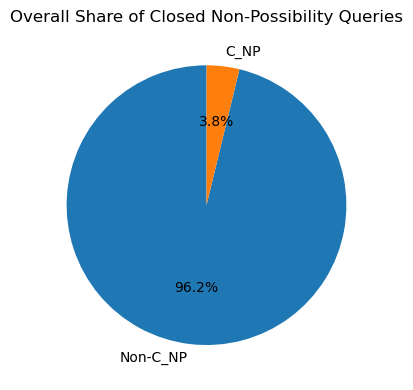

In [234]:
counts = df['C_NP'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=['Non‑C_NP','C_NP'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Overall Share of Closed Non‑Possibility Queries")
plt.tight_layout()
plt.show()


**Key Findings**
- Only about 3.8% of all queries are C_NP, while roughly 96.2% are other types, showing that users overwhelmingly favour queries that are not closed, non‑possibility questions.

- This reinforces that the closed‑question signal is sparse but meaningful: when users do choose C_NP phrasing, it likely reflects a specific intent for definitive, yes/no or factual answers, rather than their default search style.


#### Episode Depth and Duration by Closed Question Level

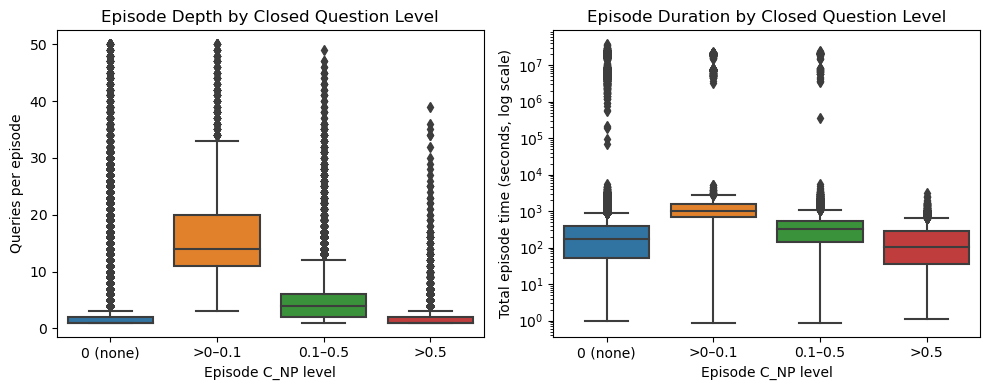

In [235]:
ep = (
    df.groupby(['device_name_actual','q_episode'])
      .agg(
          C_NP_share=('C_NP','mean'),
          num_queries=('num_query_episode','max'),
          time_total=('time_total','max')
      )
      .reset_index()
)

ep['C_NP_level'] = pd.cut(
    ep['C_NP_share'],
    bins=[-1e-9, 0, 0.1, 0.5, 1.0],
    labels=["0 (none)", ">0–0.1", "0.1–0.5", ">0.5"],
    include_lowest=True
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# 1) Depth: cap very long episodes so boxes are visible
sns.boxplot(
    data=ep[ep['num_queries'] <= 50],   # drop ultra‑long tails for clarity
    x='C_NP_level', y='num_queries', ax=axes[0]
)
axes[0].set_xlabel("Episode C_NP level")
axes[0].set_ylabel("Queries per episode")
axes[0].set_title("Episode Depth by Closed Question Level")

# 2) Duration: use log scale
sns.boxplot(
    data=ep[ep['time_total'] > 0],
    x='C_NP_level', y='time_total', ax=axes[1]
)
axes[1].set_yscale('log')
axes[1].set_xlabel("Episode C_NP level")
axes[1].set_ylabel("Total episode time (seconds, log scale)")
axes[1].set_title("Episode Duration by Closed Question Level")

plt.tight_layout()
plt.show()


**Key Findings**
- On the left, episodes with no closed questions are typically shallow, with medians of only a few queries, while episodes that include some C_NP (especially the >0–0.1 band) have noticeably higher median depths; however, all bands show very wide variability, so closed questions are not exclusive to very long or very short episodes.

- On the right, using a log scale for duration reveals a similar pattern: median episode time increases slightly from 0 to low C_NP levels, but all levels share long‑tailed distributions, indicating that extremely long episodes can occur with or without closed questions.



#### (c) Query Length by Closed Non‑Possibility Question Type

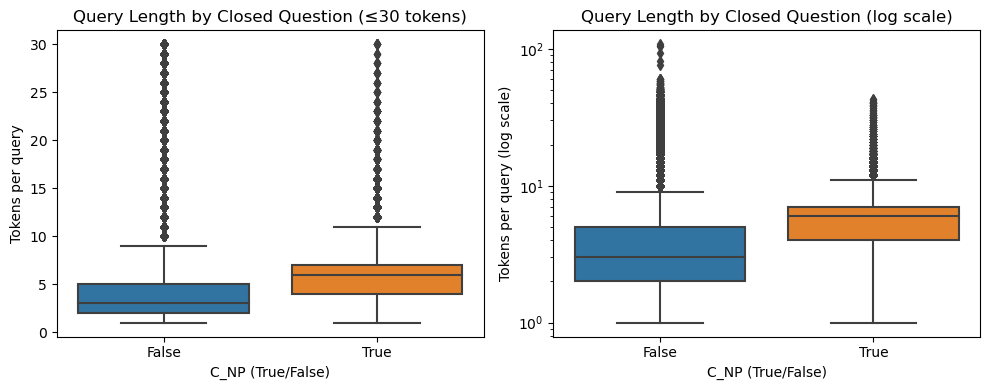

In [236]:
import numpy as np

# Trim to focus on typical queries (e.g. ≤ 30 tokens)
df_trim = df[df['n_tokens'] <= 30].copy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# 1) Trimmed boxplot (typical behaviour)
sns.boxplot(data=df_trim, x='C_NP', y='n_tokens', ax=axes[0])
axes[0].set_xlabel("C_NP (True/False)")
axes[0].set_ylabel("Tokens per query")
axes[0].set_title("Query Length by Closed Question (≤30 tokens)")

# 2) Log-scale boxplot (full range but readable)
sns.boxplot(data=df[df['n_tokens'] > 0], x='C_NP', y='n_tokens', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel("C_NP (True/False)")
axes[1].set_ylabel("Tokens per query (log scale)")
axes[1].set_title("Query Length by Closed Question (log scale)")

plt.tight_layout()
plt.show()


**Key Findings**
- In the trimmed view (≤30 tokens), the median and IQR are higher for C_NP=True, meaning closed questions usually contain a few more tokens than other queries, rather than being terse yes/no prompts.

- The log‑scale plot shows that both C_NP and non‑C_NP queries can be extremely long, but the bulk mass of C_NP queries sits at somewhat higher token counts, indicating that users often add more context when they phrase a search as a closed question.



#### (d) Individual Reliance on Closed Non‑Possibility Questions

**(i) How Many Users Rely on Closed Questions?**

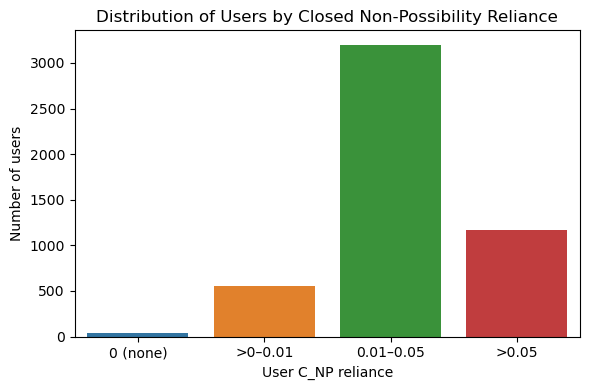

In [218]:
# define levels; avoid duplicate 0 edge
user_cnp['C_NP_level'] = pd.cut(
    user_cnp['C_NP_share'],
    bins=[-1e-9, 0, 0.01, 0.05, 1.0],
    labels=["0 (none)", ">0–0.01", "0.01–0.05", ">0.05"],
    include_lowest=True
)

plt.figure(figsize=(6, 4))
sns.countplot(
    data=user_cnp,
    x="C_NP_level",
    order=["0 (none)", ">0–0.01", "0.01–0.05", ">0.05"]
)
plt.xlabel("User C_NP reliance")
plt.ylabel("Number of users")
plt.title("Distribution of Users by Closed Non‑Possibility Reliance")
plt.tight_layout()
plt.show()


**Key Findings**
- The bar chart shows that only a small group of users have zero C_NP queries, while the majority fall in the 0.01–0.05 share band, meaning closed questions make up between 1% and 5% of their queries.

- A substantial minority of users have C_NP shares above 0.05, indicating distinct “closed‑question‑leaning” individuals whose behaviour differs from the bulk of the population.



**(ii) Are Closed‑Question Users More Verbose?**

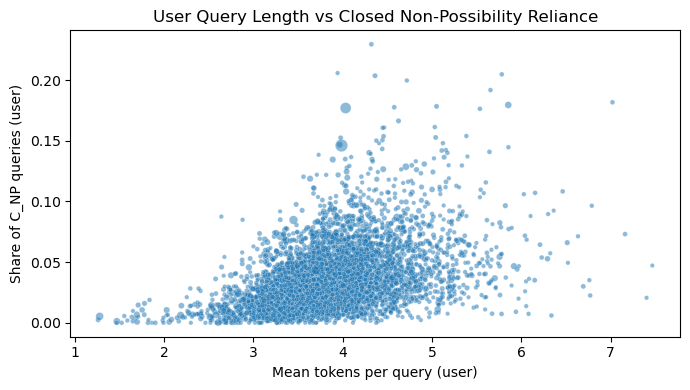

In [237]:
plt.figure(figsize=(7, 4))
ax = sns.scatterplot(
    data=user_cnp,
    x='mean_tokens',
    y='C_NP_share',
    size='n_queries',
    sizes=(10, 80),
    alpha=0.5
)
plt.xlabel("Mean tokens per query (user)")
plt.ylabel("Share of C_NP queries (user)")
plt.title("User Query Length vs Closed Non‑Possibility Reliance")

# remove the automatic size legend
ax.legend_.remove()          # or: plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


**Key Findings**
- The scatterplot shows a positive but noisy association: users with higher C_NP shares tend to have higher mean tokens per query, clustering from roughly 3 to 6 tokens as C_NP_share rises, while low‑C_NP users are concentrated at shorter average lengths.

- Point sizes indicate that this pattern holds for both smaller and very heavy users, suggesting that the link between verbosity and closed‑question reliance is not just a small‑sample artifact but a consistent individual‑style trend.




**(iii) iii. How Do Closed and Possibility Questions Co‑occur Across Users?**

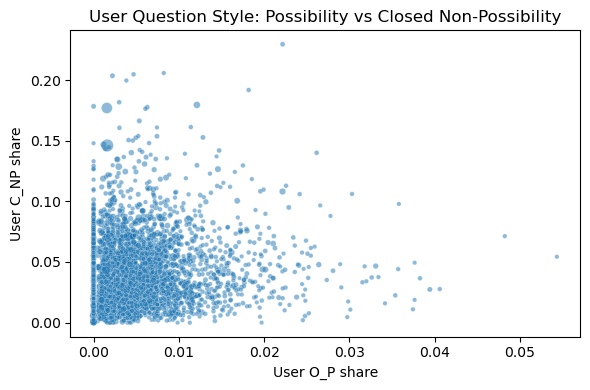

In [238]:
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(
    data=user_mix,
    x='O_P_share',
    y='C_NP_share',
    size='n_queries',
    sizes=(10, 80),
    alpha=0.5
)
ax.legend_.remove()          # hides the size legend

plt.xlabel("User O_P share")
plt.ylabel("User C_NP share")
plt.title("User Question Style: Possibility vs Closed Non‑Possibility")
plt.tight_layout()
plt.show()



**Key Findings**
- Users show much more variation in C_NP share than in O_P share: most points sit at very low O_P_share (close to 0–0.01) but spread widely in C_NP_share up to around 0.2, so closed questions are the main axis along which user styles differ.

- There is no clear correlation between O_P_share and C_NP_share: high‑O_P users appear at both low and high C_NP levels, which implies that possibility‑style and closed‑style questioning are largely independent dimensions of user behaviour rather than opposing ends of a single spectrum.


#### (e) Top Users’ Closed Question Use Across Episode Depths


/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_85201/916088252.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep_top['depth_bin'] = pd.cut(ep_top['num_queries'], bins=bins, labels=labels, include_lowest=True)


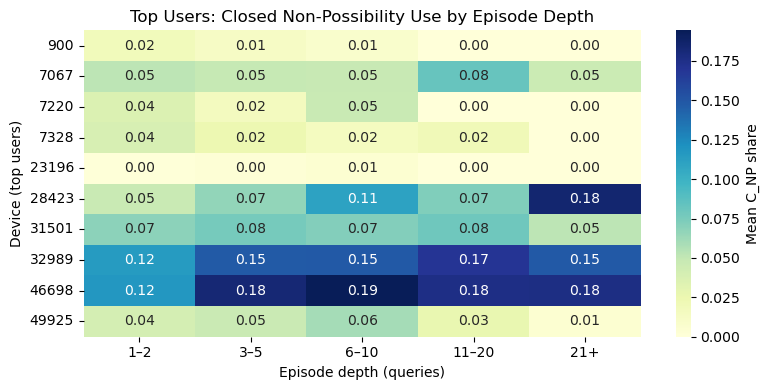

In [211]:
# Episode-level C_NP share
ep_level_cnp = (
    df.groupby(['device_name_actual', 'q_episode'])
      .agg(
          C_NP_share=('C_NP', 'mean'),
          num_queries=('q_episode', 'size')
      )
      .reset_index()
)

# pick top K users by number of episodes
top_users = (
    ep_level_cnp['device_name_actual']
    .value_counts()
    .head(10)
    .index
)
ep_top = ep_level_cnp[ep_level_cnp['device_name_actual'].isin(top_users)]

# Bin episode depth
bins = [1, 2, 5, 10, 20, np.inf]
labels = ["1–2", "3–5", "6–10", "11–20", "21+"]
ep_top['depth_bin'] = pd.cut(ep_top['num_queries'], bins=bins, labels=labels, include_lowest=True)

heat = (
    ep_top
    .groupby(['device_name_actual', 'depth_bin'])['C_NP_share']
    .mean()
    .unstack('depth_bin')
)

plt.figure(figsize=(8, 4))
sns.heatmap(heat, cmap="YlGnBu", annot=True, fmt=".02f", cbar_kws={'label': 'Mean C_NP share'})
plt.xlabel("Episode depth (queries)")
plt.ylabel("Device (top users)")
plt.title("Top Users: Closed Non‑Possibility Use by Episode Depth")
plt.tight_layout()
plt.show()


**Key Findings**
- Among the top devices, C_NP use is not uniform with depth: some users (e.g. the bottom three rows) show consistently high closed‑question shares across almost all depth bins, while others stay near zero even in long episodes.

- For a few users (such as 28423 and 46689), C_NP share tends to increase in deeper episodes (11–20 or 21+ queries), suggesting that when their sessions become more sustained, they increasingly frame queries in closed, non‑possibility form, whereas other top users maintain stable or even declining C_NP rates as episodes lengthen.

#### (f)  User Topic Breadth vs Closed Question Reliance

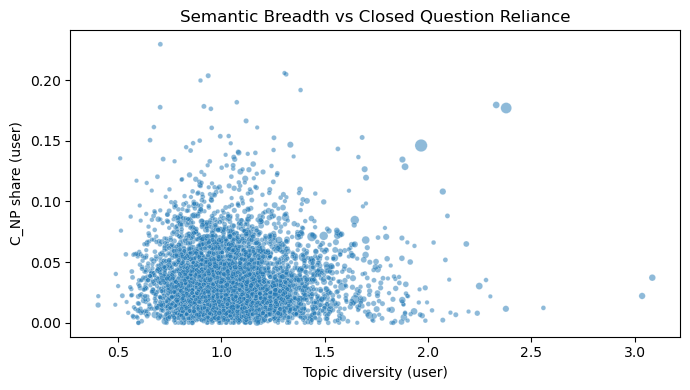

In [240]:
plt.figure(figsize=(7, 4))
ax = sns.scatterplot(
    data=user_sem,
    x="topic_diversity",
    y="C_NP_share",
    size="n_queries",
    sizes=(10, 80),
    alpha=0.5
)
ax.legend_.remove()  # remove the size legend

plt.xlabel("Topic diversity (user)")
plt.ylabel("C_NP share (user)")
plt.title("Semantic Breadth vs Closed Question Reliance")
plt.tight_layout()
plt.show()



**Key Findings**
- Most users cluster around moderate topic diversity (roughly 0.8–1.4) with C_NP shares between about 0 and 0.08, and there is no strong monotonic trend, suggesting that wider topical breadth does not systematically push users toward or away from closed questions.

- A few high‑diversity users still span the full range of C_NP reliance, indicating that question style varies largely independently of semantic breadth: some broadly ranging users lean heavily on closed questions, while others with similar breadth rarely use them.

#### (g) Closed Question Use vs Topic Diversity Within Episodes

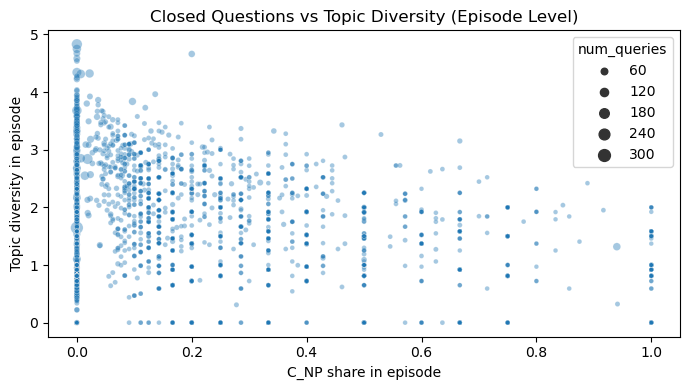

In [243]:
# 1. Attach C_NP to specific_broad
sb = specific_broad.merge(
    df[['school_name', 'device_name_actual', 'q_episode', 'search_q', 'C_NP']],
    on=['school_name', 'device_name_actual', 'q_episode', 'search_q'],
    how='left'
)

# 2. Episode-level aggregation
ep_sem = (
    sb.groupby(['device_name_actual', 'q_episode'])
      .agg(
          C_NP_share=('C_NP', 'mean'),
          topic_diversity=('topic_diversity', 'mean'),
          num_queries=('q_episode', 'size')
      )
      .reset_index()
)

# 3. Sample and plot
sample = ep_sem.sample(n=min(len(ep_sem), 100_000), random_state=42)

plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=sample,
    x='C_NP_share',
    y='topic_diversity',
    size='num_queries',
    sizes=(10, 80),
    alpha=0.4
)
plt.xlabel("C_NP share in episode")
plt.ylabel("Topic diversity in episode")
plt.title("Closed Questions vs Topic Diversity (Episode Level)")
plt.tight_layout()
plt.show()



**Key Findings**
- Most episodes cluster at low C_NP shares (0–0.2) but span a wide range of topic diversity, from focused (near 0) to quite broad (above 3), indicating that episodes can roam across many topics even when closed questions are rare.

- Episodes with very high C_NP shares (above ~0.6) exist but cover the full spectrum of topic diversity as well, suggesting that within‑episode topical breadth is largely independent of how heavily the user leans on closed non‑possibility questions in that episode.



#### (h) Closed Question Usage Across the Day

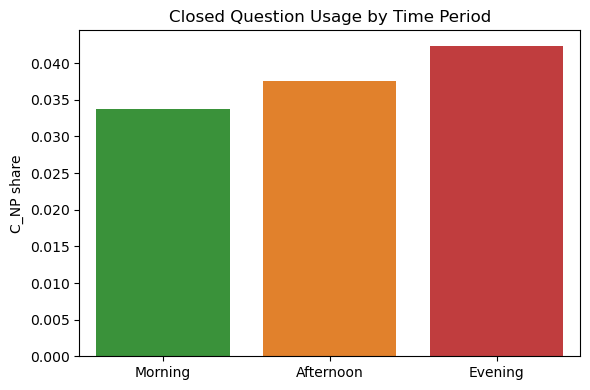

In [231]:
# ensure created_at is datetime
df['created_at'] = pd.to_datetime(df['created_at'])

df['hour'] = df['created_at'].dt.hour

def period_from_hour(h):
    if 6 <= h < 12:
        return "Morning"
    elif 12 <= h < 18:
        return "Afternoon"
    else:
        return "Evening"

df['time_period'] = df['hour'].apply(period_from_hour)

period_stats = (
    df.groupby('time_period')
      .agg(C_NP_share=('C_NP', 'mean'))
      .reindex(['Morning','Afternoon','Evening'])
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=period_stats, x='time_period', y='C_NP_share',
            palette=['#2ca02c','#ff7f0e','#d62728'])
plt.xlabel("")
plt.ylabel("C_NP share")
plt.title("Closed Question Usage by Time Period")
plt.tight_layout()
plt.show()



**Key Finding**
- The C_NP share is lowest in the morning, rises a bit in the afternoon, and is highest in the evening, indicating a mild upward trend in closed‑question usage over the day.

- The absolute differences are small (a few percentage points), so time‑of‑day effects exist but are modest, suggesting that user questioning style is only weakly shaped by when they search


#### (i) Closed Question Rate by Query Specificity

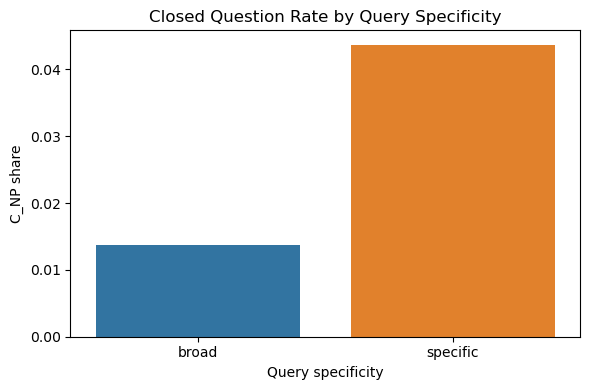

In [232]:
sb = specific_broad.merge(
    df[['school_name','device_name_actual','q_episode','search_q','C_NP']],
    on=['school_name','device_name_actual','q_episode','search_q'],
    how='left'
)

spec_stats = (
    sb.groupby('query_specificity')
      .agg(C_NP_share=('C_NP','mean'))
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=spec_stats, x='query_specificity', y='C_NP_share')
plt.xlabel("Query specificity")
plt.ylabel("C_NP share")
plt.title("Closed Question Rate by Query Specificity")
plt.tight_layout()
plt.show()


**Key Findings**
- Closed questions are much more common for specific queries than for broad ones.

- Specific queries show a substantially higher C_NP share than broad queries (about three times as large in the plot), indicating that users strongly prefer closed formulations when asking targeted questions.

- Broad queries rarely appear as closed questions, suggesting that when users are still exploring a topic, they rely more on open‑ended formulations and only shift into closed non‑possibility mode once their information need is well defined.



## 5.11 Feature 11: Closed, Possibility Type Questions (C_P)

**C_P Feature**

The **C_P** feature identifies queries that are **closed-ended questions** and are **framed as possibility-based or hypothetical questions**. This feature captures user intent to ask about **feasibility, likelihood, permission, or future outcomes**, typically expecting a yes/no or confirmatory response.

- The calculation is based on the **first token** of the query (`search_q`) to determine the type of question.
- **Closed, possibility tokens:** (`'can'`, `'may'`, `'might'`, `'could'`, `'would'`, `'will'`)
- Queries that **start with any of the above tokens** are flagged as `C_P = True`.
- All other queries are flagged as `C_P = False`.

---

### Processing Logic

**Token Extraction and Rule Application**

- Each query is converted to lowercase (`str.lower()`) to ensure consistent token matching.
- The **first token** of each query is extracted using `str.split(n=1).str[0]`.
- A query is flagged as `C_P = True` **if the first token is in the set of closed, possibility tokens**.
- The computation is performed in **fixed-size chunks** to handle large datasets efficiently.
- The `C_P` column is added **without removing, reordering, or modifying any existing rows or columns**.

---

**Example**

| search_q                         | C_P   |
|----------------------------------|-------|
| Can I enter the school early?    | True  |
| Will it rain tomorrow?           | True  |
| Could this method work?          | True  |
| Is this allowed?                 | False |
| How can I improve my grades?     | False |
| What is photosynthesis?          | False |

- Queries flagged as `True` satisfy the **closed, possibility-type question** rule.
- Queries flagged as `False` either **do not begin with a modal/possibility verb** or are **open-ended questions**.


In [244]:
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Closed, possibility token rules
# -----------------------------
closed_pos_tokens = ('can', 'may', 'might', 'could', 'would', 'will')

# -----------------------------
# Initialize temporary series
# -----------------------------
c_p_series = pd.Series(False, index=df.index)

# -----------------------------
# Chunk processing
# -----------------------------
chunksize = 100_000
total_rows = len(df)

for start in tqdm(range(0, total_rows, chunksize), desc="Processing chunks for C_P"):
    end = min(start + chunksize, total_rows)
    
    # Lowercase query text (position-based slicing)
    q = df.iloc[start:end]['search_q'].astype(str).str.lower()
    
    # Extract first token
    first_token = q.str.split(n=1).str[0]
    
    # Condition: closed possibility starter
    cond_c_p = first_token.isin(closed_pos_tokens)
    
    # Assign results
    c_p_series.iloc[start:end] = cond_c_p

# -----------------------------
# Append as new column (NO reordering)
# -----------------------------
df = pd.concat([df, c_p_series.rename('C_P')], axis=1)

# Verify
df.head()


Processing chunks for C_P: 100%|████████████████| 34/34 [00:41<00:00,  1.22s/it]


school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... time_total  \
0            True           False        1.0  ...       0.00   
1            True           False        2.0  ...     285.32   
2           False           False        2.0  ...     285.32   
3           False           False        2.0  ...     285.32   
4           False           False        2.0  ...     285.32   

   num_query_episode   O_NP                                  tokens n_tokens  \
0                1.0  False                                    [wy]        1   
1                4.0  False    [hospital, between, 1959, and, 1970]        5   
2                4.0  False  [hospital, between, 1960s, and, 1970s]        5   
3                4.0  False                 [hospital, after, 1965]        3   
4                4.0  False  [hospital, after, 1965, in, singapore]        5   

     O_P   C_NP  hour  time_period    C_P  
0  False  False  21.0      Evening  False  
1  False  False  21.0      Evening  False  
2  False  False  21.0      Evening  False  
3  False  False  21.0      Evening  False  
4  False  False  21.0      Evening  False  

[5 rows x 30 columns]

#### (a) Distribution of Users by Closed Possibility Question Rate
**(i) Histogram**

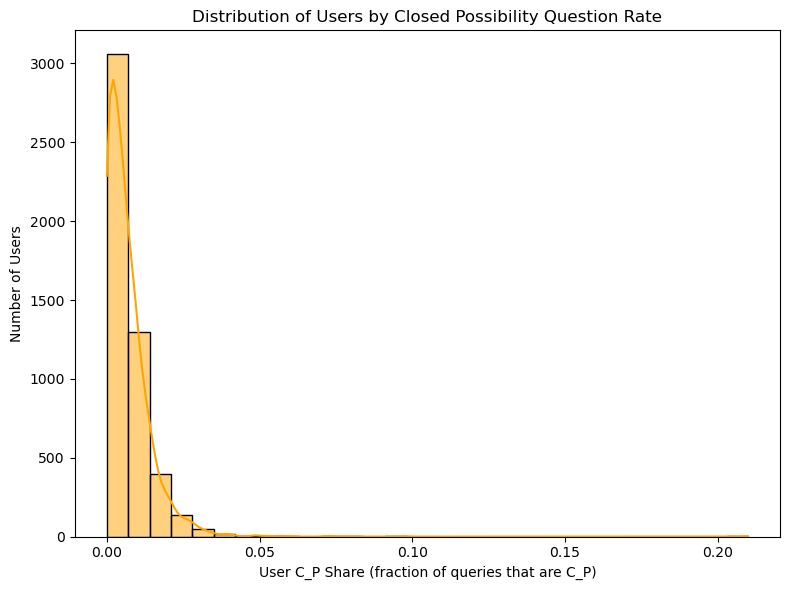

In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Per-user C_P share
user_cp = (
    df.groupby('device_name_actual', dropna=False)['C_P']
      .mean()
      .reset_index(name='cp_share')
)

plt.figure(figsize=(8, 6))
sns.histplot(user_cp['cp_share'], bins=30, color="orange", kde=True)
plt.xlabel('User C_P Share (fraction of queries that are C_P)')
plt.ylabel('Number of Users')
plt.title('Distribution of Users by Closed Possibility Question Rate')
plt.tight_layout()
plt.show()

**Key Findings**
- The distribution is highly right‑skewed: almost all users have C_P shares very close to zero, meaning they almost never ask closed possibility questions (e.g. “can/may/will …”).

- Only a small minority of users form a long tail with noticeably higher C_P rates, and even these rarely exceed about 0.2, indicating that habitual use of possibility‑framed questions is uncommon and concentrated in a few individuals.



**(ii) Bar Chart**

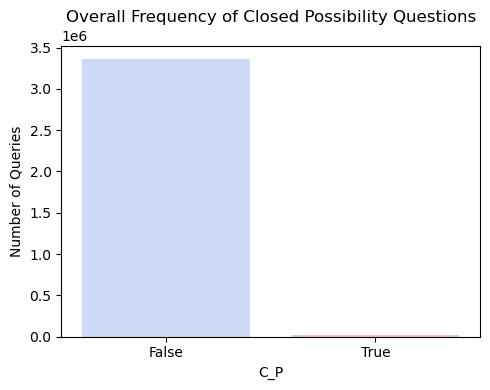

In [295]:
cp_counts = df['C_P'].value_counts().sort_index()

plt.figure(figsize=(5, 4))
sns.barplot(
    x=cp_counts.index.map({False: 'False', True: 'True'}),
    y=cp_counts.values,
    palette=['#c7d9ff', '#ffb3c6']  # pastel blue, pastel pink
)
plt.ylabel('Number of Queries')
plt.xlabel('C_P')
plt.title('Overall Frequency of Closed Possibility Questions')
plt.tight_layout()
plt.show()


**Key Findings**
- Closed possibility questions are extremely rare at the query level: virtually all queries fall in the C_P = False bar, with only a tiny fraction flagged as C_P = True.

- This confirms that possibility framing is a niche query style, which helps interpret the later plots: even users or segments that “use C_P more” are doing so against a backdrop where such questions are scarce overall.


#### (b) Closed Possibility Question Rate vs User Query Volume


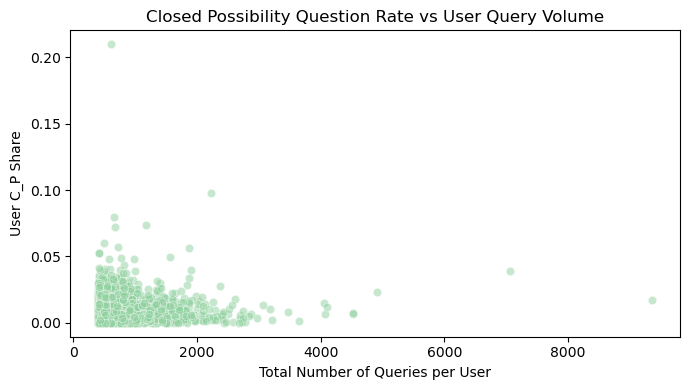

In [290]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=user_volume_cp,
    x='num_queries',
    y='cp_share',
    alpha=0.5,
    color='#8fd19e'   # pastel green
)
plt.xlabel('Total Number of Queries per User')
plt.ylabel('User C_P Share')
plt.title('Closed Possibility Question Rate vs User Query Volume')
plt.tight_layout()
plt.show()



**Key Findings**
- Across almost the entire x‑axis, C_P shares stay very close to zero, so even high‑volume users rarely phrase queries as possibility questions.

- There is no strong upward trend with volume. If anything, the highest C_P shares appear among low‑ to mid‑volume users, suggesting that being a heavy searcher does not make someone more modal‑question‑oriented.



#### (c) User Query Length vs Closed Possibility Question Rate

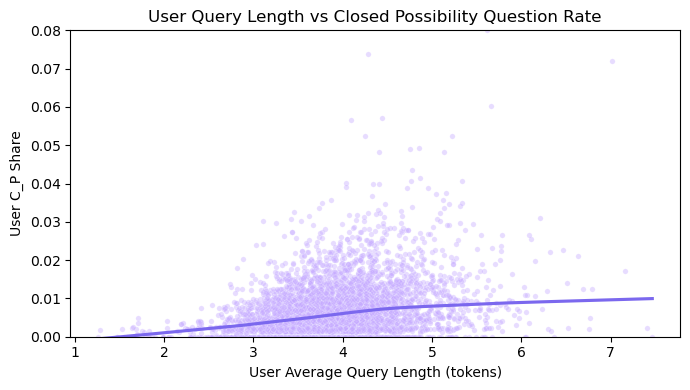

In [292]:
plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=user_len_cp,
    x='avg_query_len',
    y='cp_share',
    alpha=0.4,
    s=15,
    color='#c4a8ff'  # pastel purple
)

# Optional smoothing line
sns.regplot(
    data=user_len_cp,
    x='avg_query_len',
    y='cp_share',
    scatter=False,
    lowess=True,
    color='#7b68ee'
)

plt.ylim(0, 0.08)  # focuses on main mass; note outliers in text
plt.xlabel('User Average Query Length (tokens)')
plt.ylabel('User C_P Share')
plt.title('User Query Length vs Closed Possibility Question Rate')
plt.tight_layout()
plt.show()


**Key Findings**
- There is a slight upward trend in the smoothed line from about 2 to 6 tokens, showing that users who typically write longer queries are somewhat more likely to use closed possibility questions, but the increase is small in absolute terms.

- The cloud of points remains heavily concentrated below a C_P share of 0.02 across all lengths, indicating that even verbose users rarely rely on possibility‑framed questions; longer queries make C_P a bit more common but do not turn it into a dominant style.



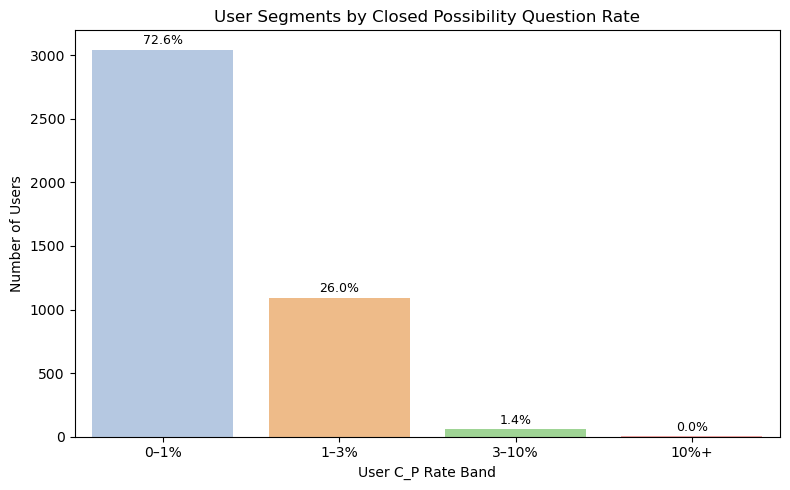

In [294]:
from matplotlib.colors import ListedColormap

user_cp_bins = user_cp.copy()
user_cp_bins['cp_bin'] = pd.cut(
    user_cp_bins['cp_share'],
    bins=[0, 0.01, 0.03, 0.1, 1.0],
    labels=['0–1%', '1–3%', '3–10%', '10%+']
)

pastel_colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']  # soft blue, orange, green, pink

counts = user_cp_bins['cp_bin'].value_counts().reindex(['0–1%', '1–3%', '3–10%', '10%+'])
total = counts.sum()

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=pastel_colors
)
for i, v in enumerate(counts.values):
    ax.text(i, v + 20, f"{v/total:.1%}", ha='center', va='bottom', fontsize=9)

plt.xlabel('User C_P Rate Band')
plt.ylabel('Number of Users')
plt.title('User Segments by Closed Possibility Question Rate')
plt.tight_layout()
plt.show()

#### (d) Episode Structure and Closed Possibility Question Share

**(i) Episode Depth vs Closed Possibility Question Share**

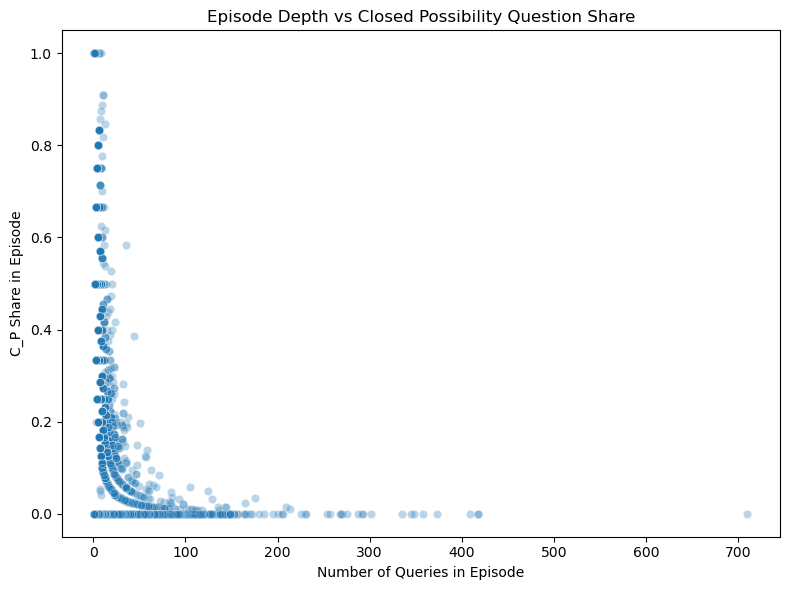

In [251]:
# Episode-level aggregates
ep_cp = (
    df.groupby(['device_name_actual', 'q_episode'], dropna=False)
      .agg(
          cp_share=('C_P', 'mean'),
          num_queries=('num_query_episode', 'max')  # or 'search_q': 'size'
      )
      .reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ep_cp,
    x='num_queries',
    y='cp_share',
    alpha=0.3
)
plt.xlabel('Number of Queries in Episode')
plt.ylabel('C_P Share in Episode')
plt.title('Episode Depth vs Closed Possibility Question Share')
plt.tight_layout()
plt.show()


**(ii) Episode Tempo vs Closed Possibility Question Share**

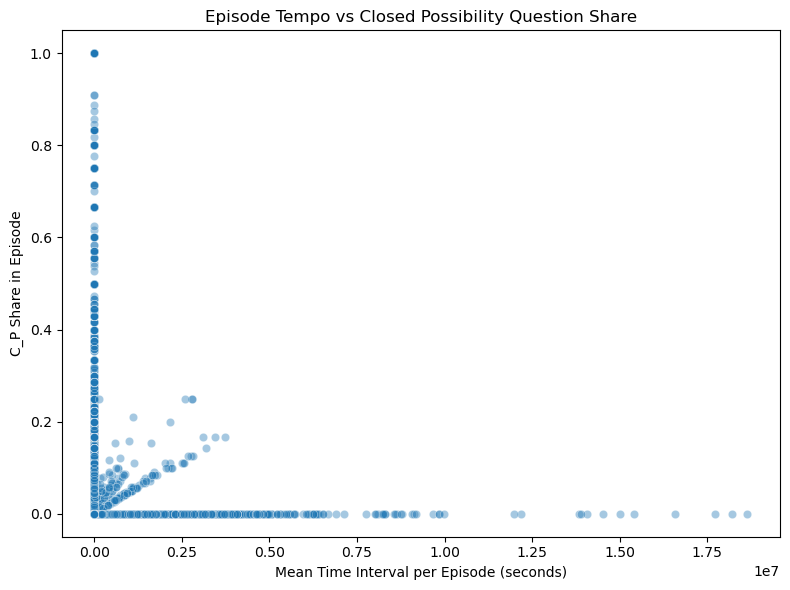

In [265]:
min_q = 2
ep_tempo_cp = eplevel_cp[eplevel_cp['num_queries'] >= min_q].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ep_tempo_cp,
    x='mean_interval',
    y='cp_share',
    alpha=0.4
)
plt.xlabel('Mean Time Interval per Episode (seconds)')
plt.ylabel('C_P Share in Episode')
plt.title('Episode Tempo vs Closed Possibility Question Share')
plt.tight_layout()
plt.show()



**Key Findings**
- Episodes with very short average time gaps between queries (fast‑paced sessions) cover the full range of C_P shares from 0 to 1, indicating that bursts of possibility questions occur, but only in a subset of these rapid episodes.

- As the mean interval per episode increases into slower, more sporadic sessions, C_P share almost always drops to zero, suggesting that possibility‑framed questions are rare in long‑running, low‑tempo episodes dominated by occasional queries.

#### (e) How Do Power Users Ask Possibility Questions?
**(i) Closed Possibility Question Rate for Top Users**

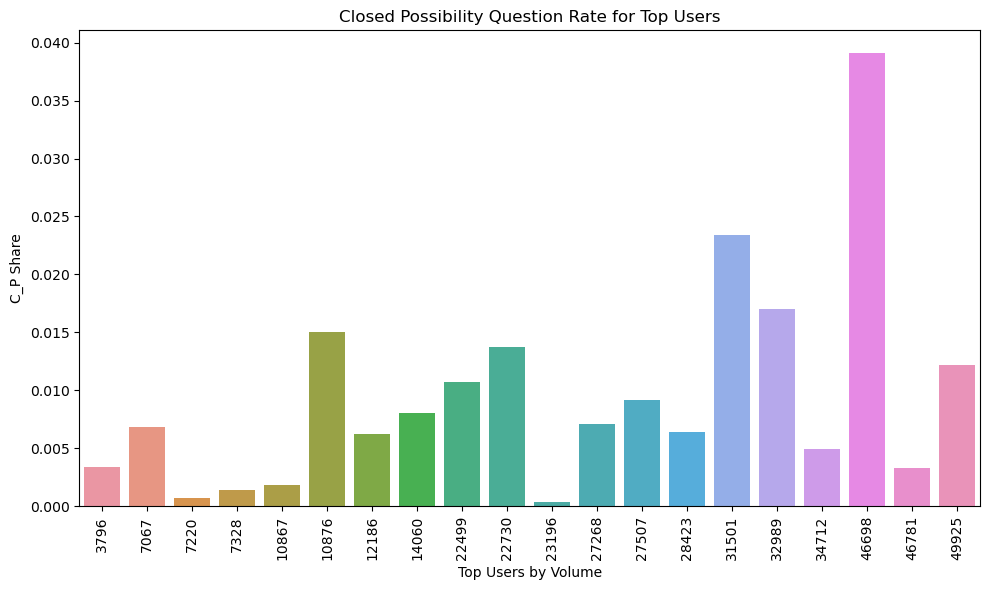

In [271]:
topn = 20
top_users = (
    df['device_name_actual']
    .value_counts()
    .head(topn)
    .index
)

dftop = df[df['device_name_actual'].isin(top_users)].copy()

top_user_cp = (
    dftop.groupby('device_name_actual', dropna=False)['C_P']
         .mean()
         .reset_index(name='cp_share')
         .sort_values('cp_share', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_user_cp,
    x='device_name_actual',
    y='cp_share'
)
plt.xticks(rotation=90)
plt.xlabel('Top Users by Volume')
plt.ylabel('C_P Share')
plt.title('Closed Possibility Question Rate for Top Users')
plt.tight_layout()
plt.show()



**Key Findings**
- Even among the highest‑volume users, C_P shares are low overall, mostly below about 4%, so possibility questions remain rare even for power users.

- A few top users stand out with noticeably higher C_P shares than their peers, indicating small clusters of users who are relatively more inclined to phrase queries as closed possibility questions.


**(ii) Pacing vs Closed Possibility Question Use for Top Users**

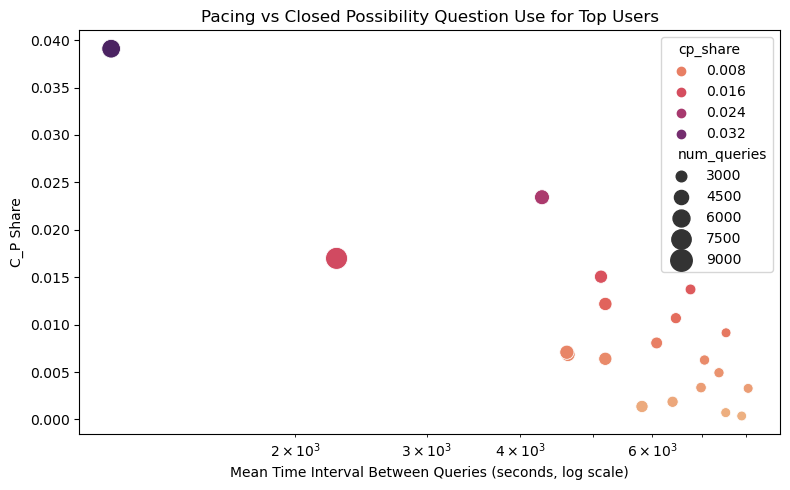

In [297]:
topn = 20
top_users = (
    df['device_name_actual']
      .value_counts()
      .head(topn)
      .index
)

dftop = df[df['device_name_actual'].isin(top_users)].copy()

user_stats = (
    dftop.groupby('device_name_actual', dropna=False)
          .agg(
              cp_share=('C_P', 'mean'),
              mean_interval=('time_interval', 'mean'),
              num_queries=('C_P', 'size')
          )
          .reset_index()
)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=user_stats,
    x='mean_interval',
    y='cp_share',
    size='num_queries',
    sizes=(50, 250),
    hue='cp_share',
    palette='flare'
)
plt.xscale('log')
plt.xlabel('Mean Time Interval Between Queries (seconds, log scale)')
plt.ylabel('C_P Share')
plt.title('Pacing vs Closed Possibility Question Use for Top Users')
plt.tight_layout()
plt.show()


**Key Findings**
- Most points cluster at low C_P share (below about 0.015) across a wide range of mean inter‑query intervals, so even very active users with different tempos rarely rely heavily on closed possibility questions.

- A small number of users stand out: one very fast‑paced user (left side of the x‑axis) with the highest C_P share (~0.04) and substantial volume, and one or two moderately paced users with elevated C_P shares, indicating that sustained preference for possibility‑framed questions is concentrated in a few particular power users rather than being a general effect of pacing.

#### (f) Query Length Differences for Closed Possibility vs Other Questions

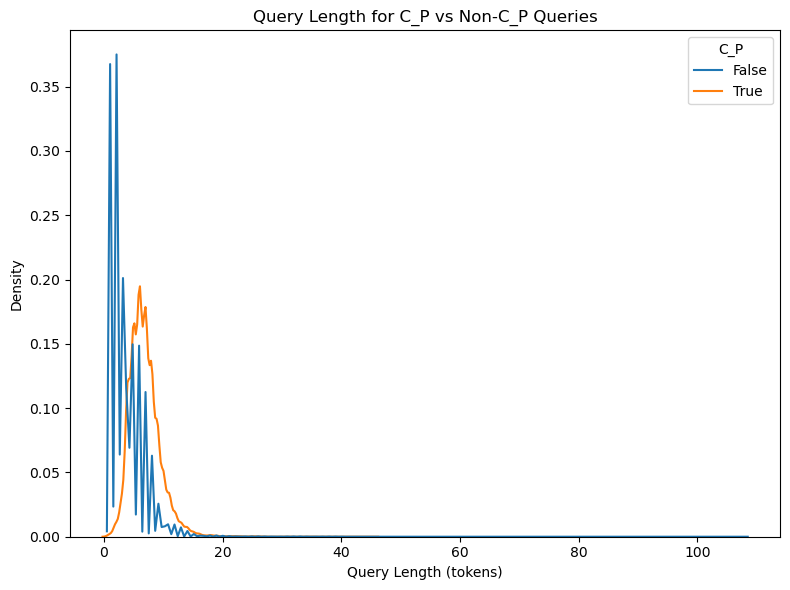

In [273]:
if length_col is not None:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        data=df,
        x=length_col,
        hue='C_P',
        common_norm=False,
        bw_adjust=1.2
    )
    plt.xlabel('Query Length (tokens)')
    plt.ylabel('Density')
    plt.title('Query Length for C_P vs Non-C_P Queries')
    plt.tight_layout()
    plt.show()


**Key Findings**
- The C_P curve (True) is shifted to the right relative to the non‑C_P curve, meaning closed possibility questions tend to have longer query lengths in tokens than other queries.

- Both distributions remain concentrated in the short‑query range, but C_P queries are less common among very short (1–3 token) queries and relatively more common around mid‑length queries, which is consistent with needing extra words to express modality (eg. “can”, “will”, “may”, plus context).

#### (g) How Diversity and Specificity Shape Closed Possibility Question Use

**(i) Episode Topic Diversity vs Closed Possibility Question Share**

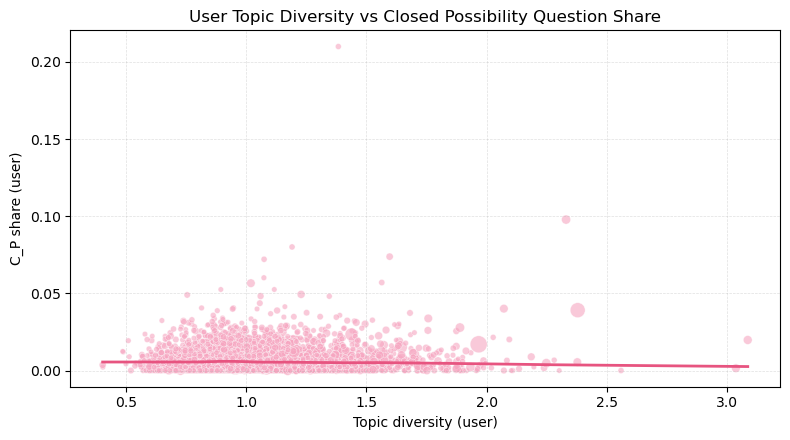

In [306]:
import statsmodels.api as sm

plt.figure(figsize=(8, 4.5))

ax = sns.scatterplot(
    data=user_sem_cp,
    x="topic_diversity",
    y="C_P_share",
    size="n_queries",
    sizes=(15, 150),
    alpha=0.6,
    color="#f6a5c0",          # pastel pink
    edgecolor="white",
    linewidth=0.4
)

x = user_sem_cp["topic_diversity"].values
y = user_sem_cp["C_P_share"].values
lowess = sm.nonparametric.lowess(y, x, frac=0.3, return_sorted=True)
ax.plot(lowess[:, 0], lowess[:, 1], color="#e75480", linewidth=2)

ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.4)

# Remove legend completely
if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.xlabel("Topic diversity (user)")
plt.ylabel("C_P share (user)")
plt.title("User Topic Diversity vs Closed Possibility Question Share")
plt.tight_layout()
plt.show()




**Key Finding**
- Across the full range of topic diversity, nearly all users have C_P shares clustered very close to zero, and even the largest bubbles (heaviest users) stay in this low band, indicating that semantic breadth does not drive frequent use of closed possibility questions.

- A small number of users achieve slightly higher C_P shares (up to a few percent) at moderate topic diversity values, but these are clear outliers, so sustained reliance on possibility‑framed questions is confined to a tiny fraction of the user base.


**(ii) User Lexical Diversity vs Closed Possibility Question Share**

/Users/tdf/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


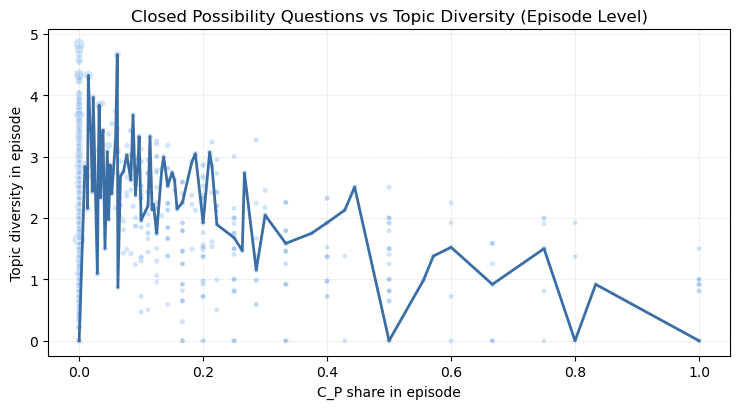

In [308]:
import statsmodels.api as sm

# Attach C_P to specific_broad / topic_diversity frame
sb_cp = specific_broad.merge(
    df[['school_name', 'device_name_actual', 'q_episode', 'search_q', 'C_P']],
    on=['school_name', 'device_name_actual', 'q_episode', 'search_q'],
    how='left'
)

ep_sem_cp = (
    sb_cp.groupby(['device_name_actual', 'q_episode'], dropna=False)
         .agg(
             C_P_share=('C_P', 'mean'),
             topic_diversity=('topic_diversity', 'mean'),
             num_queries=('q_episode', 'size')
         )
         .reset_index()
)

sample = ep_sem_cp.sample(
    n=min(len(ep_sem_cp), 100_000),
    random_state=42
)

plt.figure(figsize=(7.5, 4.2))

ax = sns.scatterplot(
    data=sample,
    x='C_P_share',
    y='topic_diversity',
    size='num_queries',
    sizes=(12, 90),
    alpha=0.5,
    color='#a1c9f4',      # pastel blue (different from your pink/green/orange)
    edgecolor='white',
    linewidth=0.4
)

# LOWESS trend line
x = sample['C_P_share'].values
y = sample['topic_diversity'].values
lowess = sm.nonparametric.lowess(y, x, frac=0.3, return_sorted=True)
ax.plot(lowess[:, 0], lowess[:, 1], color='#3b6ea5', linewidth=2)

# Light grid
ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.4)

# Remove legend box completely
if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.xlabel("C_P share in episode")
plt.ylabel("Topic diversity in episode")
plt.title("Closed Possibility Questions vs Topic Diversity (Episode Level)")
plt.tight_layout()
plt.show()


**Key Findings**
- This plot shows that episodes almost never rely heavily on closed possibility questions, and topic diversity stays fairly similar across different C_P shares.

- The dense vertical band at very low C_P share (near 0) with topic diversity spread from roughly 0 to 5 shows that most episodes contain few or no closed possibility questions, regardless of how many topics they cover.

- The smoothed line stays relatively flat and then drifts downward as C_P share increases, indicating at most a weak tendency for high‑C_P episodes to have slightly lower topic diversity, but any relationship is subtle and driven by a small number of high‑C_P episodes.

**(iii) User Topic Diversity vs Closed Possibility Question Share**

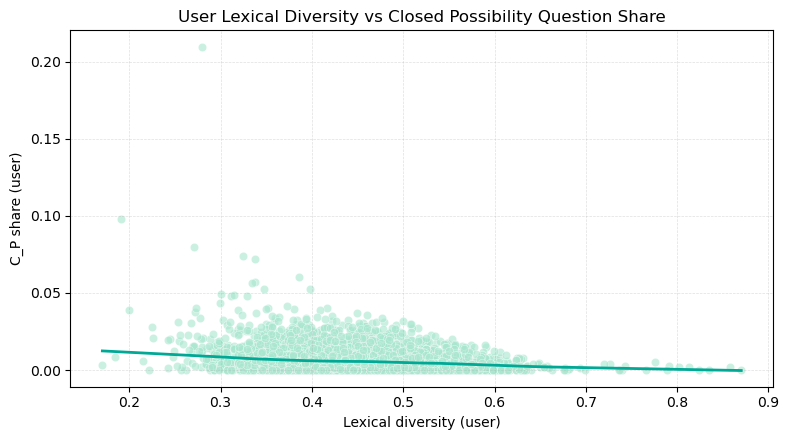

In [309]:
import statsmodels.api as sm

# user_lex already computed in your code

plt.figure(figsize=(8, 4.5))

ax = sns.scatterplot(
    data=user_lex,
    x='lexical_diversity',
    y='cp_share',
    alpha=0.6,
    color='#a8e6cf',           # pastel teal
    edgecolor='white',
    linewidth=0.4
)

# LOWESS trend line
x = user_lex['lexical_diversity'].values
y = user_lex['cp_share'].values
lowess = sm.nonparametric.lowess(y, x, frac=0.3, return_sorted=True)
ax.plot(lowess[:, 0], lowess[:, 1], color='#00a896', linewidth=2)  # darker teal

# Light grid
ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.4)

# Remove legend (there is none by default, but this is safe)
if ax.get_legend() is not None:
    ax.get_legend().remove()

plt.xlabel("Lexical diversity (user)")
plt.ylabel("C_P share (user)")
plt.title("User Lexical Diversity vs Closed Possibility Question Share")
plt.tight_layout()
plt.show()


**Key Findings**
- Users with richer vocabularies tend to rely even less on closed possibility questions, and overall C_P use is low for everyone.

- The cloud of points and the trend line both slope gently downward: as lexical diversity increases, C_P share decreases toward zero, so high‑diversity users almost never phrase queries as closed possibility questions.

- Users with noticeably higher C_P shares (above a few percent) appear only at lower lexical diversity values, indicating that heavier reliance on possibility‑framed questions is concentrated among users who reuse a narrower set of words.

#### (iv)  Closed Possibility Question Share by User Query Specificity


/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_85201/1199980236.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(


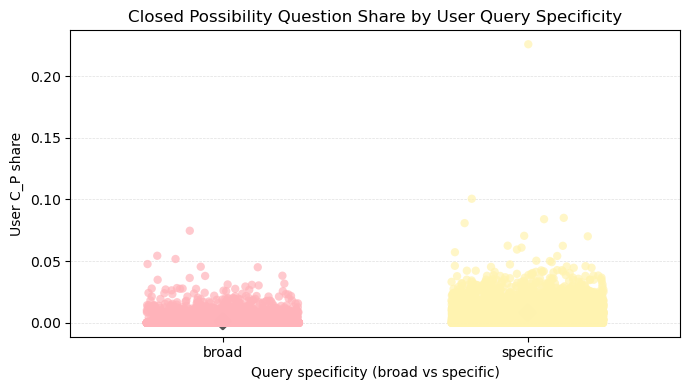

In [312]:
plt.figure(figsize=(7, 4))

ax = sns.stripplot(
    data=user_spec_cp,
    x='query_specificity',
    y='C_P_share',
    size=6,
    jitter=0.25,
    palette=['#ffb3ba', '#fff3b0'],   # pastel red / pastel yellow
    alpha=0.7
)

group_means = (
    user_spec_cp.groupby('query_specificity')['C_P_share']
                .mean()
                .reset_index()
)

sns.pointplot(
    data=group_means,
    x='query_specificity',
    y='C_P_share',
    join=False,
    color='#555555',
    markers='D',
    scale=1.1,
    errwidth=0,
    ax=ax
)

ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.4)

if ax.get_legend() is not None:
    ax.get_legend().remove()

ax.set_xlabel("Query specificity (broad vs specific)")
ax.set_ylabel("User C_P share")
ax.set_title("Closed Possibility Question Share by User Query Specificity")

plt.tight_layout()
plt.show()


**Key Findings**
- More specific queriers rely more on closed possibility questions, but the rate remains low overall for both groups.

- Users whose queries are specific show a visibly higher band of C_P shares, with many points around 0.02–0.05 and a few extreme cases above 0.1, indicating greater use of possibility‑framed questions when they ask narrowly scoped things.

- Users with broad queries have C_P shares tightly clustered near zero with only modest excursions above 0.03, so when people search in a more general way they rarely frame their questions in closed possibility form.

#### (h) Average Closed Possibility Question Rate by User Query Specificity

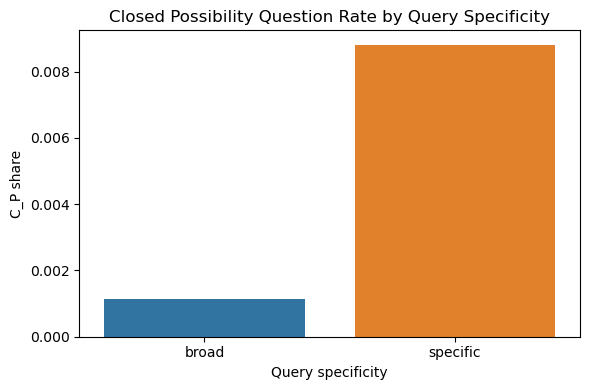

In [283]:
spec_stats_cp = (
    sb_cp.groupby('query_specificity', dropna=False)
         .agg(C_P_share=('C_P', 'mean'))
         .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=spec_stats_cp,
    x='query_specificity',
    y='C_P_share'
)
plt.xlabel("Query specificity")
plt.ylabel("C_P share")
plt.title("Closed Possibility Question Rate by Query Specificity")
plt.tight_layout()
plt.show()


**Key Findings**
- Users whose queries are specific show a visibly higher band of C_P shares, with many points around 0.02–0.05 and a few extreme cases above 0.1, indicating greater use of possibility‑framed questions when they ask narrowly scoped things.

- Users with broad queries have C_P shares tightly clustered near zero with only modest excursions above 0.03, so when people search in a more general way they rarely frame their questions in closed possibility form.



## 6. Saving Final CSV For Surface Deep

Removing the redundant columns created from plots:

In [313]:
df.head()

school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... time_total  \
0            True           False        1.0  ...       0.00   
1            True           False        2.0  ...     285.32   
2           False           False        2.0  ...     285.32   
3           False           False        2.0  ...     285.32   
4           False           False        2.0  ...     285.32   

   num_query_episode   O_NP                                  tokens n_tokens  \
0                1.0  False                                    [wy]        1   
1                4.0  False    [hospital, between, 1959, and, 1970]        5   
2                4.0  False  [hospital, between, 1960s, and, 1970s]        5   
3                4.0  False                 [hospital, after, 1965]        3   
4                4.0  False  [hospital, after, 1965, in, singapore]        5   

     O_P   C_NP  hour  time_period    C_P  
0  False  False  21.0      Evening  False  
1  False  False  21.0      Evening  False  
2  False  False  21.0      Evening  False  
3  False  False  21.0      Evening  False  
4  False  False  21.0      Evening  False  

[5 rows x 30 columns]

In [315]:
df = df.drop(columns=['hour', 'time_period'], errors='ignore')

In [316]:
df.head()

school_name                created_at  \
0  orchid_park_secondary 2023-07-09 21:06:21+00:00   
1  orchid_park_secondary 2023-07-09 21:21:00+00:00   
2  orchid_park_secondary 2023-07-09 21:21:54+00:00   
3  orchid_park_secondary 2023-07-09 21:24:07+00:00   
4  orchid_park_secondary 2023-07-09 21:24:34+00:00   

                                                 uri  device_name_actual  \
0  https://www.google.com/search?q=wy&rlz=1CAGWKK...               36719   
1  https://www.google.com/search?rlz=1CAGWKK_enSG...               36719   
2  https://www.google.com/search?q=hospital+betwe...               36719   
3  https://www.google.com/search?q=hospital+after...               36719   
4  https://www.google.com/search?q=hospital+after...               36719   

  was_allowed  profile_custom                          search_q  \
0        True             0.0                                wy   
1        True             0.0    hospital between 1959 and 1970   
2        True             0.0  hospital between 1960s and 1970s   
3        True             0.0               hospital after 1965   
4        True             0.0  hospital after 1965 in singapore   

  has_safe_active is_navigational  q_episode  ... is_reformulation  \
0            True           False        1.0  ...            False   
1            True           False        2.0  ...             True   
2           False           False        2.0  ...             True   
3           False           False        2.0  ...             True   
4           False           False        2.0  ...             True   

   time_interval time_total num_query_episode   O_NP  \
0           0.00       0.00               1.0  False   
1          71.33     285.32               4.0  False   
2          71.33     285.32               4.0  False   
3          71.33     285.32               4.0  False   
4          71.33     285.32               4.0  False   

                                   tokens  n_tokens    O_P   C_NP    C_P  
0                                    [wy]         1  False  False  False  
1    [hospital, between, 1959, and, 1970]         5  False  False  False  
2  [hospital, between, 1960s, and, 1970s]         5  False  False  False  
3                 [hospital, after, 1965]         3  False  False  False  
4  [hospital, after, 1965, in, singapore]         5  False  False  False  

[5 rows x 28 columns]

Saving the dataframe:

In [318]:
import pandas as pd
from tqdm import tqdm

# Path to save
output_path = "/Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv"

# Chunk size
chunksize = 100_000

total_rows = len(df)
first = True

for start in tqdm(range(0, total_rows, chunksize), desc="Saving CSV in chunks"):
    end = min(start + chunksize, total_rows)
    chunk = df.iloc[start:end]
    
    if first:
        chunk.to_csv(output_path, index=False, mode='w')  # write header once
        first = False
    else:
        chunk.to_csv(output_path, index=False, mode='a', header=False)  # append

print(f"Completed! DataFrame saved to: {output_path}")


Saving CSV in chunks: 100%|█████████████████████| 34/34 [01:07<00:00,  1.97s/it]

Completed! DataFrame saved to: /Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv


In [320]:
updated_df = pd.read_csv('/Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv')

/var/folders/_s/jbptsrkj25b9n_k1fq0pw42h0000gn/T/ipykernel_85201/4153026435.py:1: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  updated_df = pd.read_csv('/Users/tdf/Downloads/filtered_df_for_surface_deep_final.csv')


In [322]:
print(updated_df.shape)
print(updated_df.columns)

(3382011, 28)
Index(['school_name', 'created_at', 'uri', 'device_name_actual', 'was_allowed',
       'profile_custom', 'search_q', 'has_safe_active', 'is_navigational',
       'q_episode', 'regex', 'user_question_rate', 'closure', 'closure_words',
       'comparative', 'comparative_words', 'reformulation_levenshtein',
       'reformulation_levenshtein_norm', 'is_reformulation', 'time_interval',
       'time_total', 'num_query_episode', 'O_NP', 'tokens', 'n_tokens', 'O_P',
       'C_NP', 'C_P'],
      dtype='object')


All 3,382,011 rows are retained with 28 new columns.